# Well Count Analysis Notebook: 2 polygons

The purpose of this code is to give percentages of wells classified as having shallow groundwater and their relative proximity to streams.

To run this code, you need the following files in the appropriate folders:
 - Data/Output/Local
   - Master_ADWR_database_noduplicates.shp
   - Master_ADWR_database_water.shp
   - Wells55_GWSI_WLTS_DB_annual_updated.csv
 - Data/Input/Shapefiles
   - flowlines_order#plus.shp
   - WBDHU#.shp

In [13]:
# Packages and paths
# %%
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import geopandas as gp
import scipy.stats as sp
import sys
import seaborn as sns
import math
import dask.dataframe as dd
import dask_geopandas as dgp
import gc
import time

# Add the path to the Utils folder
utils_path = os.path.abspath(os.path.join('..', 'Utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import the functions from CustomFunctions.py
import CustomFunctions as cf

# Fun functions unique to this script
# Classify DTW values into categories 
def classify_dtw(dtw):
    if dtw < 2:
        return 'Near Surface (<2m)'
    elif 2 <= dtw < 5:
        return 'Very Shallow (2-5m)'
    elif 5 <= dtw < 10:
        return 'Shallow (5-10m)'
    else:
        return 'Deep (10-61m)'
    
def log_time(start, message):
    print(f"{message}. Elapsed time: {time.time() - start:.2f}s")

# Local paths
datapath = '../../Data'
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'
shapepath = inputpath+'/Shapefiles'
figurepath = '../../Figures/Local/'




Providing colors

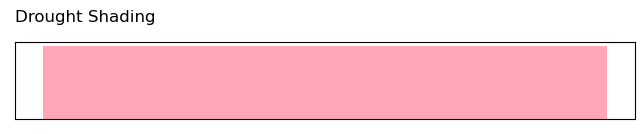

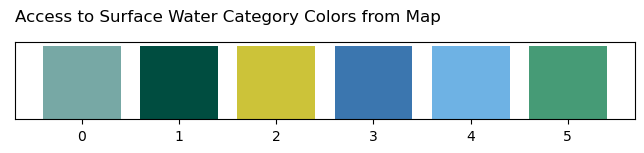

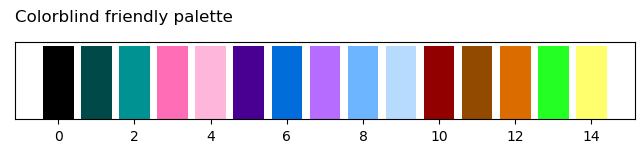

In [14]:
# %% Creating colors
drought_color = '#ffa6b8'

# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Colors from map
cap = '#77A8A5' #'#C6652B'
cap_secondary = '#004D40'
# noCAP = '#EDE461' # This is one from the map in the trend paper
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'
a2sw_colors =[cap,cap_secondary,noCAP,GWdom,mixed,swdom]

# Create a bar plot to visualize colors
palette = [drought_color]
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Drought Shading',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
ax.set_xticks([])
plt.show()

palette = a2sw_colors
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Access to Surface Water Category Colors from Map',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

palette = cblind
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Colorblind friendly palette',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

Going to try to consolidate all these steps into one workflow

In [15]:
# Put your huc number here
huc_num = '8'
# Distance here (if applicable)
distance = "100" #100, 500, 1000, 1500, 2000

# Define some things about your file

StudyArea = "HUC"+huc_num+"s"
Naming_col = "huc"+huc_num+""

start_time = time.time()

# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(outputpath, filename_mdb_nd)

# masterdb = gp.read_file(filepath)
masterdb = dgp.read_file(filepath, npartitions=20).persist()
pd.options.display.float_format = '{:.2f}'.format
log_time(start_time, "Master Database Loaded.")

# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py
filename_ts = 'Wells55_GWSI_WLTS_DB_monthly.csv'
filepath = os.path.join(outputpath, filename_ts)
# print(filepath)
annual_db = dd.read_csv(filepath, header=1)
annual_db = annual_db.set_index('date')
# #Block to do some formatting
annual_db = annual_db.iloc[:,1:168102]
annual_db = annual_db.set_index(annual_db.index.astype('int64'))
annual_db2 = annual_db.reset_index()
annual_db2 = annual_db2.rename(columns = {'date':'Combo_ID'})
# annual_db2.head()
log_time(start_time, "Annual timeseries database loaded")

# Read in the watershed shapefile
# filename_shapefile = 'WBDHU'+huc_num+'.shp'
# filepath = os.path.join(shapepath+"/WBD_15_HU2_Shape/Shape/", filename_shapefile) #This is the path for my laptop
# filename_shapefile = f'/{StudyArea}dissolvedbufferedflowlines_{distance}m.shp' # This is just buffered, not clipped
filename_shapefile = f'/test_{StudyArea}dissolvedbufferedflowlines_{distance}m.shp' # This is clipped
filepath = os.path.join(outputpath+filename_shapefile)

shapefile = dgp.read_file(filepath, npartitions=20).persist()
# shapefile = shapefile.rename(columns = {'huc'+huc_num:Naming_col,})
shapefile = shapefile[['huc'+huc_num,'geometry']]
log_time(start_time, "Boundary file loaded.")

shapefile = shapefile.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(26912)
static_geo = dgp.sjoin(masterdb2, shapefile, how="inner"
                    #   , op='intersects'
                      , predicate='intersects'
                      )

log_time(start_time,str(filename_mdb_nd) + " and " + str(filename_shapefile) + " join complete.")

static_geo = static_geo.drop(columns='index_right')
reg_list = static_geo[['Combo_ID', Naming_col,'WELL_DEPTH','WELL_TYPE_'
                    #    ,'reachcode','fcode','hydroseq'
                       ]]
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64
                                                   # , errors = 'raise'
                                                   )

# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
# %% set index to Combo_ID
combo.set_index('Combo_ID'
                # , inplace=True
                )
log_time(start_time,"Timeseries and static+shapefile merge complete.")

# Filter by drilling depth
test = combo.copy()
# test["WELL_DEPTH"] = test["WELL_DEPTH"].astype("float64")  # Converts column to integer (handles NaNs)
test = test[(test['WELL_DEPTH']<=200)&(test['WELL_DEPTH']>0)]
# test['WELL_DEPTH'].unique()
log_time(start_time, "Well drilling depth filtered.")

# df = test.reset_index()  # Moves well_ID from index to a column (if needed)
df = test.copy()
df = df.drop_duplicates(subset=["Combo_ID", Naming_col])
# df = df.set_index("Combo_ID")
log_time(start_time,"Duplicates dropped")

combo_copy = df.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_'
                            #   ,'nan','reachcode','fcode','hydroseq'
                              ],axis=1)


# Filter columns for readings after 1980
df = combo_copy.copy()
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']
mask = (df[date_cols] > 200).any(axis=1)
df_filtered = df[~mask]
log_time(start_time, "Dates filtered and anomolous readings deleted")

df = df_filtered.copy()
# df = df.reset_index()

# Convert column names (dates) to integers, excluding non-date columns like 'Well ID' and 'HUC'
# date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col]]
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']  # Keep only years >= 1980
# Create a new DataFrame with only relevant columns
df = df[['Combo_ID', Naming_col] + date_cols]

# Convert columns (dates) to rows, keeping 'HUC' and 'Well ID' as identifiers
df_melted = df.melt(id_vars=['Combo_ID', Naming_col], var_name='Date', value_name='DTW')
df_melted = df_melted.sort_values(by=[Naming_col, "Date"])
log_time(start_time, "Dataframe melted.")

del test, combo, static_geo, reg_list, df_filtered, combo_copy, df, masterdb, masterdb2, shapefile, annual_db, annual_db2
gc.collect()

# Convert 'Date' column to datetime format
df_melted['Date'] = dd.to_datetime(df_melted['Date'], format='%Y-%m')
df_melted = df_melted.dropna(subset=['DTW'])
log_time(start_time,"Date converted to datetime format in melted df.")

# Convert DTW from feet to meters
df_melted['DTW_meters'] = df_melted['DTW'] * 0.3048  # Apply conversion
df_melted['DTW_Category'] = df_melted['DTW_meters'].apply(classify_dtw, meta=('DTW_meters', float))
log_time(start_time,"Depth categories classified.")

# Extract decade for grouping (or use whole period if preferred)
df_melted['Decade'] = (df_melted['Date'].dt.year // 10) * 10  # Rounds to nearest decade

# Count the number of wells in each category per time period
summary_df = df_melted.groupby(['Decade', Naming_col,'DTW_Category'])['Combo_ID'].nunique().reset_index()
# summary_df = df_melted.groupby(['DTW_Category'])['Combo_ID'].nunique().reset_index()
# Rename for clarity
summary_df = summary_df.rename(columns={'Combo_ID': 'Well Count'}
                #   , inplace=True
                  )
log_time(start_time, "Summary dataframe created.")
summary_df.to_csv(outputpath+f'/{StudyArea}_{distance}mShallowGWWellCountSummary.csv', single_file=True)  # single_file=True ensures one output file
log_time(start_time, f'Summary dataframe for {StudyArea} and {distance} saved to .csv in {outputpath}')
df_melted.to_csv(outputpath+f'/{StudyArea}_{distance}mMeltedDataframe.csv', single_file=True)  # single_file=True ensures one output file
log_time(start_time, f'Melted dataframe  for {StudyArea} and {distance}saved to .csv in {outputpath}')




Master Database Loaded.. Elapsed time: 20.88s
Annual timeseries database loaded. Elapsed time: 103.57s
Boundary file loaded.. Elapsed time: 105.77s
Master_ADWR_database_noduplicates.shp and /test_HUC8sdissolvedbufferedflowlines_100m.shp join complete.. Elapsed time: 105.85s
Timeseries and static+shapefile merge complete.. Elapsed time: 305.29s
Well drilling depth filtered.. Elapsed time: 305.33s
Duplicates dropped. Elapsed time: 305.44s
Dates filtered and anomolous readings deleted. Elapsed time: 305.64s
Dataframe melted.. Elapsed time: 306.05s
Date converted to datetime format in melted df.. Elapsed time: 306.39s
Depth categories classified.. Elapsed time: 306.40s
Summary dataframe created.. Elapsed time: 308.13s
Summary dataframe for HUC8s and 100 saved to .csv in ../../Data/Output/Local. Elapsed time: 520.46s
Melted dataframe  for HUC8s and 100saved to .csv in ../../Data/Output/Local. Elapsed time: 725.25s


In [16]:
# Put your huc number here
huc_num = '8'
# Distance here (if applicable)
distance = "500" #100, 500, 1000, 1500, 2000

# Define some things about your file

StudyArea = "HUC"+huc_num+"s"
Naming_col = "huc"+huc_num+""

start_time = time.time()

# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(outputpath, filename_mdb_nd)

# masterdb = gp.read_file(filepath)
masterdb = dgp.read_file(filepath, npartitions=20).persist()
pd.options.display.float_format = '{:.2f}'.format
log_time(start_time, "Master Database Loaded.")

# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py
filename_ts = 'Wells55_GWSI_WLTS_DB_monthly.csv'
filepath = os.path.join(outputpath, filename_ts)
# print(filepath)
annual_db = dd.read_csv(filepath, header=1)
annual_db = annual_db.set_index('date')
# #Block to do some formatting
annual_db = annual_db.iloc[:,1:168102]
annual_db = annual_db.set_index(annual_db.index.astype('int64'))
annual_db2 = annual_db.reset_index()
annual_db2 = annual_db2.rename(columns = {'date':'Combo_ID'})
# annual_db2.head()
log_time(start_time, "Annual timeseries database loaded")

# Read in the watershed shapefile
# filename_shapefile = 'WBDHU'+huc_num+'.shp'
# filepath = os.path.join(shapepath+"/WBD_15_HU2_Shape/Shape/", filename_shapefile) #This is the path for my laptop
# filename_shapefile = f'/{StudyArea}dissolvedbufferedflowlines_{distance}m.shp' # This is just buffered, not clipped
filename_shapefile = f'/test_{StudyArea}dissolvedbufferedflowlines_{distance}m.shp' # This is clipped
filepath = os.path.join(outputpath+filename_shapefile)

shapefile = dgp.read_file(filepath, npartitions=20).persist()
# shapefile = shapefile.rename(columns = {'huc'+huc_num:Naming_col,})
shapefile = shapefile[['huc'+huc_num,'geometry']]
log_time(start_time, "Boundary file loaded.")

shapefile = shapefile.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(26912)
static_geo = dgp.sjoin(masterdb2, shapefile, how="inner"
                    #   , op='intersects'
                      , predicate='intersects'
                      )

log_time(start_time,str(filename_mdb_nd) + " and " + str(filename_shapefile) + " join complete.")

static_geo = static_geo.drop(columns='index_right')
reg_list = static_geo[['Combo_ID', Naming_col,'WELL_DEPTH','WELL_TYPE_'
                    #    ,'reachcode','fcode','hydroseq'
                       ]]
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64
                                                   # , errors = 'raise'
                                                   )

# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
# %% set index to Combo_ID
combo.set_index('Combo_ID'
                # , inplace=True
                )
log_time(start_time,"Timeseries and static+shapefile merge complete.")

# Filter by drilling depth
test = combo.copy()
# test["WELL_DEPTH"] = test["WELL_DEPTH"].astype("float64")  # Converts column to integer (handles NaNs)
test = test[(test['WELL_DEPTH']<=200)&(test['WELL_DEPTH']>0)]
# test['WELL_DEPTH'].unique()
log_time(start_time, "Well drilling depth filtered.")

# df = test.reset_index()  # Moves well_ID from index to a column (if needed)
df = test.copy()
df = df.drop_duplicates(subset=["Combo_ID", Naming_col])
# df = df.set_index("Combo_ID")
log_time(start_time,"Duplicates dropped")

combo_copy = df.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_'
                            #   ,'nan','reachcode','fcode','hydroseq'
                              ],axis=1)


# Filter columns for readings after 1980
df = combo_copy.copy()
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']
mask = (df[date_cols] > 200).any(axis=1)
df_filtered = df[~mask]
log_time(start_time, "Dates filtered and anomolous readings deleted")

df = df_filtered.copy()
# df = df.reset_index()

# Convert column names (dates) to integers, excluding non-date columns like 'Well ID' and 'HUC'
# date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col]]
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']  # Keep only years >= 1980
# Create a new DataFrame with only relevant columns
df = df[['Combo_ID', Naming_col] + date_cols]

# Convert columns (dates) to rows, keeping 'HUC' and 'Well ID' as identifiers
df_melted = df.melt(id_vars=['Combo_ID', Naming_col], var_name='Date', value_name='DTW')
df_melted = df_melted.sort_values(by=[Naming_col, "Date"])
log_time(start_time, "Dataframe melted.")

del test, combo, static_geo, reg_list, df_filtered, combo_copy, df, masterdb, masterdb2, shapefile, annual_db, annual_db2
gc.collect()

# Convert 'Date' column to datetime format
df_melted['Date'] = dd.to_datetime(df_melted['Date'], format='%Y-%m')
df_melted = df_melted.dropna(subset=['DTW'])
log_time(start_time,"Date converted to datetime format in melted df.")

# Convert DTW from feet to meters
df_melted['DTW_meters'] = df_melted['DTW'] * 0.3048  # Apply conversion
df_melted['DTW_Category'] = df_melted['DTW_meters'].apply(classify_dtw, meta=('DTW_meters', float))
log_time(start_time,"Depth categories classified.")

# Extract decade for grouping (or use whole period if preferred)
df_melted['Decade'] = (df_melted['Date'].dt.year // 10) * 10  # Rounds to nearest decade

# Count the number of wells in each category per time period
summary_df = df_melted.groupby(['Decade', Naming_col,'DTW_Category'])['Combo_ID'].nunique().reset_index()
# summary_df = df_melted.groupby(['DTW_Category'])['Combo_ID'].nunique().reset_index()
# Rename for clarity
summary_df = summary_df.rename(columns={'Combo_ID': 'Well Count'}
                #   , inplace=True
                  )
log_time(start_time, "Summary dataframe created.")
summary_df.to_csv(outputpath+f'/{StudyArea}_{distance}mShallowGWWellCountSummary.csv', single_file=True)  # single_file=True ensures one output file
log_time(start_time, f'Summary dataframe for {StudyArea} and {distance} saved to .csv in {outputpath}')
df_melted.to_csv(outputpath+f'/{StudyArea}_{distance}mMeltedDataframe.csv', single_file=True)  # single_file=True ensures one output file
log_time(start_time, f'Melted dataframe  for {StudyArea} and {distance}saved to .csv in {outputpath}')



Master Database Loaded.. Elapsed time: 15.06s
Annual timeseries database loaded. Elapsed time: 83.21s
Boundary file loaded.. Elapsed time: 84.04s
Master_ADWR_database_noduplicates.shp and /test_HUC8sdissolvedbufferedflowlines_500m.shp join complete.. Elapsed time: 84.14s
Timeseries and static+shapefile merge complete.. Elapsed time: 219.11s
Well drilling depth filtered.. Elapsed time: 219.16s
Duplicates dropped. Elapsed time: 221.12s
Dates filtered and anomolous readings deleted. Elapsed time: 221.32s
Dataframe melted.. Elapsed time: 221.40s
Date converted to datetime format in melted df.. Elapsed time: 221.74s
Depth categories classified.. Elapsed time: 221.74s
Summary dataframe created.. Elapsed time: 223.82s
Summary dataframe for HUC8s and 500 saved to .csv in ../../Data/Output/Local. Elapsed time: 332.39s
Melted dataframe  for HUC8s and 500saved to .csv in ../../Data/Output/Local. Elapsed time: 440.06s


In [17]:
# Put your huc number here
huc_num = '8'
# Distance here (if applicable)
distance = "1000" #100, 500, 1000, 1500, 2000

# Define some things about your file

StudyArea = "HUC"+huc_num+"s"
Naming_col = "huc"+huc_num+""

start_time = time.time()

# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(outputpath, filename_mdb_nd)

# masterdb = gp.read_file(filepath)
masterdb = dgp.read_file(filepath, npartitions=20).persist()
pd.options.display.float_format = '{:.2f}'.format
log_time(start_time, "Master Database Loaded.")

# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py
filename_ts = 'Wells55_GWSI_WLTS_DB_monthly.csv'
filepath = os.path.join(outputpath, filename_ts)
# print(filepath)
annual_db = dd.read_csv(filepath, header=1)
annual_db = annual_db.set_index('date')
# #Block to do some formatting
annual_db = annual_db.iloc[:,1:168102]
annual_db = annual_db.set_index(annual_db.index.astype('int64'))
annual_db2 = annual_db.reset_index()
annual_db2 = annual_db2.rename(columns = {'date':'Combo_ID'})
# annual_db2.head()
log_time(start_time, "Annual timeseries database loaded")

# Read in the watershed shapefile
# filename_shapefile = 'WBDHU'+huc_num+'.shp'
# filepath = os.path.join(shapepath+"/WBD_15_HU2_Shape/Shape/", filename_shapefile) #This is the path for my laptop
# filename_shapefile = f'/{StudyArea}dissolvedbufferedflowlines_{distance}m.shp' # This is just buffered, not clipped
filename_shapefile = f'/test_{StudyArea}dissolvedbufferedflowlines_{distance}m.shp' # This is clipped
filepath = os.path.join(outputpath+filename_shapefile)

shapefile = dgp.read_file(filepath, npartitions=20).persist()
# shapefile = shapefile.rename(columns = {'huc'+huc_num:Naming_col,})
shapefile = shapefile[['huc'+huc_num,'geometry']]
log_time(start_time, "Boundary file loaded.")

shapefile = shapefile.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(26912)
static_geo = dgp.sjoin(masterdb2, shapefile, how="inner"
                    #   , op='intersects'
                      , predicate='intersects'
                      )

log_time(start_time,str(filename_mdb_nd) + " and " + str(filename_shapefile) + " join complete.")

static_geo = static_geo.drop(columns='index_right')
reg_list = static_geo[['Combo_ID', Naming_col,'WELL_DEPTH','WELL_TYPE_'
                    #    ,'reachcode','fcode','hydroseq'
                       ]]
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64
                                                   # , errors = 'raise'
                                                   )

# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
# %% set index to Combo_ID
combo.set_index('Combo_ID'
                # , inplace=True
                )
log_time(start_time,"Timeseries and static+shapefile merge complete.")

# Filter by drilling depth
test = combo.copy()
# test["WELL_DEPTH"] = test["WELL_DEPTH"].astype("float64")  # Converts column to integer (handles NaNs)
test = test[(test['WELL_DEPTH']<=200)&(test['WELL_DEPTH']>0)]
# test['WELL_DEPTH'].unique()
log_time(start_time, "Well drilling depth filtered.")

# df = test.reset_index()  # Moves well_ID from index to a column (if needed)
df = test.copy()
df = df.drop_duplicates(subset=["Combo_ID", Naming_col])
# df = df.set_index("Combo_ID")
log_time(start_time,"Duplicates dropped")

combo_copy = df.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_'
                            #   ,'nan','reachcode','fcode','hydroseq'
                              ],axis=1)


# Filter columns for readings after 1980
df = combo_copy.copy()
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']
mask = (df[date_cols] > 200).any(axis=1)
df_filtered = df[~mask]
log_time(start_time, "Dates filtered and anomolous readings deleted")

df = df_filtered.copy()
# df = df.reset_index()

# Convert column names (dates) to integers, excluding non-date columns like 'Well ID' and 'HUC'
# date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col]]
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']  # Keep only years >= 1980
# Create a new DataFrame with only relevant columns
df = df[['Combo_ID', Naming_col] + date_cols]

# Convert columns (dates) to rows, keeping 'HUC' and 'Well ID' as identifiers
df_melted = df.melt(id_vars=['Combo_ID', Naming_col], var_name='Date', value_name='DTW')
df_melted = df_melted.sort_values(by=[Naming_col, "Date"])
log_time(start_time, "Dataframe melted.")

del test, combo, static_geo, reg_list, df_filtered, combo_copy, df, masterdb, masterdb2, shapefile, annual_db, annual_db2
gc.collect()

# Convert 'Date' column to datetime format
df_melted['Date'] = dd.to_datetime(df_melted['Date'], format='%Y-%m')
df_melted = df_melted.dropna(subset=['DTW'])
log_time(start_time,"Date converted to datetime format in melted df.")

# Convert DTW from feet to meters
df_melted['DTW_meters'] = df_melted['DTW'] * 0.3048  # Apply conversion
df_melted['DTW_Category'] = df_melted['DTW_meters'].apply(classify_dtw, meta=('DTW_meters', float))
log_time(start_time,"Depth categories classified.")

# Extract decade for grouping (or use whole period if preferred)
df_melted['Decade'] = (df_melted['Date'].dt.year // 10) * 10  # Rounds to nearest decade

# Count the number of wells in each category per time period
summary_df = df_melted.groupby(['Decade', Naming_col,'DTW_Category'])['Combo_ID'].nunique().reset_index()
# summary_df = df_melted.groupby(['DTW_Category'])['Combo_ID'].nunique().reset_index()
# Rename for clarity
summary_df = summary_df.rename(columns={'Combo_ID': 'Well Count'}
                #   , inplace=True
                  )
log_time(start_time, "Summary dataframe created.")
summary_df.to_csv(outputpath+f'/{StudyArea}_{distance}mShallowGWWellCountSummary.csv', single_file=True)  # single_file=True ensures one output file
log_time(start_time, f'Summary dataframe for {StudyArea} and {distance} saved to .csv in {outputpath}')
df_melted.to_csv(outputpath+f'/{StudyArea}_{distance}mMeltedDataframe.csv', single_file=True)  # single_file=True ensures one output file
log_time(start_time, f'Melted dataframe  for {StudyArea} and {distance}saved to .csv in {outputpath}')



Master Database Loaded.. Elapsed time: 14.33s
Annual timeseries database loaded. Elapsed time: 77.08s
Boundary file loaded.. Elapsed time: 77.62s
Master_ADWR_database_noduplicates.shp and /test_HUC8sdissolvedbufferedflowlines_1000m.shp join complete.. Elapsed time: 77.69s
Timeseries and static+shapefile merge complete.. Elapsed time: 190.78s
Well drilling depth filtered.. Elapsed time: 190.81s
Duplicates dropped. Elapsed time: 190.92s
Dates filtered and anomolous readings deleted. Elapsed time: 191.11s
Dataframe melted.. Elapsed time: 191.18s
Date converted to datetime format in melted df.. Elapsed time: 191.51s
Depth categories classified.. Elapsed time: 191.52s
Summary dataframe created.. Elapsed time: 192.54s
Summary dataframe for HUC8s and 1000 saved to .csv in ../../Data/Output/Local. Elapsed time: 286.00s
Melted dataframe  for HUC8s and 1000saved to .csv in ../../Data/Output/Local. Elapsed time: 377.81s


In [18]:
# Put your huc number here
huc_num = '8'
# Distance here (if applicable)
distance = "1500" #100, 500, 1000, 1500, 2000

# Define some things about your file

StudyArea = "HUC"+huc_num+"s"
Naming_col = "huc"+huc_num+""

start_time = time.time()

# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(outputpath, filename_mdb_nd)

# masterdb = gp.read_file(filepath)
masterdb = dgp.read_file(filepath, npartitions=20).persist()
pd.options.display.float_format = '{:.2f}'.format
log_time(start_time, "Master Database Loaded.")

# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py
filename_ts = 'Wells55_GWSI_WLTS_DB_monthly.csv'
filepath = os.path.join(outputpath, filename_ts)
# print(filepath)
annual_db = dd.read_csv(filepath, header=1)
annual_db = annual_db.set_index('date')
# #Block to do some formatting
annual_db = annual_db.iloc[:,1:168102]
annual_db = annual_db.set_index(annual_db.index.astype('int64'))
annual_db2 = annual_db.reset_index()
annual_db2 = annual_db2.rename(columns = {'date':'Combo_ID'})
# annual_db2.head()
log_time(start_time, "Annual timeseries database loaded")

# Read in the watershed shapefile
# filename_shapefile = 'WBDHU'+huc_num+'.shp'
# filepath = os.path.join(shapepath+"/WBD_15_HU2_Shape/Shape/", filename_shapefile) #This is the path for my laptop
# filename_shapefile = f'/{StudyArea}dissolvedbufferedflowlines_{distance}m.shp' # This is just buffered, not clipped
filename_shapefile = f'/test_{StudyArea}dissolvedbufferedflowlines_{distance}m.shp' # This is clipped
filepath = os.path.join(outputpath+filename_shapefile)

shapefile = dgp.read_file(filepath, npartitions=20).persist()
# shapefile = shapefile.rename(columns = {'huc'+huc_num:Naming_col,})
shapefile = shapefile[['huc'+huc_num,'geometry']]
log_time(start_time, "Boundary file loaded.")

shapefile = shapefile.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(26912)
static_geo = dgp.sjoin(masterdb2, shapefile, how="inner"
                    #   , op='intersects'
                      , predicate='intersects'
                      )

log_time(start_time,str(filename_mdb_nd) + " and " + str(filename_shapefile) + " join complete.")

static_geo = static_geo.drop(columns='index_right')
reg_list = static_geo[['Combo_ID', Naming_col,'WELL_DEPTH','WELL_TYPE_'
                    #    ,'reachcode','fcode','hydroseq'
                       ]]
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64
                                                   # , errors = 'raise'
                                                   )

# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
# %% set index to Combo_ID
combo.set_index('Combo_ID'
                # , inplace=True
                )
log_time(start_time,"Timeseries and static+shapefile merge complete.")

# Filter by drilling depth
test = combo.copy()
# test["WELL_DEPTH"] = test["WELL_DEPTH"].astype("float64")  # Converts column to integer (handles NaNs)
test = test[(test['WELL_DEPTH']<=200)&(test['WELL_DEPTH']>0)]
# test['WELL_DEPTH'].unique()
log_time(start_time, "Well drilling depth filtered.")

# df = test.reset_index()  # Moves well_ID from index to a column (if needed)
df = test.copy()
df = df.drop_duplicates(subset=["Combo_ID", Naming_col])
# df = df.set_index("Combo_ID")
log_time(start_time,"Duplicates dropped")

combo_copy = df.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_'
                            #   ,'nan','reachcode','fcode','hydroseq'
                              ],axis=1)


# Filter columns for readings after 1980
df = combo_copy.copy()
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']
mask = (df[date_cols] > 200).any(axis=1)
df_filtered = df[~mask]
log_time(start_time, "Dates filtered and anomolous readings deleted")

df = df_filtered.copy()
# df = df.reset_index()

# Convert column names (dates) to integers, excluding non-date columns like 'Well ID' and 'HUC'
# date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col]]
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']  # Keep only years >= 1980
# Create a new DataFrame with only relevant columns
df = df[['Combo_ID', Naming_col] + date_cols]

# Convert columns (dates) to rows, keeping 'HUC' and 'Well ID' as identifiers
df_melted = df.melt(id_vars=['Combo_ID', Naming_col], var_name='Date', value_name='DTW')
df_melted = df_melted.sort_values(by=[Naming_col, "Date"])
log_time(start_time, "Dataframe melted.")

del test, combo, static_geo, reg_list, df_filtered, combo_copy, df, masterdb, masterdb2, shapefile, annual_db, annual_db2
gc.collect()

# Convert 'Date' column to datetime format
df_melted['Date'] = dd.to_datetime(df_melted['Date'], format='%Y-%m')
df_melted = df_melted.dropna(subset=['DTW'])
log_time(start_time,"Date converted to datetime format in melted df.")

# Convert DTW from feet to meters
df_melted['DTW_meters'] = df_melted['DTW'] * 0.3048  # Apply conversion
df_melted['DTW_Category'] = df_melted['DTW_meters'].apply(classify_dtw, meta=('DTW_meters', float))
log_time(start_time,"Depth categories classified.")

# Extract decade for grouping (or use whole period if preferred)
df_melted['Decade'] = (df_melted['Date'].dt.year // 10) * 10  # Rounds to nearest decade

# Count the number of wells in each category per time period
summary_df = df_melted.groupby(['Decade', Naming_col,'DTW_Category'])['Combo_ID'].nunique().reset_index()
# summary_df = df_melted.groupby(['DTW_Category'])['Combo_ID'].nunique().reset_index()
# Rename for clarity
summary_df = summary_df.rename(columns={'Combo_ID': 'Well Count'}
                #   , inplace=True
                  )
log_time(start_time, "Summary dataframe created.")
summary_df.to_csv(outputpath+f'/{StudyArea}_{distance}mShallowGWWellCountSummary.csv', single_file=True)  # single_file=True ensures one output file
log_time(start_time, f'Summary dataframe for {StudyArea} and {distance} saved to .csv in {outputpath}')
df_melted.to_csv(outputpath+f'/{StudyArea}_{distance}mMeltedDataframe.csv', single_file=True)  # single_file=True ensures one output file
log_time(start_time, f'Melted dataframe  for {StudyArea} and {distance}saved to .csv in {outputpath}')



Master Database Loaded.. Elapsed time: 13.90s
Annual timeseries database loaded. Elapsed time: 80.62s
Boundary file loaded.. Elapsed time: 81.08s
Master_ADWR_database_noduplicates.shp and /test_HUC8sdissolvedbufferedflowlines_1500m.shp join complete.. Elapsed time: 81.14s
Timeseries and static+shapefile merge complete.. Elapsed time: 208.13s
Well drilling depth filtered.. Elapsed time: 208.18s
Duplicates dropped. Elapsed time: 208.29s
Dates filtered and anomolous readings deleted. Elapsed time: 210.82s
Dataframe melted.. Elapsed time: 210.89s
Date converted to datetime format in melted df.. Elapsed time: 211.23s
Depth categories classified.. Elapsed time: 211.24s
Summary dataframe created.. Elapsed time: 213.23s
Summary dataframe for HUC8s and 1500 saved to .csv in ../../Data/Output/Local. Elapsed time: 305.87s
Melted dataframe  for HUC8s and 1500saved to .csv in ../../Data/Output/Local. Elapsed time: 398.01s


In [19]:
# Put your huc number here
huc_num = '8'
# Distance here (if applicable)
distance = "2000" #100, 500, 1000, 1500, 2000

# Define some things about your file

StudyArea = "HUC"+huc_num+"s"
Naming_col = "huc"+huc_num+""

start_time = time.time()

# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(outputpath, filename_mdb_nd)

# masterdb = gp.read_file(filepath)
masterdb = dgp.read_file(filepath, npartitions=20).persist()
pd.options.display.float_format = '{:.2f}'.format
log_time(start_time, "Master Database Loaded.")

# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py
filename_ts = 'Wells55_GWSI_WLTS_DB_monthly.csv'
filepath = os.path.join(outputpath, filename_ts)
# print(filepath)
annual_db = dd.read_csv(filepath, header=1)
annual_db = annual_db.set_index('date')
# #Block to do some formatting
annual_db = annual_db.iloc[:,1:168102]
annual_db = annual_db.set_index(annual_db.index.astype('int64'))
annual_db2 = annual_db.reset_index()
annual_db2 = annual_db2.rename(columns = {'date':'Combo_ID'})
# annual_db2.head()
log_time(start_time, "Annual timeseries database loaded")

# Read in the watershed shapefile
# filename_shapefile = 'WBDHU'+huc_num+'.shp'
# filepath = os.path.join(shapepath+"/WBD_15_HU2_Shape/Shape/", filename_shapefile) #This is the path for my laptop
# filename_shapefile = f'/{StudyArea}dissolvedbufferedflowlines_{distance}m.shp' # This is just buffered, not clipped
filename_shapefile = f'/test_{StudyArea}dissolvedbufferedflowlines_{distance}m.shp' # This is clipped
filepath = os.path.join(outputpath+filename_shapefile)

shapefile = dgp.read_file(filepath, npartitions=20).persist()
# shapefile = shapefile.rename(columns = {'huc'+huc_num:Naming_col,})
shapefile = shapefile[['huc'+huc_num,'geometry']]
log_time(start_time, "Boundary file loaded.")

shapefile = shapefile.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(26912)
static_geo = dgp.sjoin(masterdb2, shapefile, how="inner"
                    #   , op='intersects'
                      , predicate='intersects'
                      )

log_time(start_time,str(filename_mdb_nd) + " and " + str(filename_shapefile) + " join complete.")

static_geo = static_geo.drop(columns='index_right')
reg_list = static_geo[['Combo_ID', Naming_col,'WELL_DEPTH','WELL_TYPE_'
                    #    ,'reachcode','fcode','hydroseq'
                       ]]
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64
                                                   # , errors = 'raise'
                                                   )

# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
# %% set index to Combo_ID
combo.set_index('Combo_ID'
                # , inplace=True
                )
log_time(start_time,"Timeseries and static+shapefile merge complete.")

# Filter by drilling depth
test = combo.copy()
# test["WELL_DEPTH"] = test["WELL_DEPTH"].astype("float64")  # Converts column to integer (handles NaNs)
test = test[(test['WELL_DEPTH']<=200)&(test['WELL_DEPTH']>0)]
# test['WELL_DEPTH'].unique()
log_time(start_time, "Well drilling depth filtered.")

# df = test.reset_index()  # Moves well_ID from index to a column (if needed)
df = test.copy()
df = df.drop_duplicates(subset=["Combo_ID", Naming_col])
# df = df.set_index("Combo_ID")
log_time(start_time,"Duplicates dropped")

combo_copy = df.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_'
                            #   ,'nan','reachcode','fcode','hydroseq'
                              ],axis=1)


# Filter columns for readings after 1980
df = combo_copy.copy()
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']
mask = (df[date_cols] > 200).any(axis=1)
df_filtered = df[~mask]
log_time(start_time, "Dates filtered and anomolous readings deleted")

df = df_filtered.copy()
# df = df.reset_index()

# Convert column names (dates) to integers, excluding non-date columns like 'Well ID' and 'HUC'
# date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col]]
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']  # Keep only years >= 1980
# Create a new DataFrame with only relevant columns
df = df[['Combo_ID', Naming_col] + date_cols]

# Convert columns (dates) to rows, keeping 'HUC' and 'Well ID' as identifiers
df_melted = df.melt(id_vars=['Combo_ID', Naming_col], var_name='Date', value_name='DTW')
df_melted = df_melted.sort_values(by=[Naming_col, "Date"])
log_time(start_time, "Dataframe melted.")

del test, combo, static_geo, reg_list, df_filtered, combo_copy, df, masterdb, masterdb2, shapefile, annual_db, annual_db2
gc.collect()

# Convert 'Date' column to datetime format
df_melted['Date'] = dd.to_datetime(df_melted['Date'], format='%Y-%m')
df_melted = df_melted.dropna(subset=['DTW'])
log_time(start_time,"Date converted to datetime format in melted df.")

# Convert DTW from feet to meters
df_melted['DTW_meters'] = df_melted['DTW'] * 0.3048  # Apply conversion
df_melted['DTW_Category'] = df_melted['DTW_meters'].apply(classify_dtw, meta=('DTW_meters', float))
log_time(start_time,"Depth categories classified.")

# Extract decade for grouping (or use whole period if preferred)
df_melted['Decade'] = (df_melted['Date'].dt.year // 10) * 10  # Rounds to nearest decade

# Count the number of wells in each category per time period
summary_df = df_melted.groupby(['Decade', Naming_col,'DTW_Category'])['Combo_ID'].nunique().reset_index()
# summary_df = df_melted.groupby(['DTW_Category'])['Combo_ID'].nunique().reset_index()
# Rename for clarity
summary_df = summary_df.rename(columns={'Combo_ID': 'Well Count'}
                #   , inplace=True
                  )
log_time(start_time, "Summary dataframe created.")
summary_df.to_csv(outputpath+f'/{StudyArea}_{distance}mShallowGWWellCountSummary.csv', single_file=True)  # single_file=True ensures one output file
log_time(start_time, f'Summary dataframe for {StudyArea} and {distance} saved to .csv in {outputpath}')
df_melted.to_csv(outputpath+f'/{StudyArea}_{distance}mMeltedDataframe.csv', single_file=True)  # single_file=True ensures one output file
log_time(start_time, f'Melted dataframe  for {StudyArea} and {distance}saved to .csv in {outputpath}')



Master Database Loaded.. Elapsed time: 13.72s
Annual timeseries database loaded. Elapsed time: 82.42s
Boundary file loaded.. Elapsed time: 82.77s
Master_ADWR_database_noduplicates.shp and /test_HUC8sdissolvedbufferedflowlines_2000m.shp join complete.. Elapsed time: 82.84s
Timeseries and static+shapefile merge complete.. Elapsed time: 208.43s
Well drilling depth filtered.. Elapsed time: 208.47s
Duplicates dropped. Elapsed time: 208.57s
Dates filtered and anomolous readings deleted. Elapsed time: 208.77s
Dataframe melted.. Elapsed time: 208.85s
Date converted to datetime format in melted df.. Elapsed time: 209.21s
Depth categories classified.. Elapsed time: 209.22s
Summary dataframe created.. Elapsed time: 210.75s
Summary dataframe for HUC8s and 2000 saved to .csv in ../../Data/Output/Local. Elapsed time: 303.49s
Melted dataframe  for HUC8s and 2000saved to .csv in ../../Data/Output/Local. Elapsed time: 396.18s


____
This is old code failed
___

This is where we do the above but to river lengths of different distances

In [ ]:
distances = [100, 
             500, 
             1000, 
             1500, 
             2000
             ]

start_time = time.time()

# Create some dictionaries
sgdb_distances = {}  # Storing static databases
combo_distances = {} # Storing combo databases
melted_distances = {} # Melted dataframes
summary_distances = {} # Well counts and such

for i in distances:   
    print(f"Initializing analysis for {i}m...")
    filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
    filepath = os.path.join(outputpath, filename_mdb_nd)
    mdb = dgp.read_file(filepath, npartitions=2).persist()
    pd.options.display.float_format = '{:.2f}'.format
    mdb = mdb.set_crs(26912)
    print()
    log_time(start_time, "Master Database Loaded.")

    filename_ts = 'Wells55_GWSI_WLTS_DB_monthly.csv'
    filepath = os.path.join(outputpath, filename_ts)
    adb = dd.read_csv(filepath, header=1)
    adb = adb.set_index('date')
    adb = adb.iloc[:,1:168102]
    adb = adb.set_index(adb.index.astype('int64'))
    adb = adb.reset_index()
    adb = adb.rename(columns = {'date':'Combo_ID'})
    print()
    log_time(start_time, "Annual timeseries database loaded")

    filename_shapefile = '/huc'+huc_num+'flowlines_order3plus.shp'
    filepath = os.path.join(outputpath+filename_shapefile)
    b = dgp.read_file(filepath, npartitions=2)
    b = b.to_crs(3857)
    b['geometry'] = b.geometry.buffer(i)
    b = b.to_crs(epsg=26912)
    print()
    log_time(start_time,f"Buffering {i}m complete.")


    sgdb_distances[f"sgdb_{i}m"] = dgp.sjoin(mdb, b, how="inner", 
                                        # , op='intersects' 
                                          predicate="intersects"
                                          )
    print()
    log_time(start_time,f"{filename_mdb_nd} and {i}m shapefile join complete.")
    # sgdb_distances[f"sgdb_{i}m"].plot()
    sgdb_i = sgdb_distances[f"sgdb_{i}m"]
    sgdb_i = sgdb_i.drop(columns='index_right')

    # Clean up memory after each loop
    del b, mdb
    gc.collect()
    
    reg_list = sgdb_i[['Combo_ID', Naming_col,'WELL_DEPTH'
                       ,'WELL_TYPE_'
                      # ,'reachcode','fcode','hydroseq'
                  ]]

    # Converting Combo_ID to int
    reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64)

    # Merging the Timeseries and the shapefile static database
    combo_distances[f"combo_{i}m"] = adb.merge(reg_list, how="inner")
    combo_i = combo_distances[f"combo_{i}m"]
    print()
    log_time(start_time,f"Creating the combo database for {i}m complete.")
    del adb

    # Makes sure wells aren't being counted twice
    combo_i = combo_i.drop_duplicates(subset=["Combo_ID", Naming_col])
    print()
    log_time(start_time,f"Duplicates dropped.")
    combo_i = combo_i[(combo_i['WELL_DEPTH']<=200)&(combo_i['WELL_DEPTH']>0)]
    print()
    log_time(start_time,f"Only wells drilled between 0 and 200ft (61m) are filtered.")

    # Gets it ready for stats
    combo_i = combo_i.drop(['WELL_DEPTH','WELL_TYPE_'
                            # ,'nan'
                            # ,'reachcode'
                            # ,'fcode','hydroseq'
                            ],axis=1)

    # Makes sure we don't get any deep readings
    df_i = combo_i.copy()
    date_cols = [col for col in df_i.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']
    mask = (df_i[date_cols] > 200).any(axis=1)
    df_filtered_i = df_i[~mask]
    combo_i = df_filtered_i.copy()
    print()
    log_time(start_time,f"Only wells without anomalous readings are selected.")

    combo_i = combo_i.reset_index()
    date_cols = [col for col in combo_i.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']  # Keep only years >= 1980
    combo_i = combo_i[['Combo_ID', Naming_col] + date_cols]
    print()
    log_time(start_time,f"Timeframe narrowed (1980-01 to present).")

    # Now to melt:
    melt_i = combo_i.melt(id_vars=['Combo_ID', Naming_col], var_name='Date', value_name='DTW')
    print()
    log_time(start_time,f"Melting {i} dataframe complete.")
    del combo_i
    gc.collect()
    melt_i['Date'] = dd.to_datetime(melt_i['Date'], format='%Y-%m')
    print()
    log_time(start_time,"Date converted to datetime format in melted df.")
    melt_i = melt_i.dropna(subset=['DTW'])
    melt_i['DTW_meters'] = melt_i['DTW'] * 0.3048  #convert to m
    melt_i['DTW_Category'] = melt_i['DTW_meters'].apply(classify_dtw, meta=('DTW_meters', float))
    print()
    log_time(start_time,"Depth categories classified.")
    melt_i['Decade'] = (melt_i['Date'].dt.year // 10) * 10  # Rounds to nearest decade
    melt_i = melt_i.sort_values(by=[Naming_col,"Date"])
    melted_distances[f"melt_{i}m"] = melt_i #store the database in the dictionary
    print()
    log_time(start_time,f"Melting {i} dataframe formatted.")

    # Counting the number of wells in each category per time period
    summary_i = melt_i.groupby(['Decade', Naming_col, 'DTW_Category'])['Combo_ID'].nunique().reset_index()
    summary_i = summary_i.rename(columns={'Combo_ID': 'Well Count'})
    summary_distances[f"summary_{i}m"] = summary_i
    print()
    log_time(start_time,f"Summary database complete.")

    #Now to add to the man dataframe for maths
    # summary_df[f"Count_{i}m"] = summary_distances[f"summary_{i}m"]['Well Count']
    summary_i.to_csv(outputpath+f'/{StudyArea}_{i}_ShallowGWWellCountSummary.csv', single_file=True)  # single_file=True ensures one output file
    print()

print("Done!")

Initializing analysis for 100...

Master Database Loaded.. Elapsed time: 13.31s

Annual timeseries database loaded. Elapsed time: 62.14s

Buffering 100m complete.. Elapsed time: 62.38s

Master_ADWR_database_noduplicates.shp and 100m shapefile join complete.. Elapsed time: 62.40s

Creating the combo database for 100m complete.. Elapsed time: 63.06s

Duplicates dropped.. Elapsed time: 63.15s

Only wells drilled between 0 and 200ft (61m) are filtered.. Elapsed time: 63.16s

Only wells without anomalous readings are selected.. Elapsed time: 63.36s

Timeframe narrowed (1980-01 to present).. Elapsed time: 63.70s

Melting 100 dataframe complete.. Elapsed time: 63.74s

Date converted to datetime format in melted df.. Elapsed time: 63.94s

Depth categories classified.. Elapsed time: 63.95s

Melting 100 dataframe formatted.. Elapsed time: 63.96s

Summary database complete.. Elapsed time: 63.97s


ValueError: time data "index" doesn't match format "%Y-%m", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

40 minutes later and I got that error message.  I'm pretty over this so I'm just going to do this one by one

In [ ]:
# Put your huc number here
huc_num = '4'

# Distance to stream
distance = 2000

# Define some things about your file

StudyArea = "HUC"+huc_num+"s"
Naming_col = "huc"+huc_num+""

start_time = time.time()

print(f"Initializing {distance}m analysis...")

# Read in the main Static Database
filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(outputpath, filename_mdb_nd)

# masterdb = gp.read_file(filepath)
masterdb = dgp.read_file(filepath, npartitions=20).persist()
pd.options.display.float_format = '{:.2f}'.format
log_time(start_time, "Master Database Loaded.")

# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py
filename_ts = 'Wells55_GWSI_WLTS_DB_monthly.csv'
filepath = os.path.join(outputpath, filename_ts)
# print(filepath)
annual_db = dd.read_csv(filepath, header=1)
annual_db = annual_db.set_index('date')
# #Block to do some formatting
annual_db = annual_db.iloc[:,1:168102]
annual_db = annual_db.set_index(annual_db.index.astype('int64'))
annual_db2 = annual_db.reset_index()
annual_db2 = annual_db2.rename(columns = {'date':'Combo_ID'})
# annual_db2.head()
log_time(start_time, "Annual timeseries database loaded")

# Read in the shapefile
filename_shapefile = '/huc'+huc_num+'flowlines_order3plus.shp'
filepath = os.path.join(outputpath+filename_shapefile)
b = dgp.read_file(filepath, npartitions=20)
log_time(start_time, f"Flowlines file loaded")
b = b[['huc'+huc_num,'geometry']]
b = b.to_crs(3857)
b['geometry'] = b.geometry.buffer(distance)
print()
log_time(start_time,f"Buffering {distance}m complete.")

shapefile = b.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(26912)
static_geo = dgp.sjoin(masterdb2, shapefile, how="inner"
                    #   , op='intersects'
                      , predicate='intersects'
                      )

log_time(start_time,str(filename_mdb_nd) + " and " + str(filename_shapefile) + " join complete.")

static_geo = static_geo.drop(columns='index_right')
reg_list = static_geo[['Combo_ID', Naming_col,'WELL_DEPTH','WELL_TYPE_'
                    #    ,'reachcode','fcode','hydroseq'
                       ]]
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64
                                                   # , errors = 'raise'
                                                   )

# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
# %% set index to Combo_ID
combo.set_index('Combo_ID'
                # , inplace=True
                )
log_time(start_time,"Timeseries and static+shapefile merge complete.")

# Filter by drilling depth
test = combo.copy()
# test["WELL_DEPTH"] = test["WELL_DEPTH"].astype("float64")  # Converts column to integer (handles NaNs)
test = test[(test['WELL_DEPTH']<=200)&(test['WELL_DEPTH']>0)]
# test['WELL_DEPTH'].unique()
log_time(start_time, "Well drilling depth filtered.")

# df = test.reset_index()  # Moves well_ID from index to a column (if needed)
df = test.copy()
df = df.drop_duplicates(subset=["Combo_ID", Naming_col])
# df = df.set_index("Combo_ID")
log_time(start_time,"Duplicates dropped")

combo_copy = df.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_'
                            #   ,'nan','reachcode','fcode','hydroseq'
                              ],axis=1)


# Filter columns for readings after 1980
df = combo_copy.copy()
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']
mask = (df[date_cols] > 200).any(axis=1)
df_filtered = df[~mask]
log_time(start_time, "Dates filtered and anomolous readings deleted")

df = df_filtered.copy()
# df = df.reset_index()

# Convert column names (dates) to integers, excluding non-date columns like 'Well ID' and 'HUC'
# date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col]]
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']  # Keep only years >= 1980
# Create a new DataFrame with only relevant columns
df = df[['Combo_ID', Naming_col] + date_cols]

# Convert columns (dates) to rows, keeping 'HUC' and 'Well ID' as identifiers
df_melted = df.melt(id_vars=['Combo_ID', Naming_col], var_name='Date', value_name='DTW')
df_melted = df_melted.sort_values(by=[Naming_col, "Date"])
log_time(start_time, "Dataframe melted.")

del b, test, combo, static_geo, reg_list, df_filtered, combo_copy, df, masterdb, masterdb2, shapefile, annual_db, annual_db2
gc.collect()

# Convert 'Date' column to datetime format
df_melted['Date'] = dd.to_datetime(df_melted['Date'], format='%Y-%m')
df_melted = df_melted.dropna(subset=['DTW'])
log_time(start_time,"Date converted to datetime format in melted df.")

# Convert DTW from feet to meters
df_melted['DTW_meters'] = df_melted['DTW'] * 0.3048  # Apply conversion
df_melted['DTW_Category'] = df_melted['DTW_meters'].apply(classify_dtw, meta=('DTW_meters', float))
log_time(start_time,"Depth categories classified.")

# Extract decade for grouping (or use whole period if preferred)
df_melted['Decade'] = (df_melted['Date'].dt.year // 10) * 10  # Rounds to nearest decade

# Count the number of wells in each category per time period
summary_df = df_melted.groupby(['Decade', Naming_col,'DTW_Category'])['Combo_ID'].nunique().reset_index()
# summary_df = df_melted.groupby(['DTW_Category'])['Combo_ID'].nunique().reset_index()
# Rename for clarity
summary_df = summary_df.rename(columns={'Combo_ID': 'Well Count'}
                #   , inplace=True
                  )
log_time(start_time, "Summary dataframe created.")
summary_df

summary_df.to_csv(outputpath+f'/{StudyArea}_{distance}_ShallowGWWellCountSummary.csv', single_file=True)



Initializing 2000m analysis...
Master Database Loaded.. Elapsed time: 13.98s
Annual timeseries database loaded. Elapsed time: 82.74s
Flowlines file loaded. Elapsed time: 82.82s

Buffering 2000m complete.. Elapsed time: 82.86s
Master_ADWR_database_noduplicates.shp and /huc4flowlines_order3plus.shp join complete.. Elapsed time: 82.91s
Timeseries and static+shapefile merge complete.. Elapsed time: 2135.13s
Well drilling depth filtered.. Elapsed time: 2135.16s
Duplicates dropped. Elapsed time: 2135.27s
Dates filtered and anomolous readings deleted. Elapsed time: 2135.46s
Dataframe melted.. Elapsed time: 2135.54s
Date converted to datetime format in melted df.. Elapsed time: 2136.08s
Depth categories classified.. Elapsed time: 2136.09s
Summary dataframe created.. Elapsed time: 2137.01s


['c:\\Users\\det19\\Documents\\Repositories\\Shallow_Groundwater_AZ\\Data\\Output\\Local\\HUC4s_2000_ShallowGWWellCountSummary.csv']

In [ ]:
summary_df.to_csv(outputpath+f'/{StudyArea}ShallowGWWellCountSummary.csv', single_file=True)  # single_file=True ensures one output file


These steps turn the dask dataframes into pandas dataframes so we can actually see what they look like.  Each one takes about 1min 15s

In [6]:
lmao = df_melted.copy()
df_melt_computed = lmao.compute()
df_melt_computed.head()

Combo_ID huc4_wb       Date    DTW  DTW_meters     DTW_Category  \
214              85466    1501 1980-01-01 100.00       30.48    Deep (10-61m)   
8462   352135113423001    1501 1980-01-01  76.20       23.23    Deep (10-61m)   
8465   352217113395801    1501 1980-01-01  21.80        6.64  Shallow (5-10m)   
8474   352358113390401    1501 1980-01-01  27.20        8.29  Shallow (5-10m)   
38438           603408    1501 1980-01-01  30.00        9.14  Shallow (5-10m)   

       Decade  
214      1980  
8462     1980  
8465     1980  
8474     1980  
38438    1980

In [ ]:
df_melt_computed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71837 entries, 0 to 34936364
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Combo_ID      71837 non-null  int64         
 1   huc4_wb       71837 non-null  object        
 2   Date          71837 non-null  datetime64[ns]
 3   DTW           71837 non-null  float64       
 4   DTW_meters    71837 non-null  float64       
 5   DTW_Category  71837 non-null  object        
 6   Decade        71837 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(2)
memory usage: 4.1+ MB


In [9]:
summary_df_compute = summary_df.compute()
summary_df_compute

KeyboardInterrupt: 

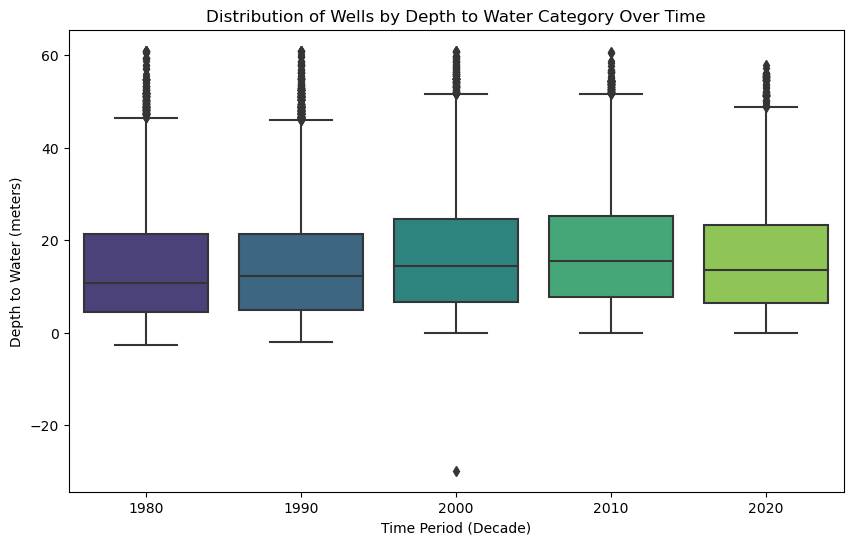

In [110]:
# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melt_computed, 
            x='NotADecade',
            y='DTW_meters', 
            # hue='Decade', 
            palette='viridis'
            )

plt.title('Distribution of Wells by Depth to Water Category Over Time')
plt.xlabel('Time Period (Decade)')
plt.ylabel('Depth to Water (meters)')
# plt.legend(title='DTW Category')
plt.xticks(rotation=0)
plt.show()


<Axes: xlabel='Decade', ylabel='DTW_meters'>

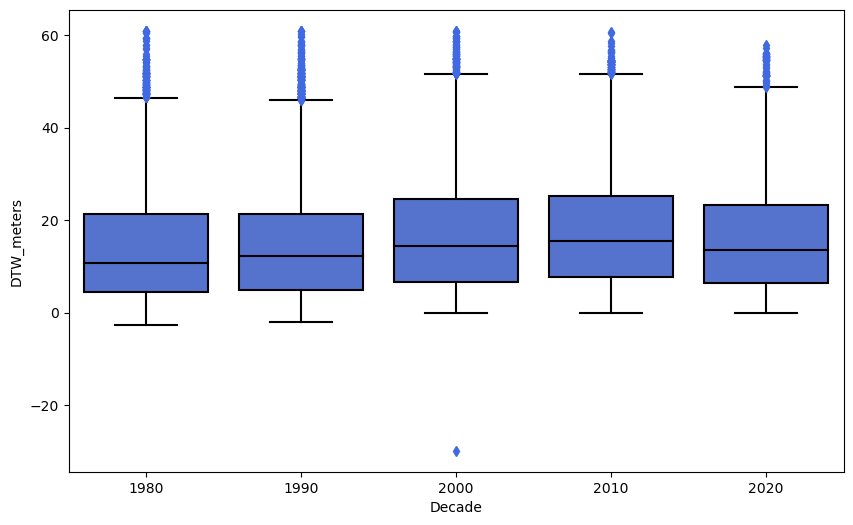

In [ ]:
# Define a single color for the boxes
box_color = "royalblue"  # Change to any color you like

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_melted, 
    x='Decade',
    y='DTW_meters',
    color=box_color,  # This sets all boxes to the same color
    boxprops=dict(edgecolor="black"),  # Box edges
    medianprops=dict(color="black"),  # Median line
    whiskerprops=dict(color="black"),  # Whiskers
    capprops=dict(color="black"),  # Caps
    flierprops=dict(markerfacecolor=box_color, markeredgecolor=box_color)  # Outliers
)

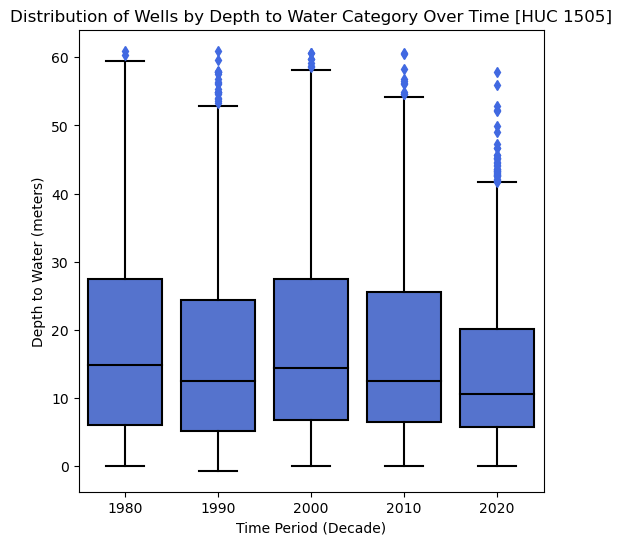

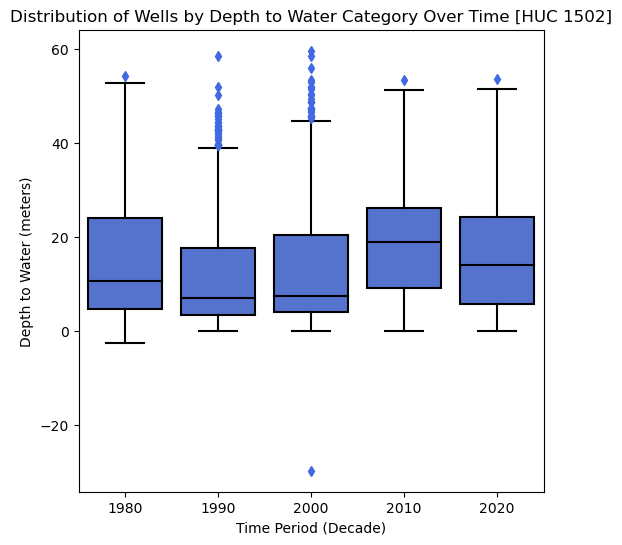

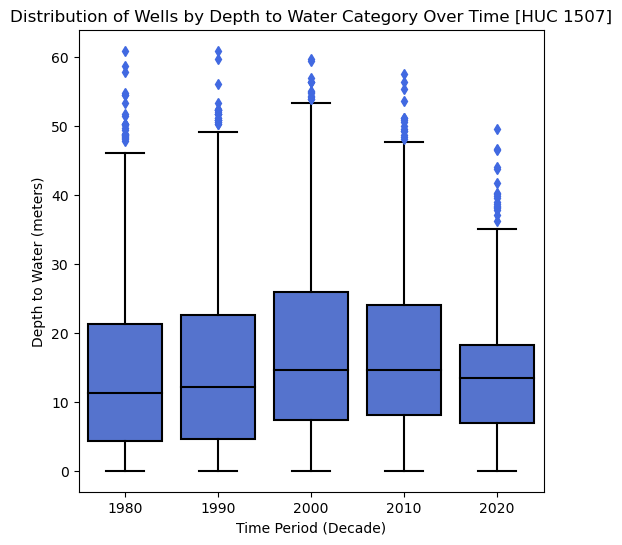

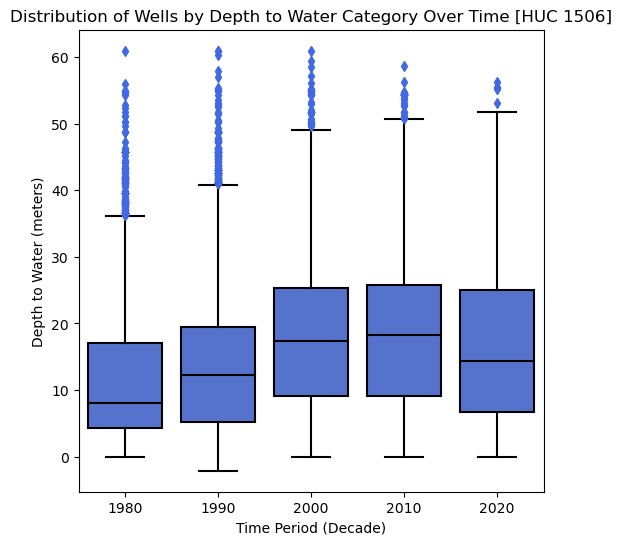

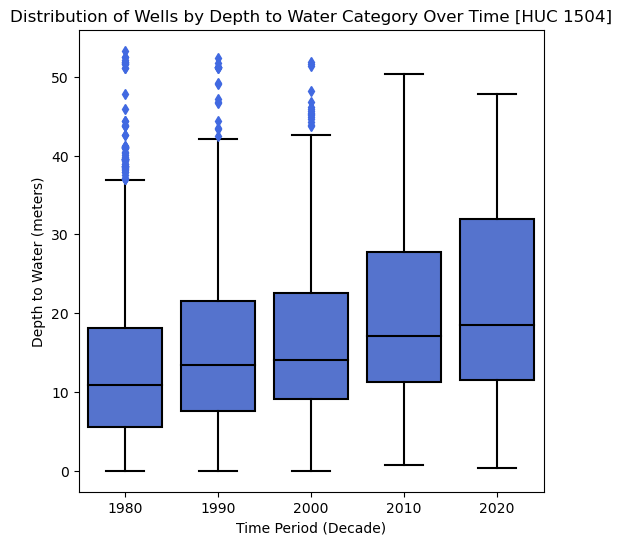

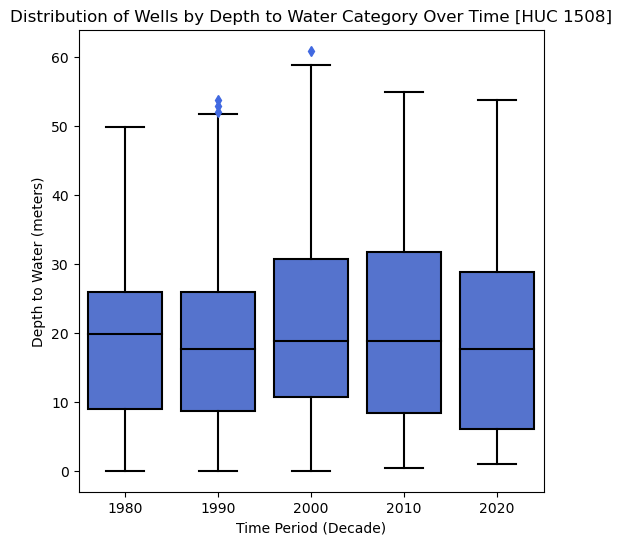

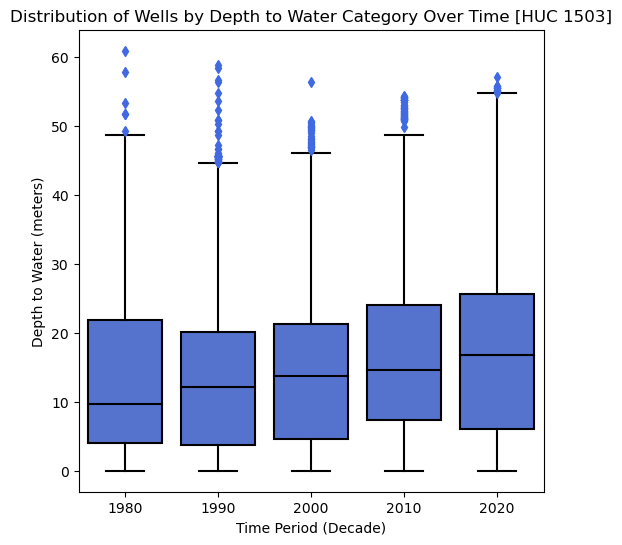

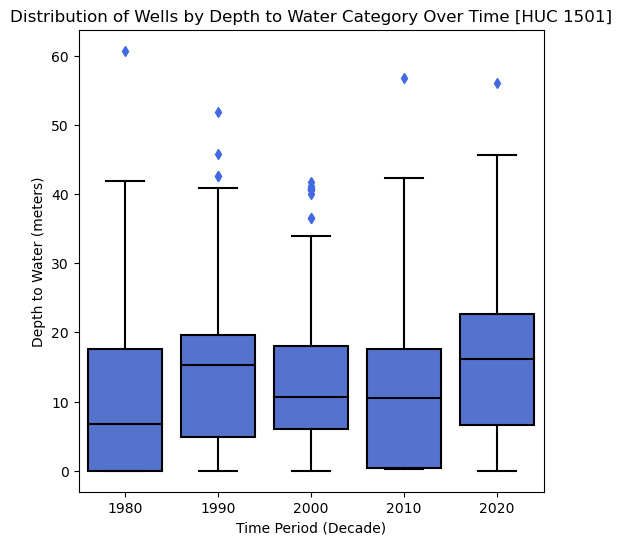

In [ ]:
listofhucs = df_melted[Naming_col+"_wb"].unique().tolist()

for bitch in listofhucs:
    # Subset data for the huc
    subset = df_melted[df_melted[Naming_col+"_wb"] == bitch]
    
    # Define a single color for the boxes
    box_color = "royalblue"  # Change to any color you like

    # Plot
    plt.figure(figsize=(6, 6))
    sns.boxplot(
        data=subset, 
        x='Decade',
        y='DTW_meters',
        color=box_color,  # This sets all boxes to the same color
        boxprops=dict(edgecolor="black"),  # Box edges
        medianprops=dict(color="black"),  # Median line
        whiskerprops=dict(color="black"),  # Whiskers
        capprops=dict(color="black"),  # Caps
        flierprops=dict(markerfacecolor=box_color, markeredgecolor=box_color)  # Outliers
    )

    plt.title('Distribution of Wells by Depth to Water Category Over Time [HUC '+bitch+']')
    plt.xlabel('Time Period (Decade)')
    plt.ylabel('Depth to Water (meters)')
    plt.xticks(rotation=0)
    plt.show()


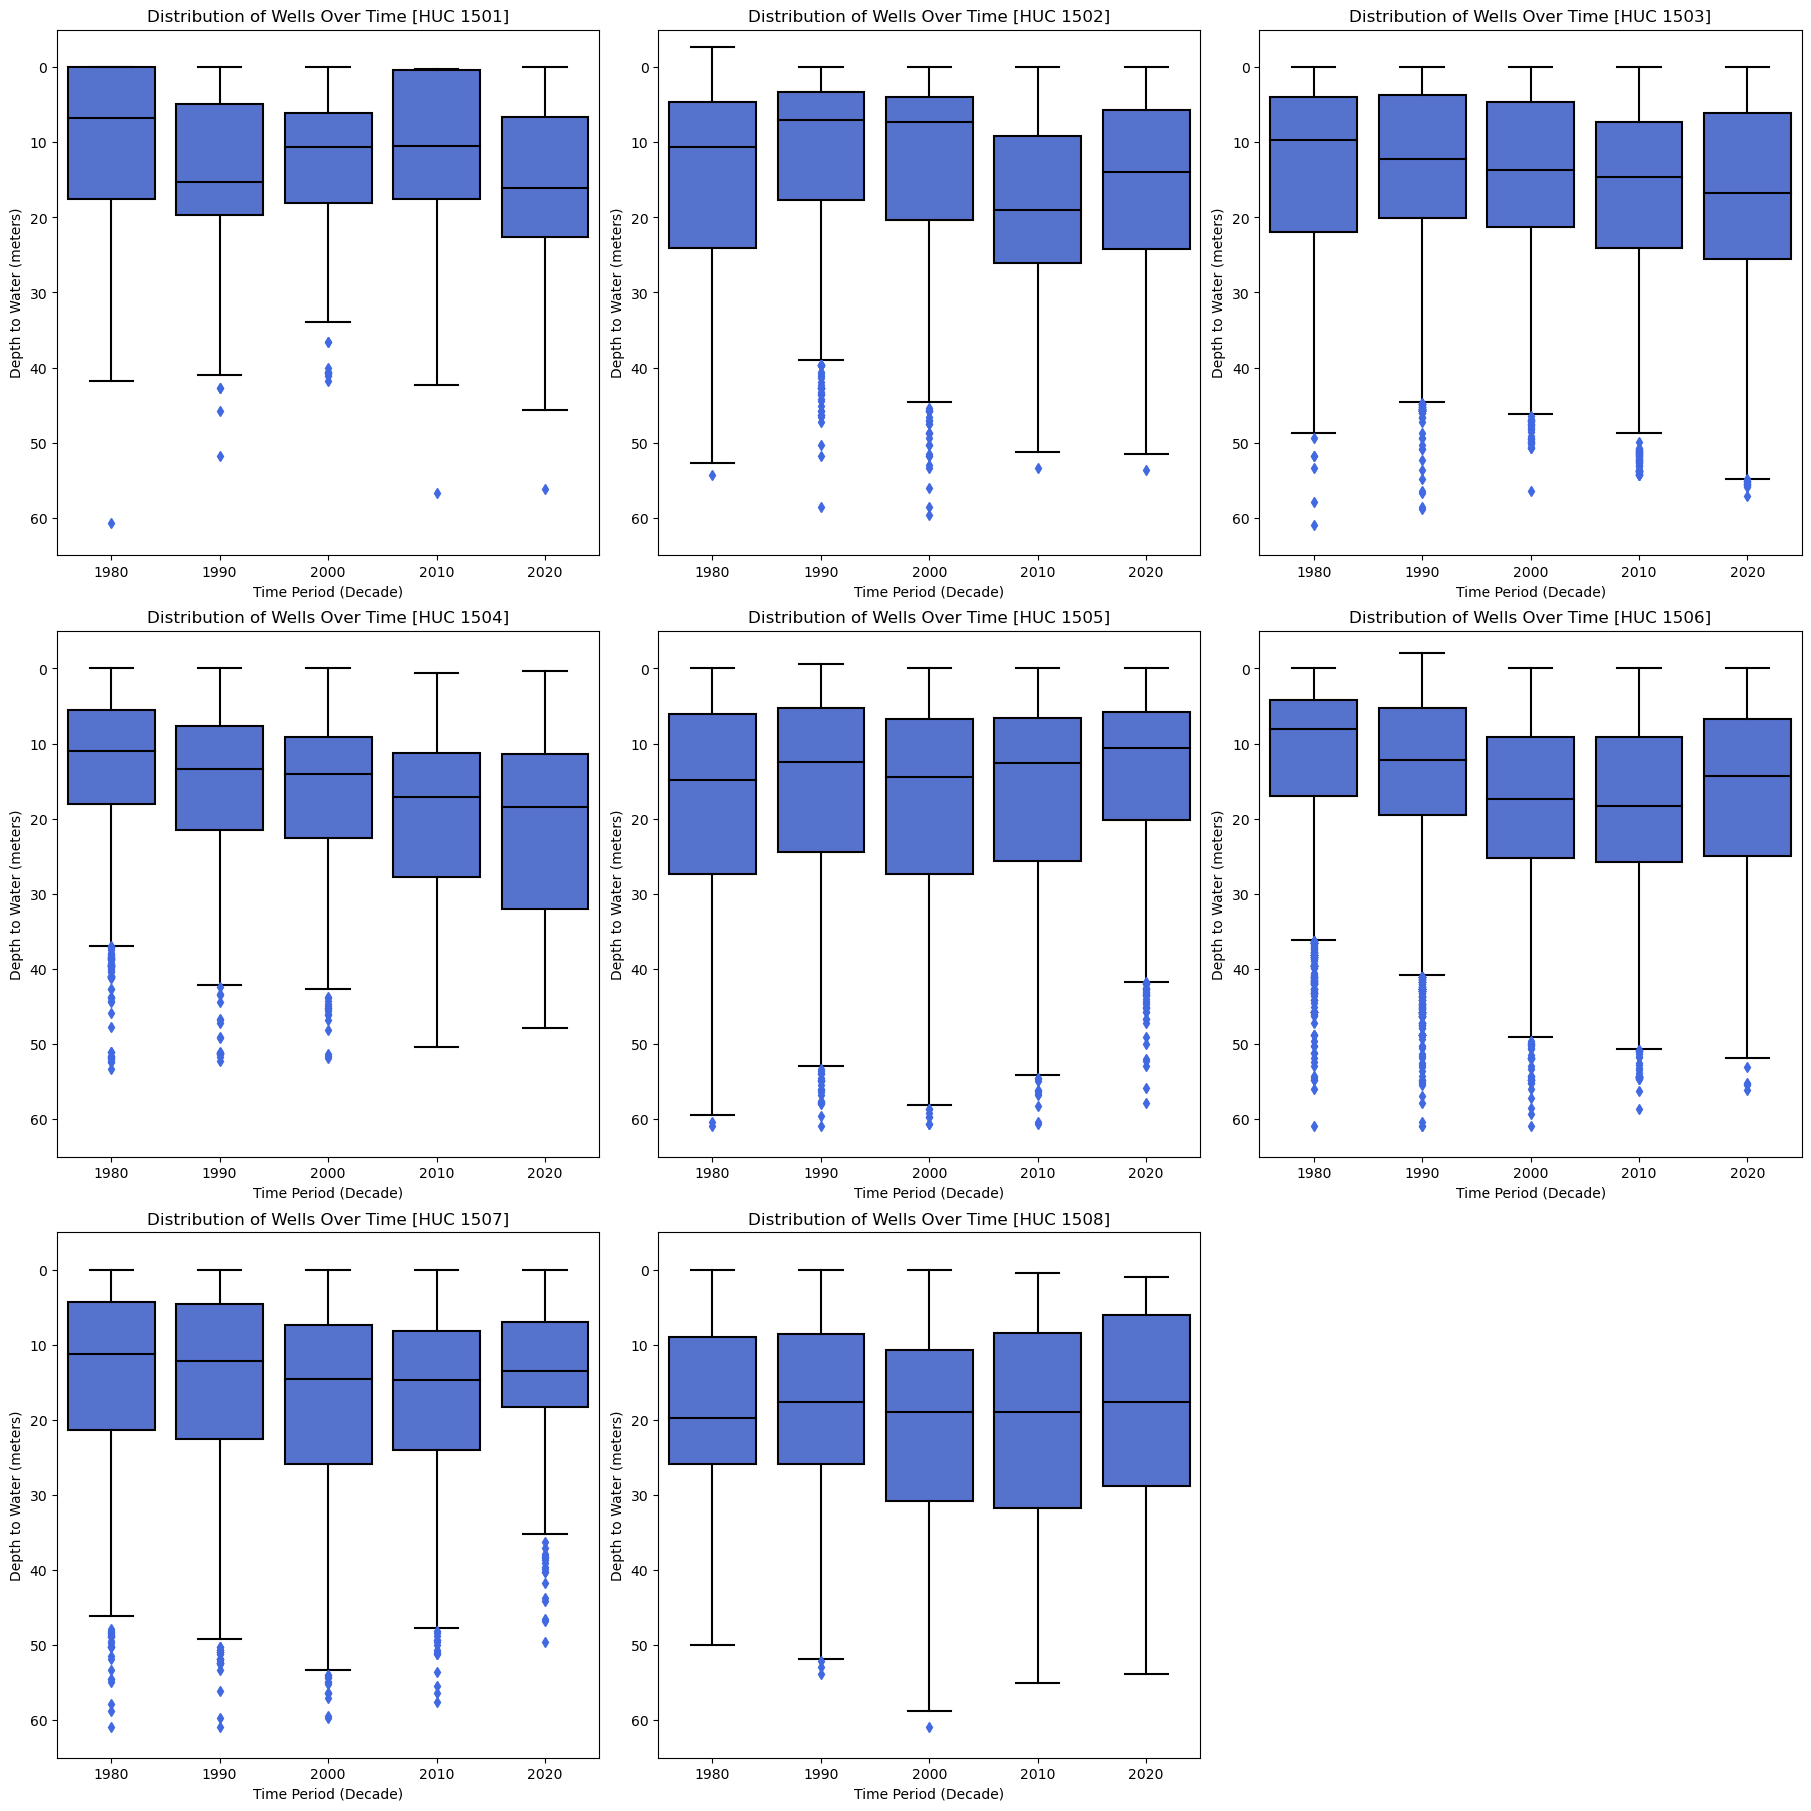

In [51]:
listofhucs = df_melted[Naming_col+"_wb"].unique().tolist()
num_hucs = len(listofhucs)

# Determine grid size
cols = math.ceil(math.sqrt(num_hucs))  # Try to make a roughly square grid
rows = math.ceil(num_hucs / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6), constrained_layout=True)

# Flatten axes if there's more than one row
if rows > 1 or cols > 1:
    axes = axes.flatten()
else:
    axes = [axes]  # Ensure it's iterable

# Define a single color for the boxes
box_color = "royalblue"

for i, bitch in enumerate(listofhucs):
    subset = df_melted[df_melted[Naming_col+"_wb"] == bitch]

    sns.boxplot(
        data=subset, 
        x='Decade',
        y='DTW_meters',
        color=box_color,
        ax=axes[i],  # Assign each plot to a subplot
        boxprops=dict(edgecolor="black"),
        medianprops=dict(color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        flierprops=dict(markerfacecolor=box_color, markeredgecolor=box_color)
    )

    axes[i].set_title(f'Distribution of Wells Over Time [HUC {bitch}]')
    axes[i].set_xlabel('Time Period (Decade)')
    axes[i].set_ylabel('Depth to Water (meters)')
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].set_ylim(65, -5)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


These box plots aren't particularly informative but thought they were interesting

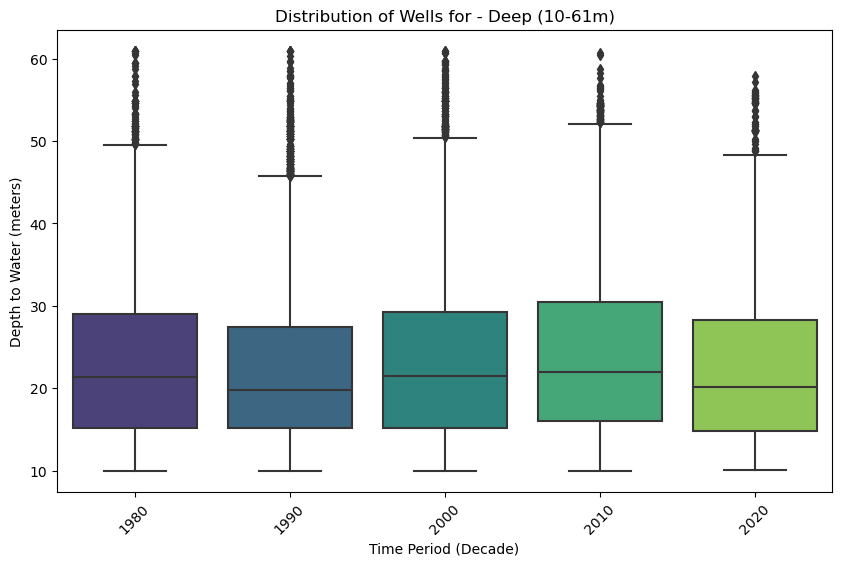

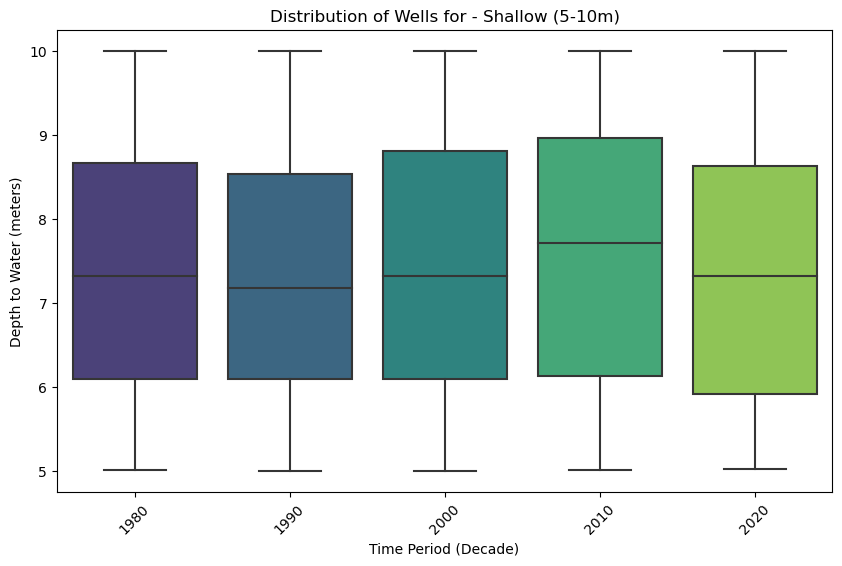

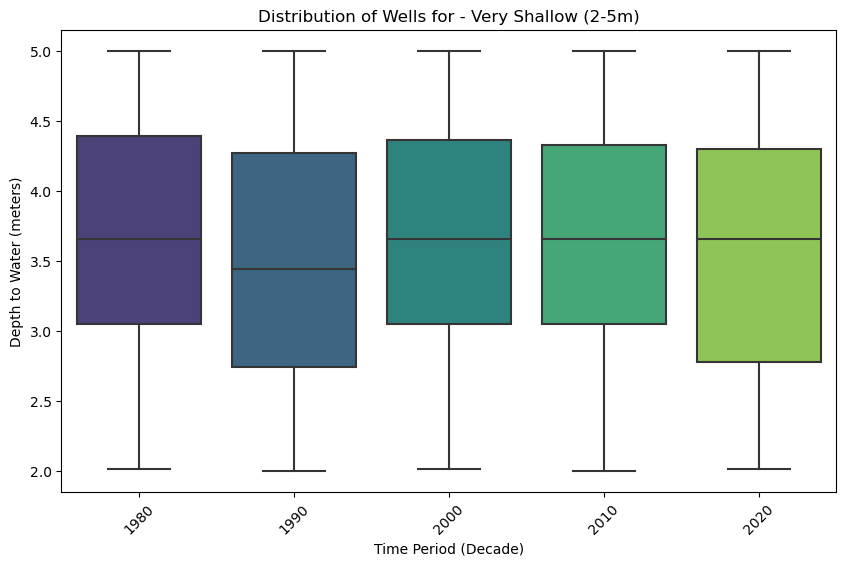

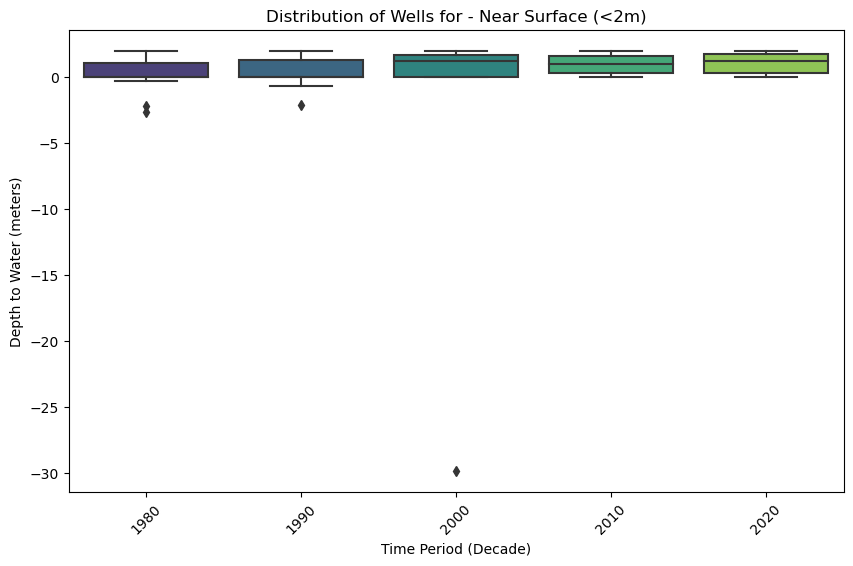

In [53]:
# Get unique DTW categories
dtw_categories = df_melted['DTW_Category'].unique()

# Loop through each DTW category and create a box plot
for category in dtw_categories:
    plt.figure(figsize=(10, 6))
    
    # Subset data for the current category
    subset = df_melted[df_melted['DTW_Category'] == category]

    # Create the box plot
    sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')

    # Titles and labels
    plt.title(f'Distribution of Wells for - {category}')
    plt.xlabel('Time Period (Decade)')
    plt.ylabel('Depth to Water (meters)')
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

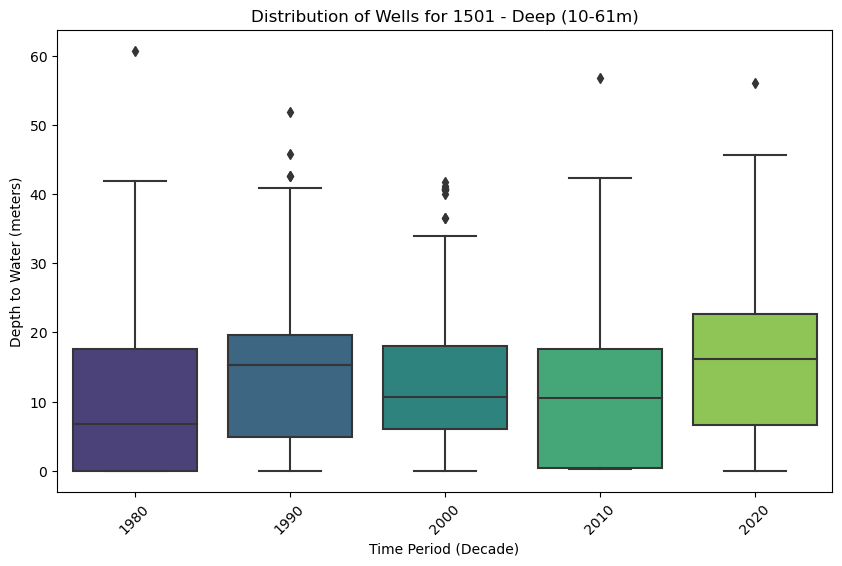

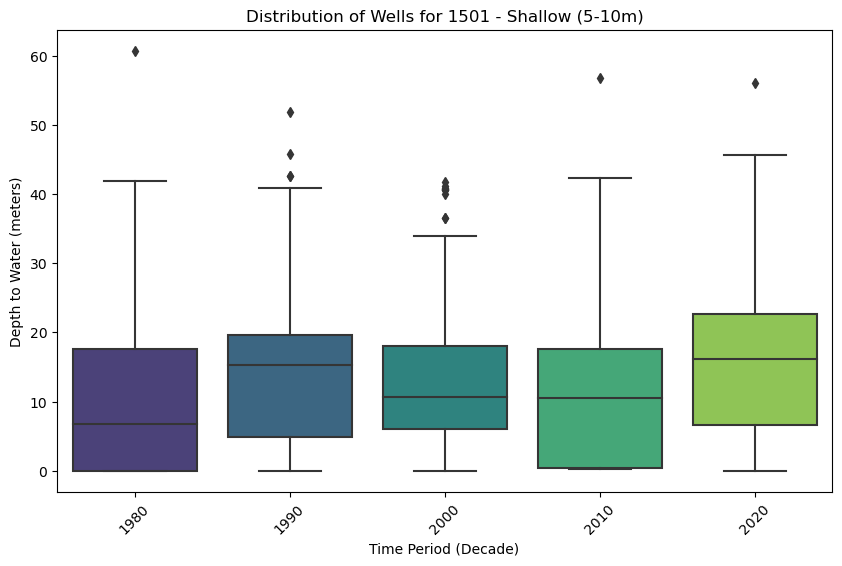

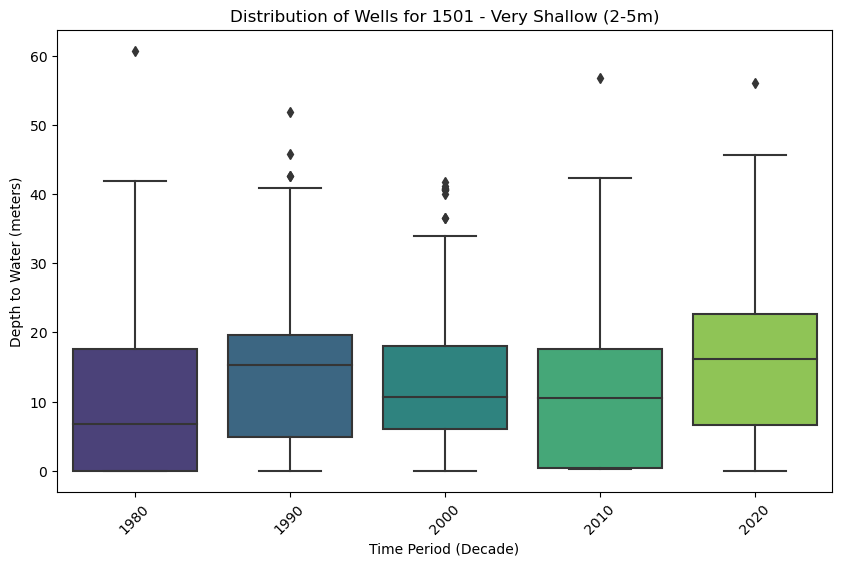

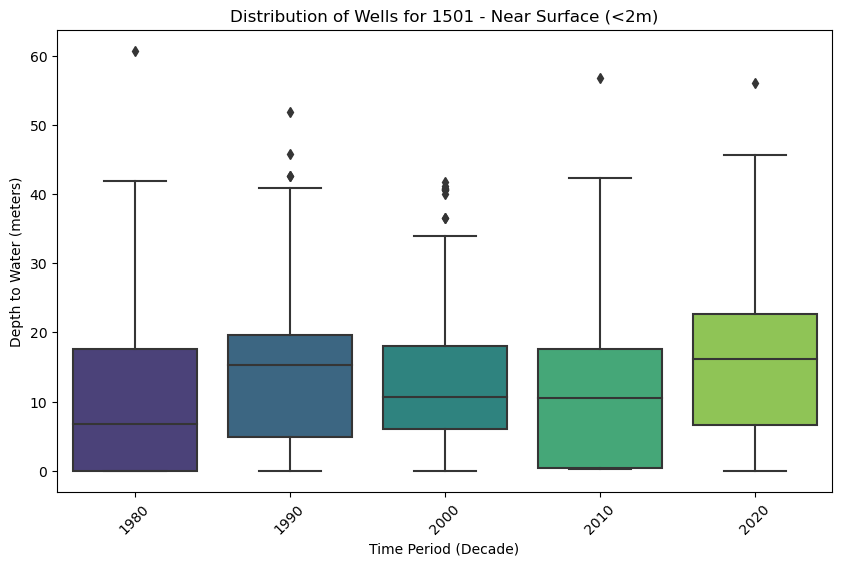

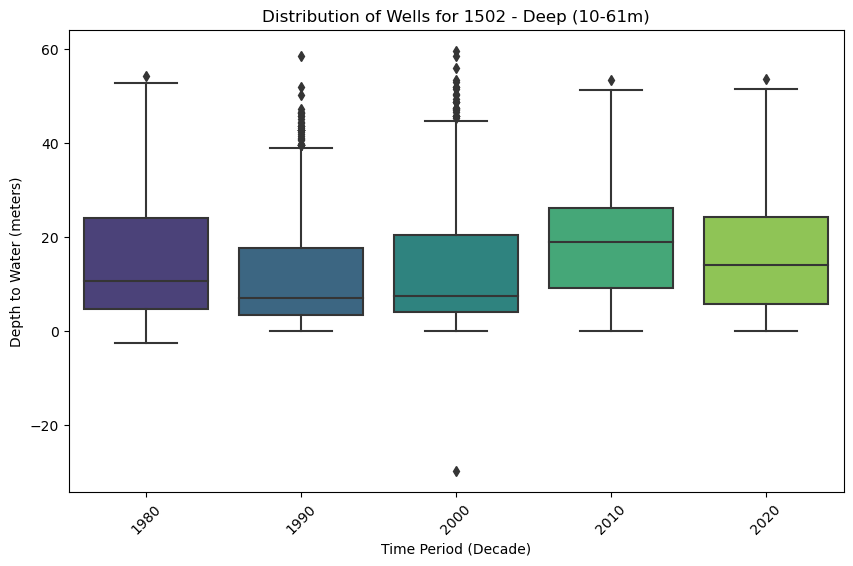

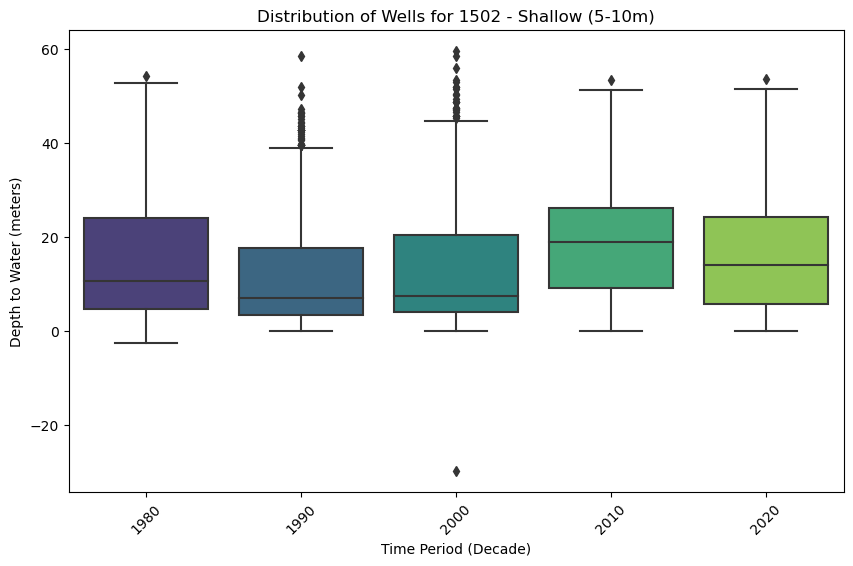

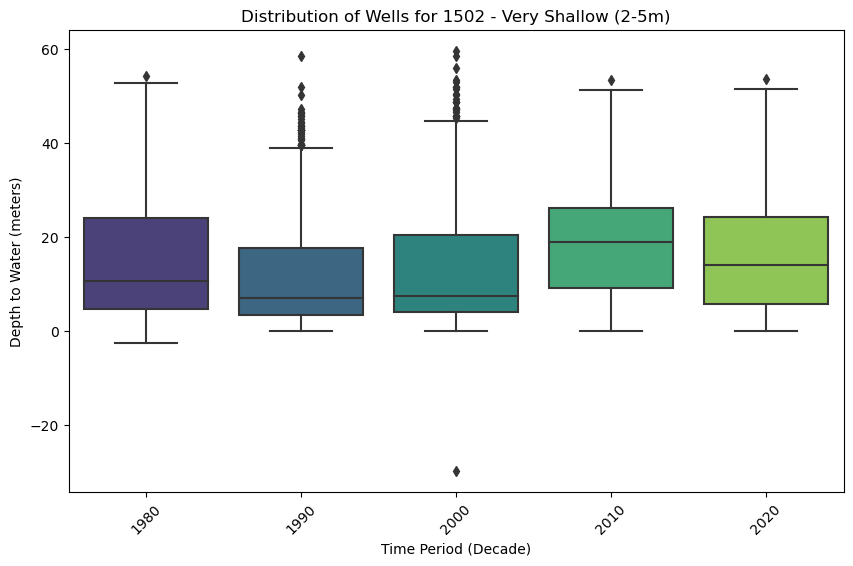

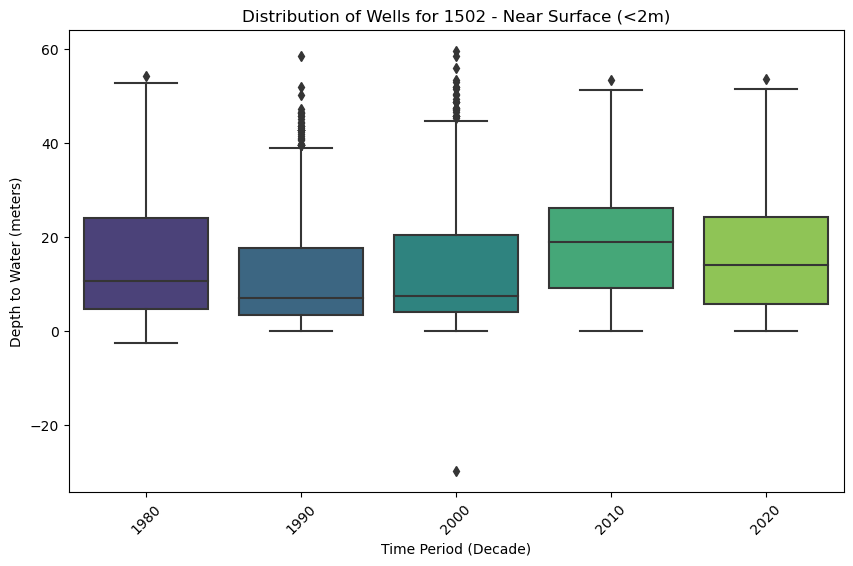

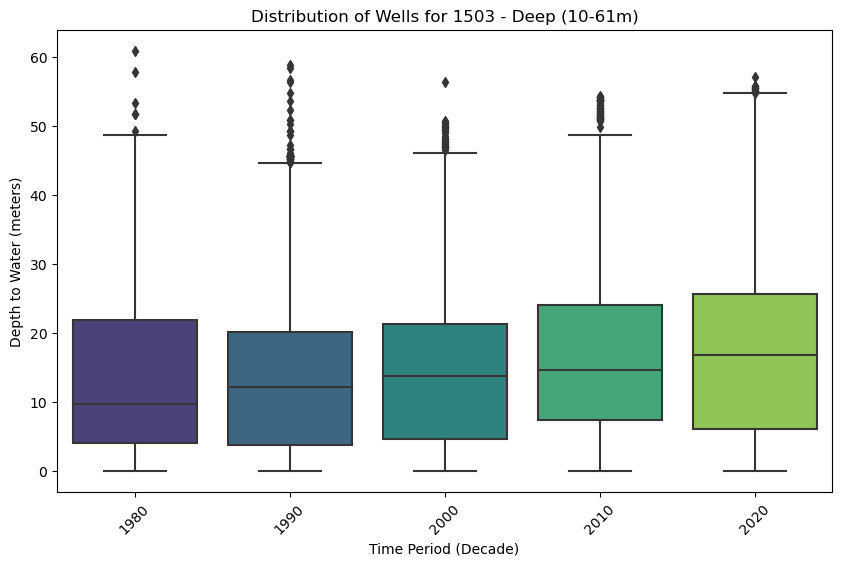

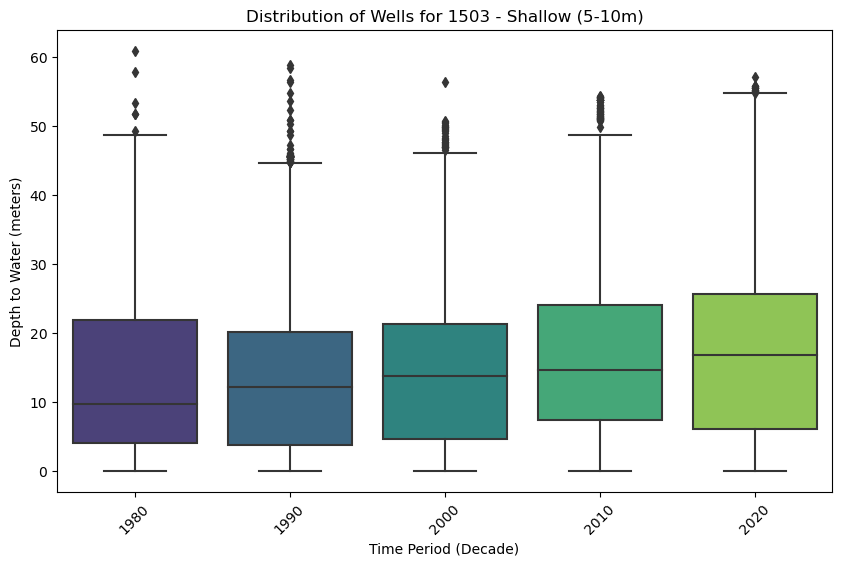

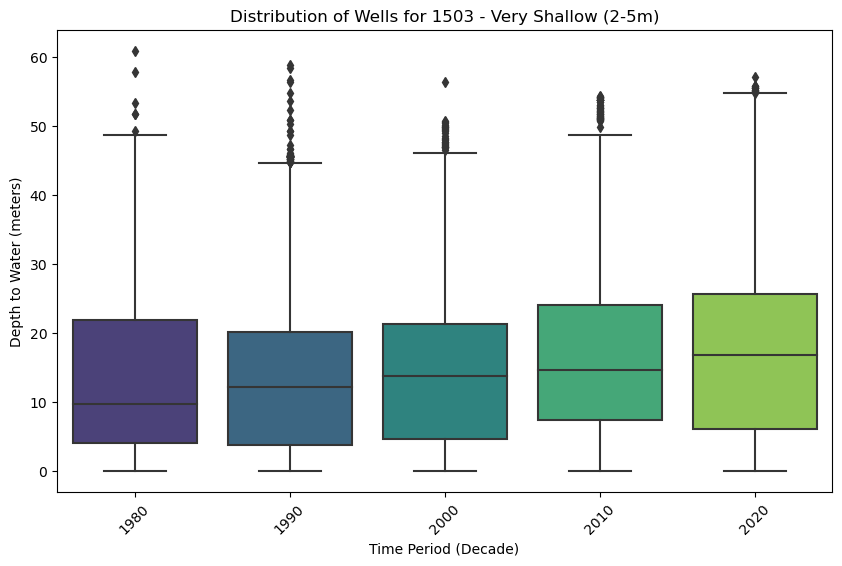

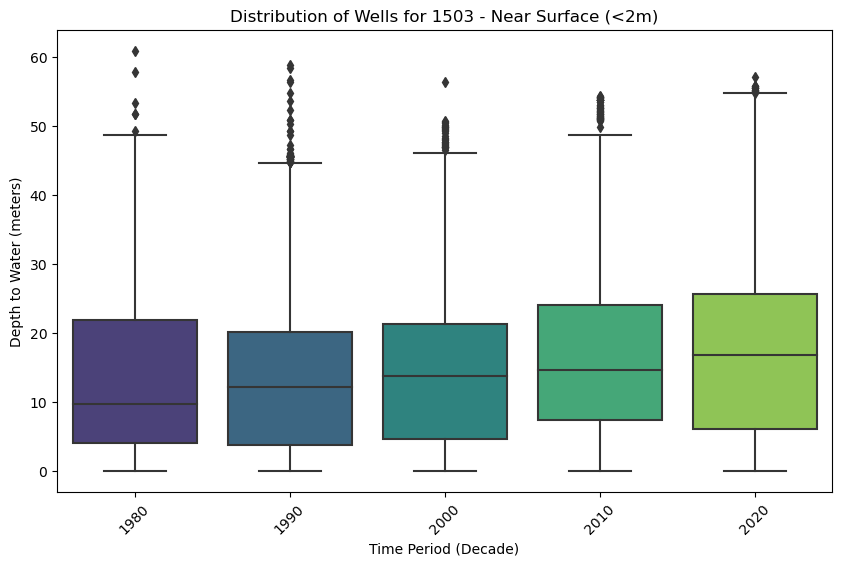

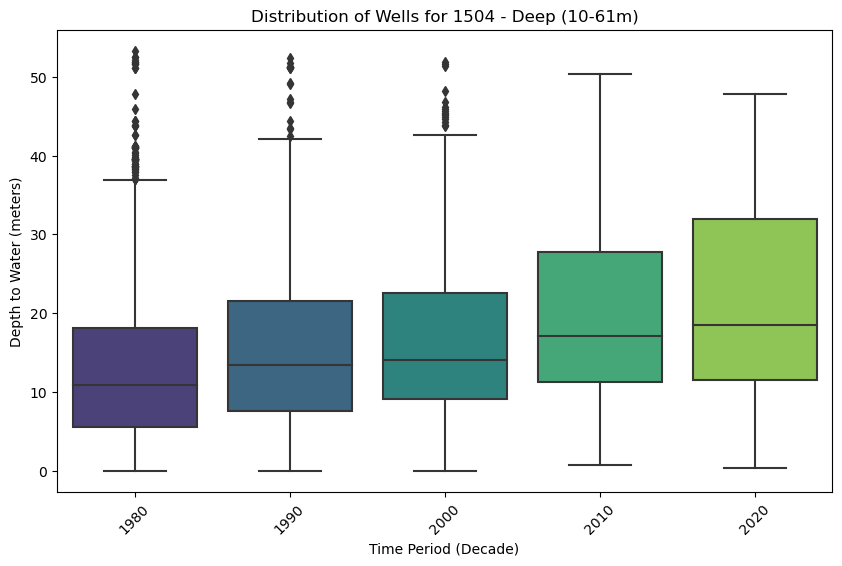

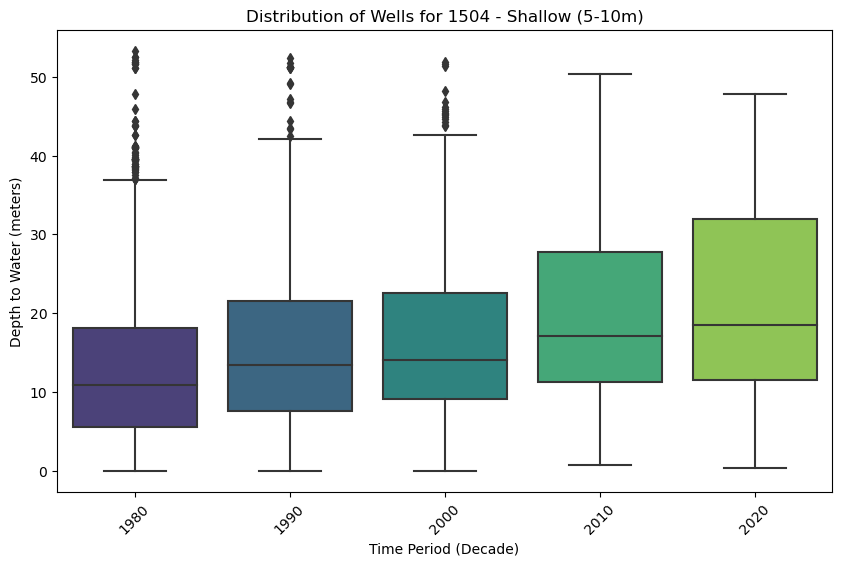

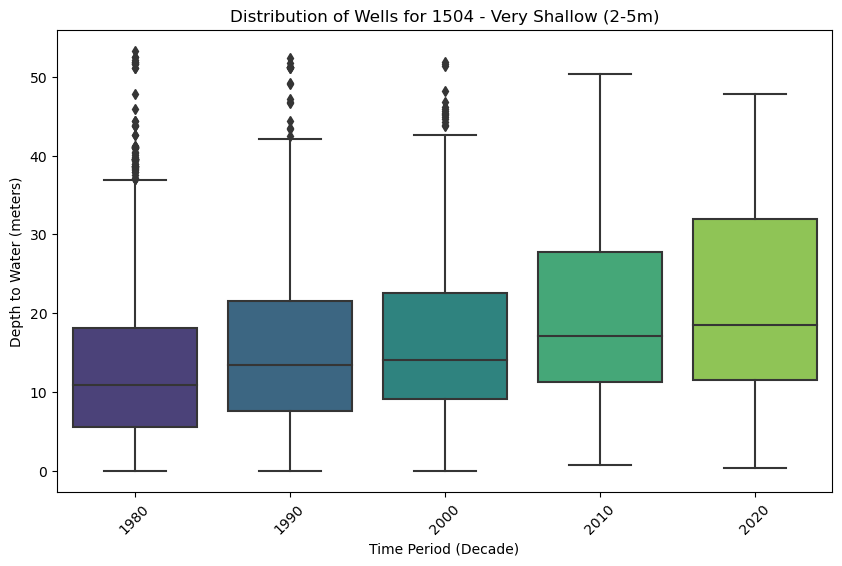

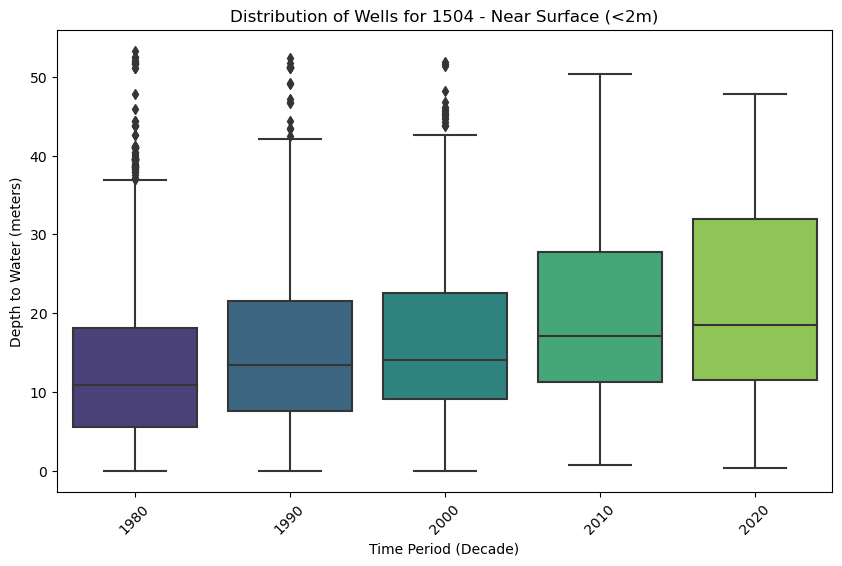

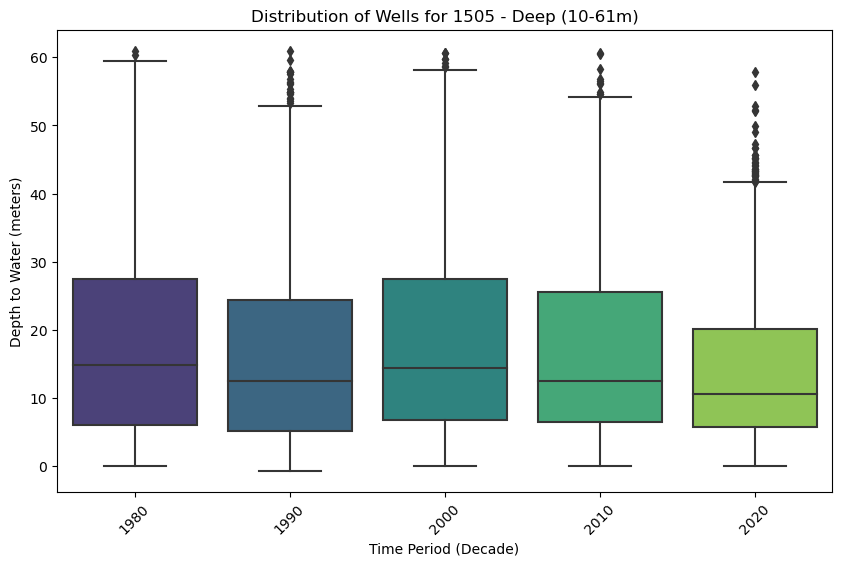

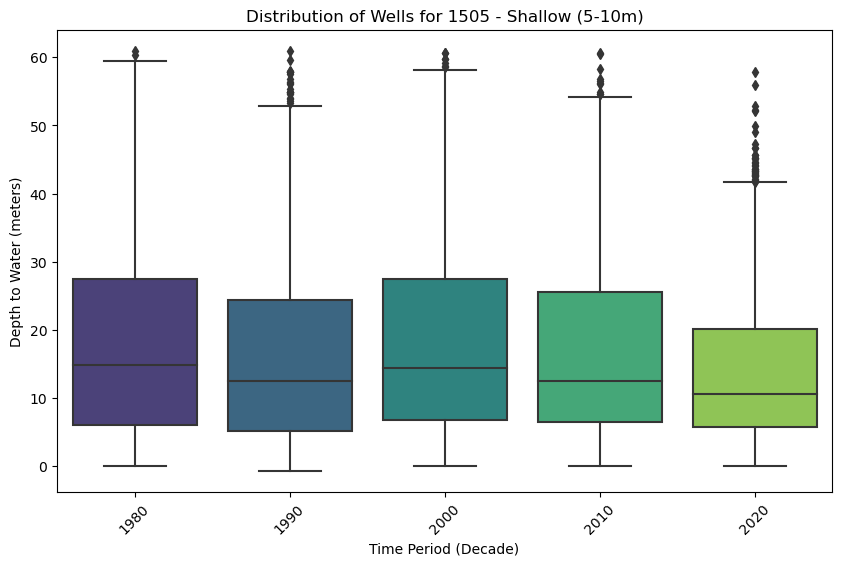

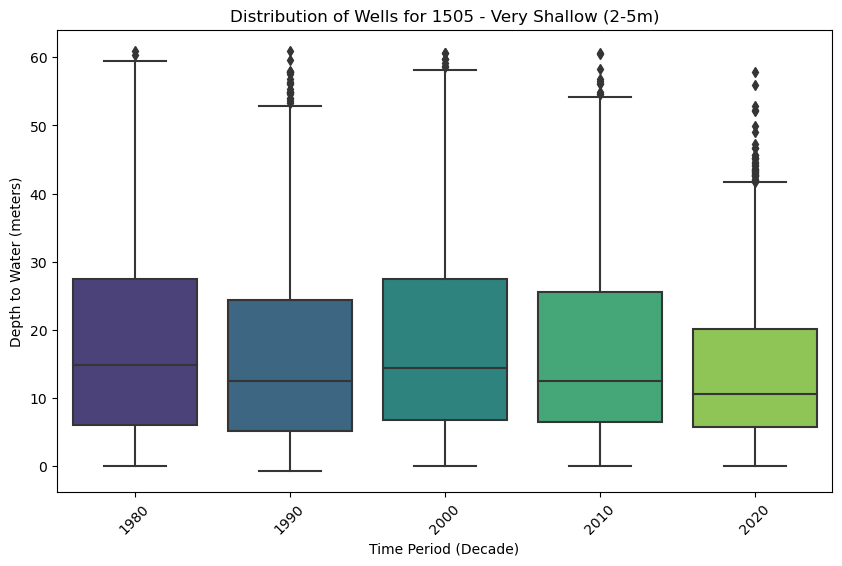

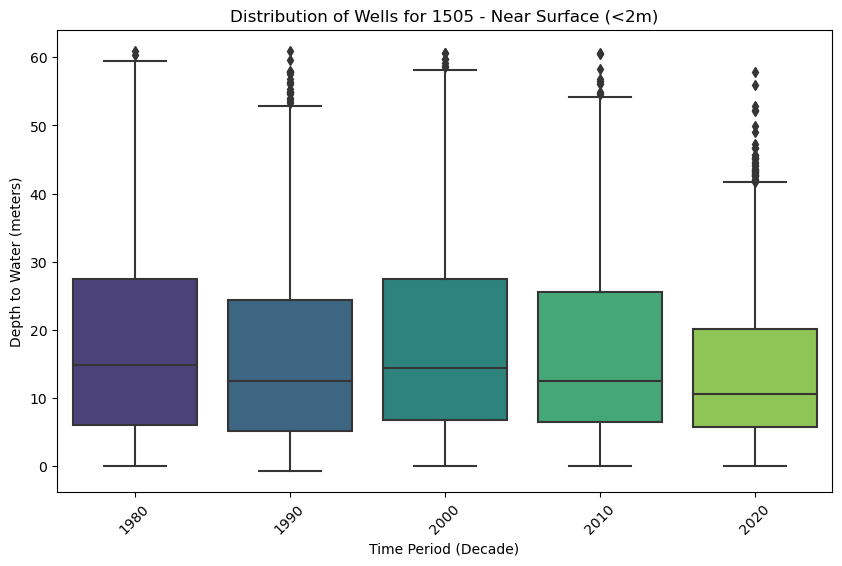

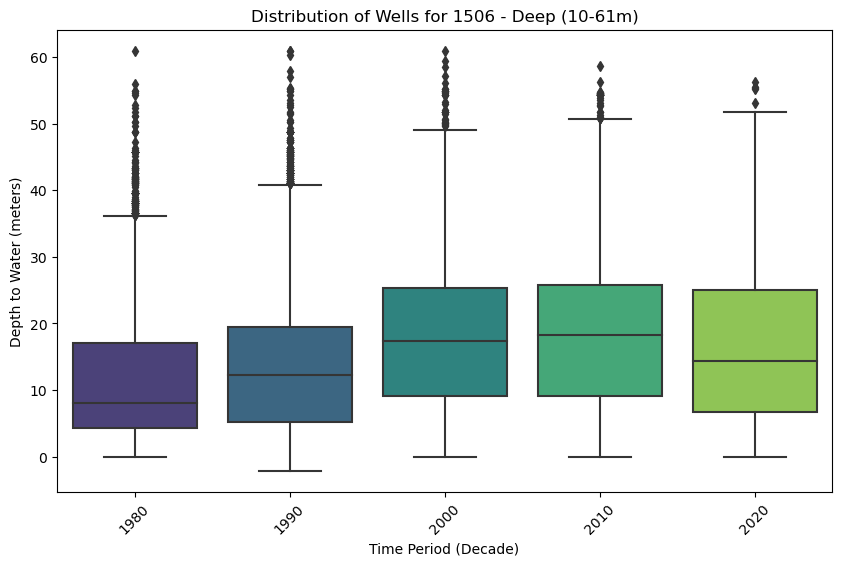

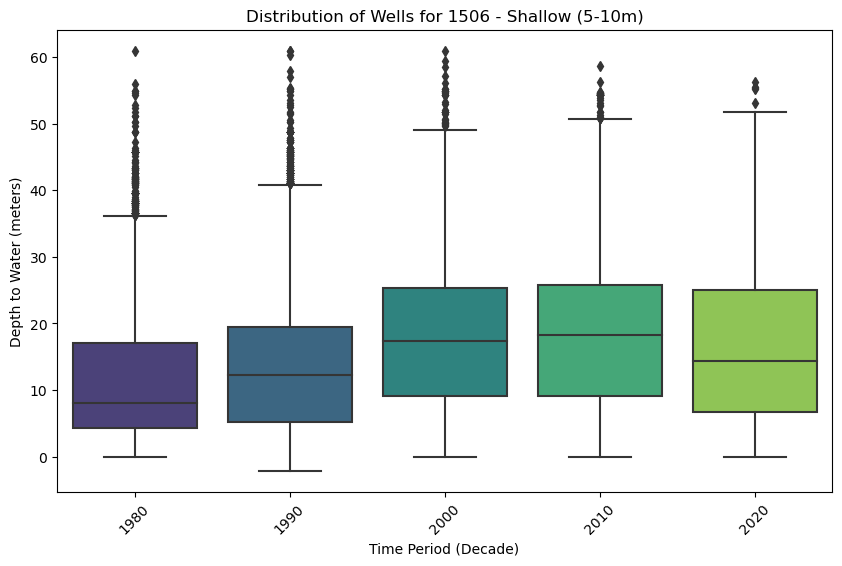

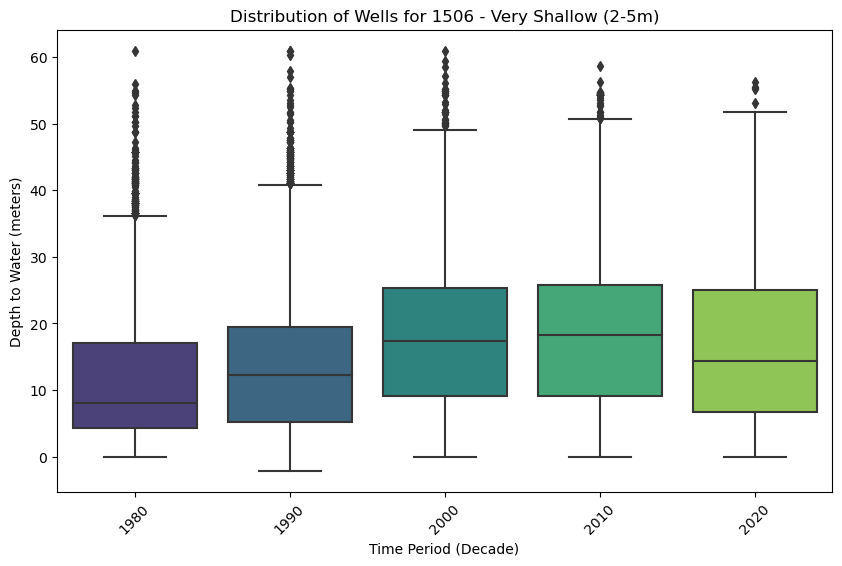

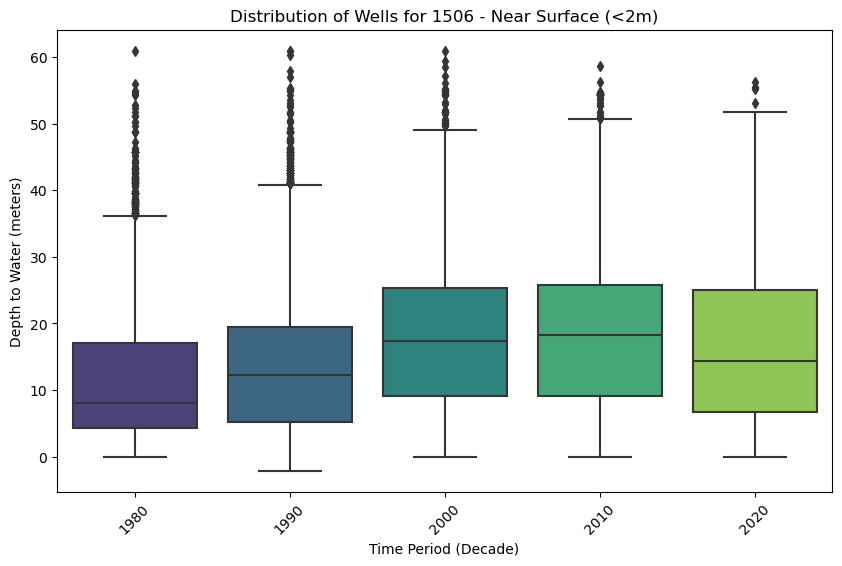

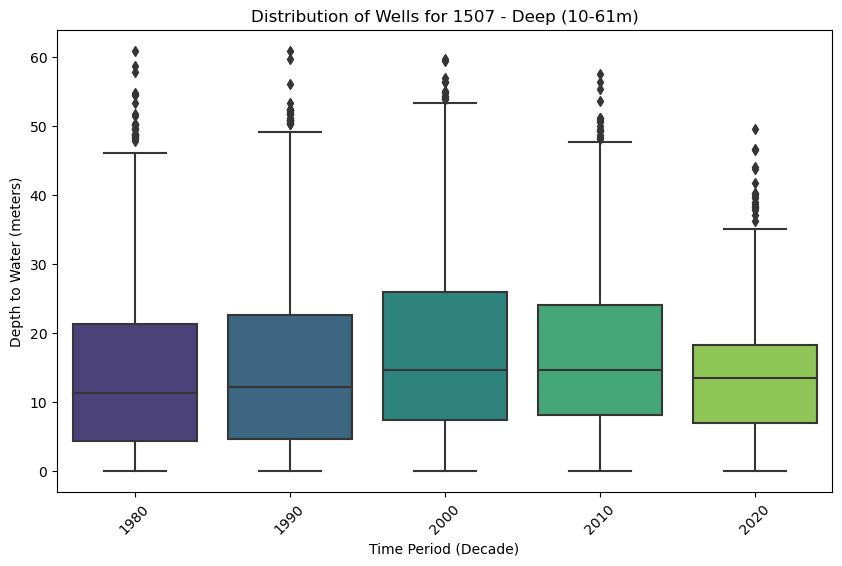

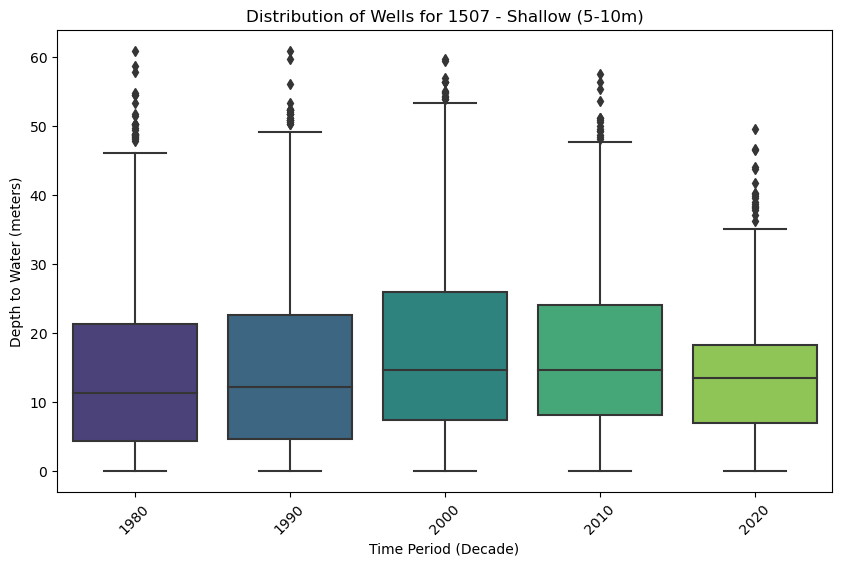

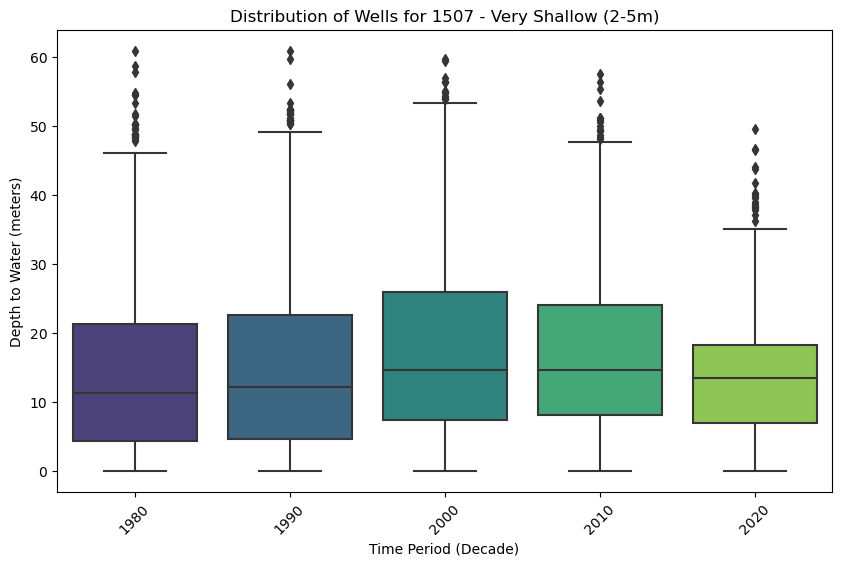

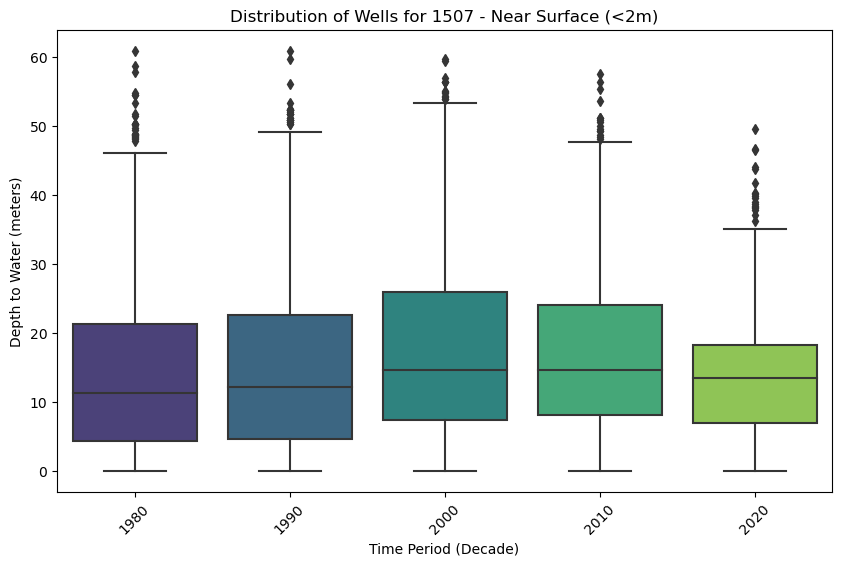

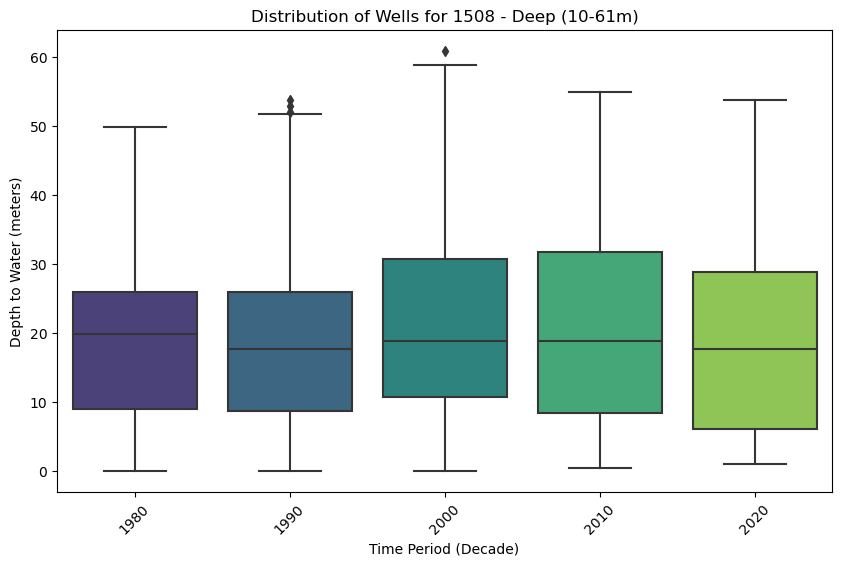

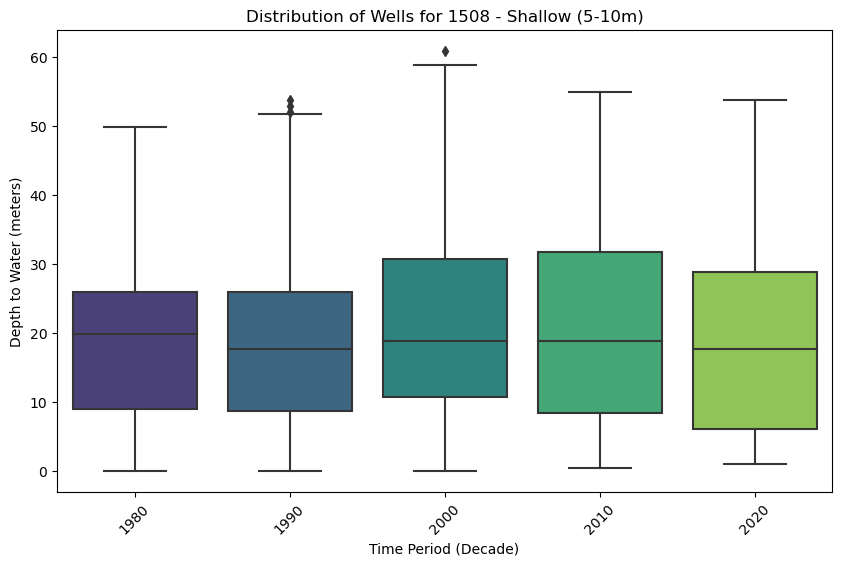

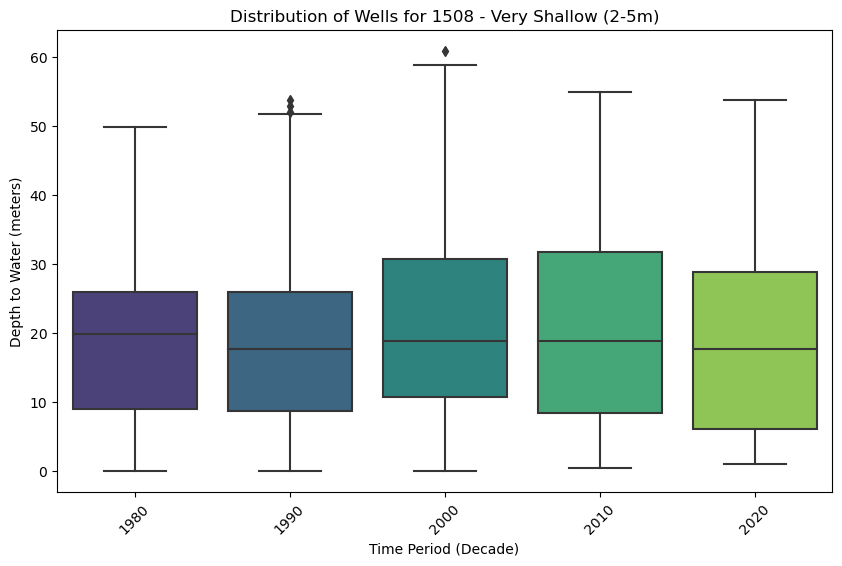

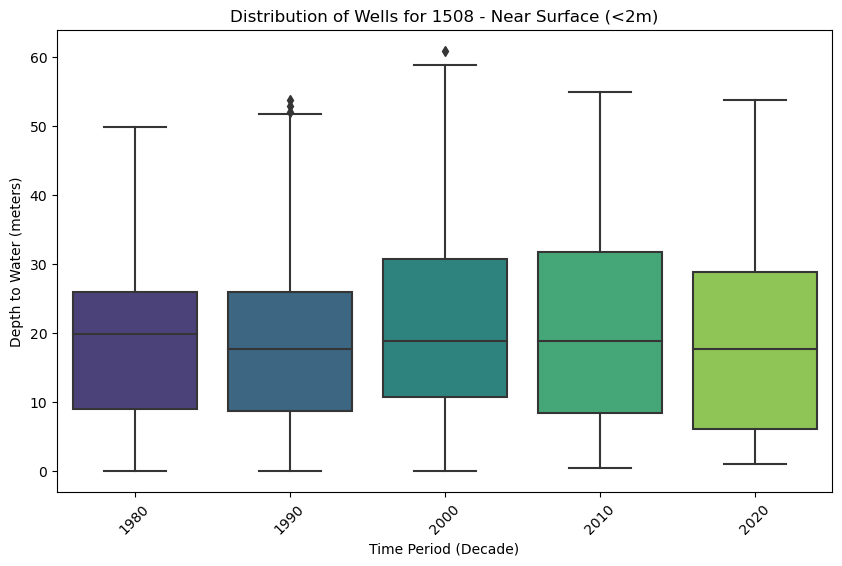

In [55]:
# Get unique DTW categories
dtw_categories = df_melted['DTW_Category'].unique()

# Loop through each DTW category and create a box plot
for bitch in listofhucs:
    subset_hucs = df_melted[df_melted[Naming_col+"_wb"]== bitch]
    for category in dtw_categories:
        plt.figure(figsize=(10, 6))
        
        # Subset data for the current category
        subset = subset_hucs[subset_hucs['DTW_Category'] == category]

        # Create the box plot
        sns.boxplot(data=subset_hucs, x='Decade', y='DTW_meters', palette='viridis')

        # Titles and labels
        plt.title(f'Distribution of Wells for {bitch} - {category}')
        plt.xlabel('Time Period (Decade)')
        plt.ylabel('Depth to Water (meters)')
        plt.xticks(rotation=45)

        # Show the plot
        plt.show()

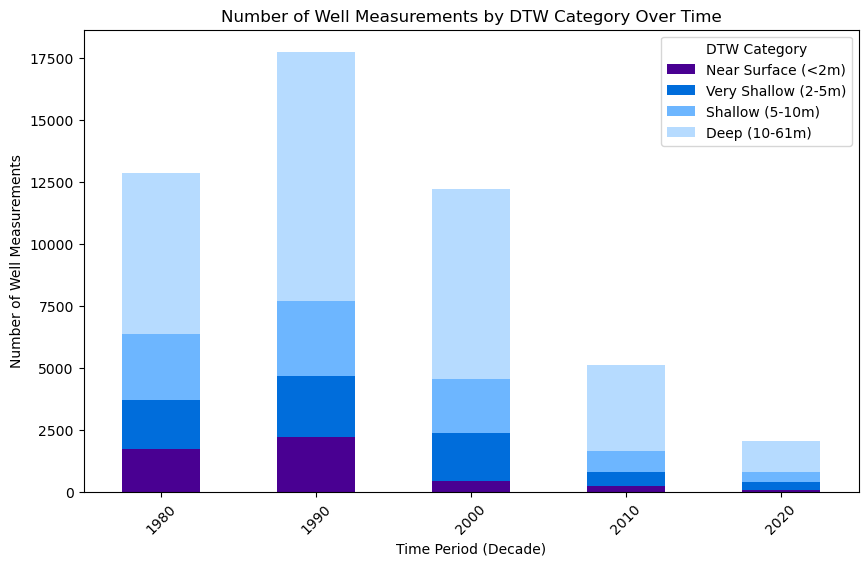

In [63]:
# Pivot the data to get each DTW category as a separate column for stacking
summary_pivot = summary_df.pivot(index='Decade', columns='DTW_Category', values='Well Count').fillna(0)

# Define the desired order for DTW categories
category_order = ['Near Surface (<2m)', 'Very Shallow (2-5m)', 'Shallow (5-10m)', 'Deep (10-61m)']

# Reorder the columns in summary_pivot
summary_pivot = summary_pivot[category_order]

# Define colors
colors = {
    'Near Surface (<2m)': cblind[5],
    'Very Shallow (2-5m)': cblind[6],
    'Shallow (5-10m)': cblind[8],
    'Deep (10-61m)': cblind[9]
}

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
summary_pivot.plot(kind='bar', stacked=True, color=[colors[c] for c in summary_pivot.columns], ax=ax)

# Labels and title
plt.xlabel('Time Period (Decade)')
plt.ylabel('Number of Well Measurements')
plt.title('Number of Well Measurements by DTW Category Over Time')
plt.legend(title='DTW Category')
plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


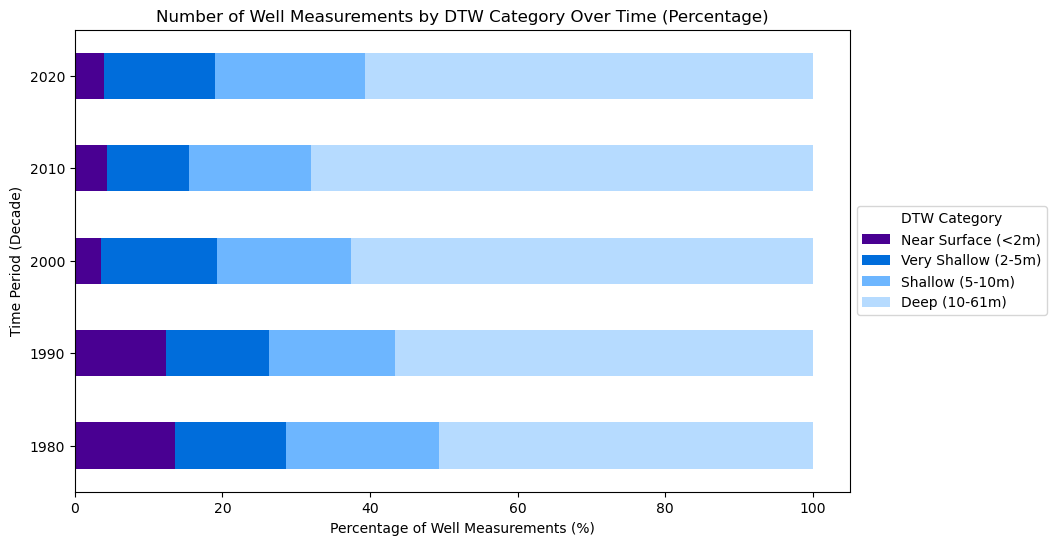

In [61]:
# Normalize data to get percentages
summary_pivot_percent = summary_pivot.div(summary_pivot.sum(axis=1), axis=0) * 100

# Plot stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
summary_pivot_percent.plot(
    kind='barh',  # Horizontal bar chart
    stacked=True, 
    color=[colors[c] for c in summary_pivot.columns], 
    ax=ax
)

# Labels and title
plt.xlabel('Percentage of Well Measurements (%)')
plt.ylabel('Time Period (Decade)')
plt.title('Number of Well Measurements by DTW Category Over Time (Percentage)')
plt.legend(title='DTW Category', loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside for clarity
plt.xticks(rotation=0)  # Keep x-axis labels horizontal

plt.show()


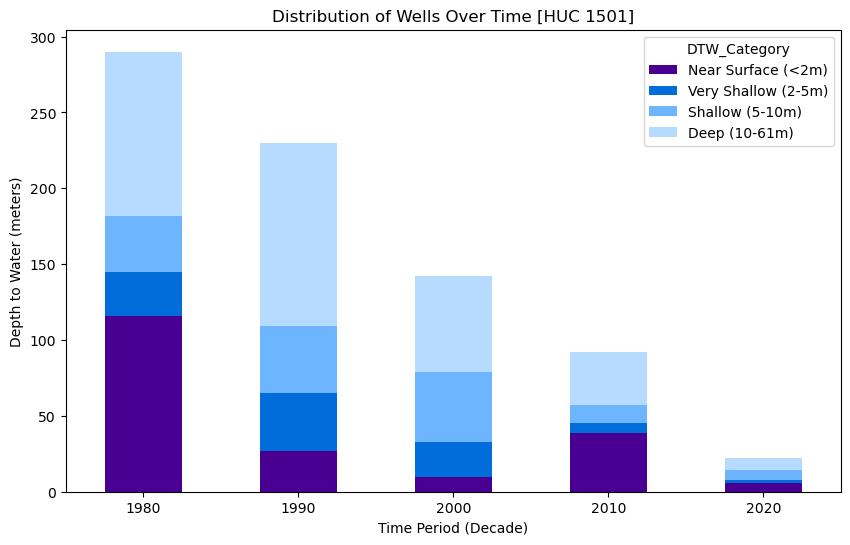

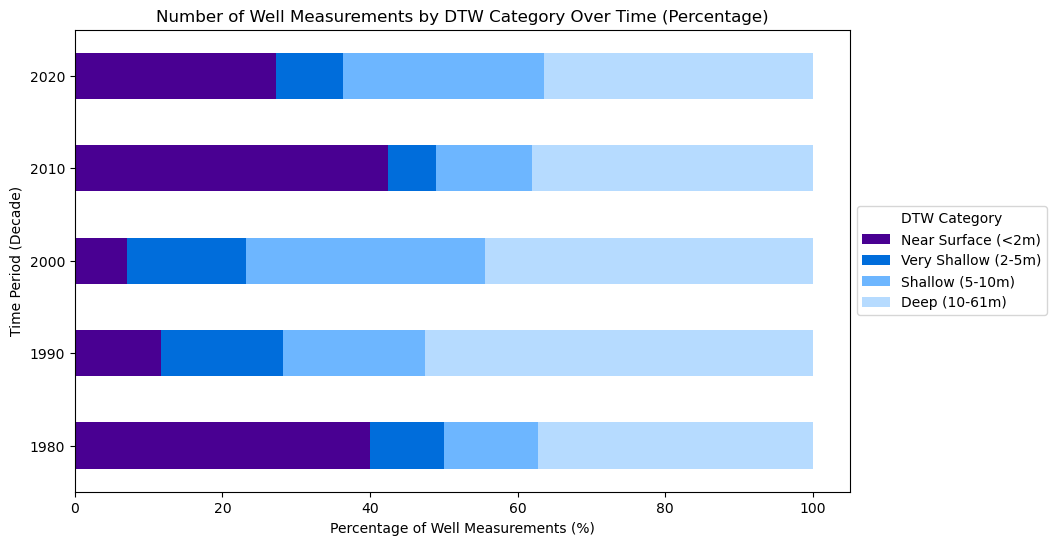

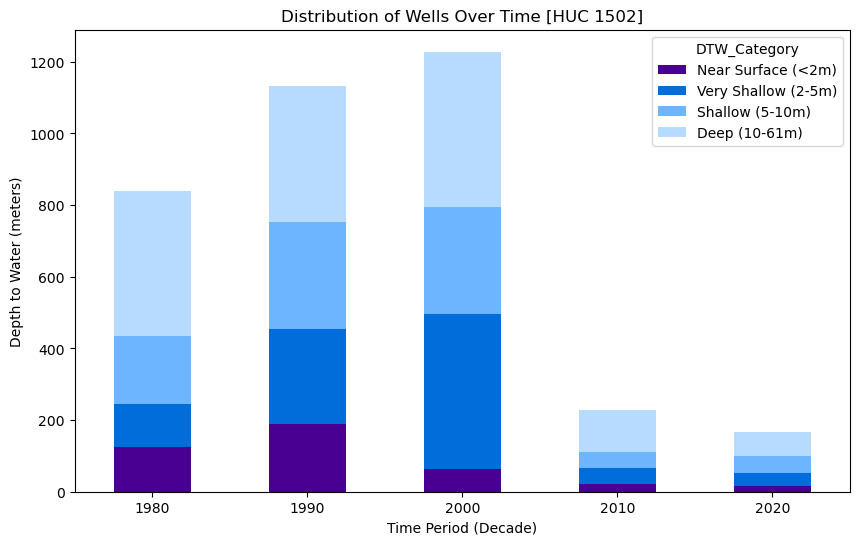

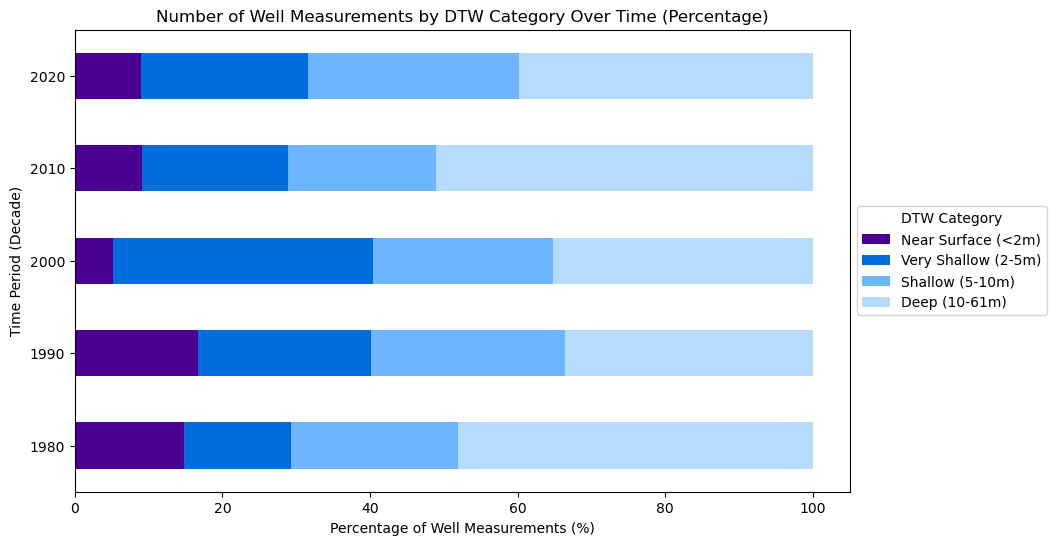

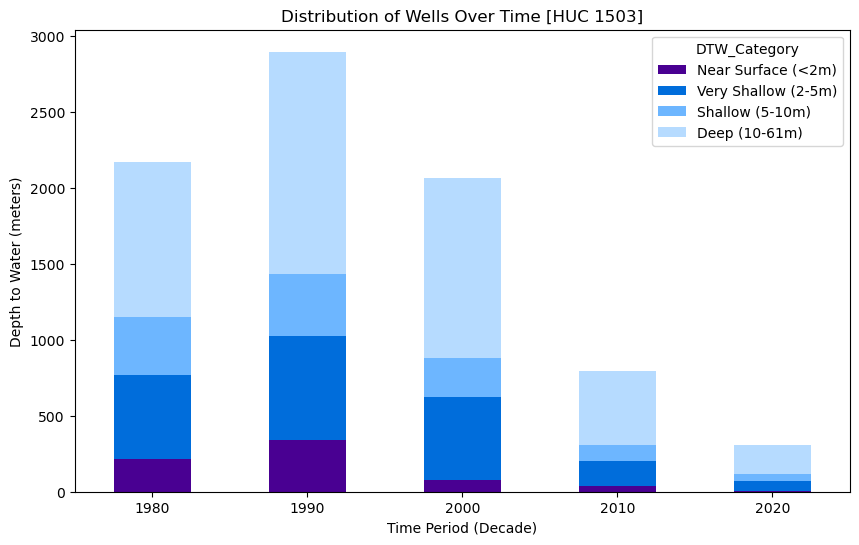

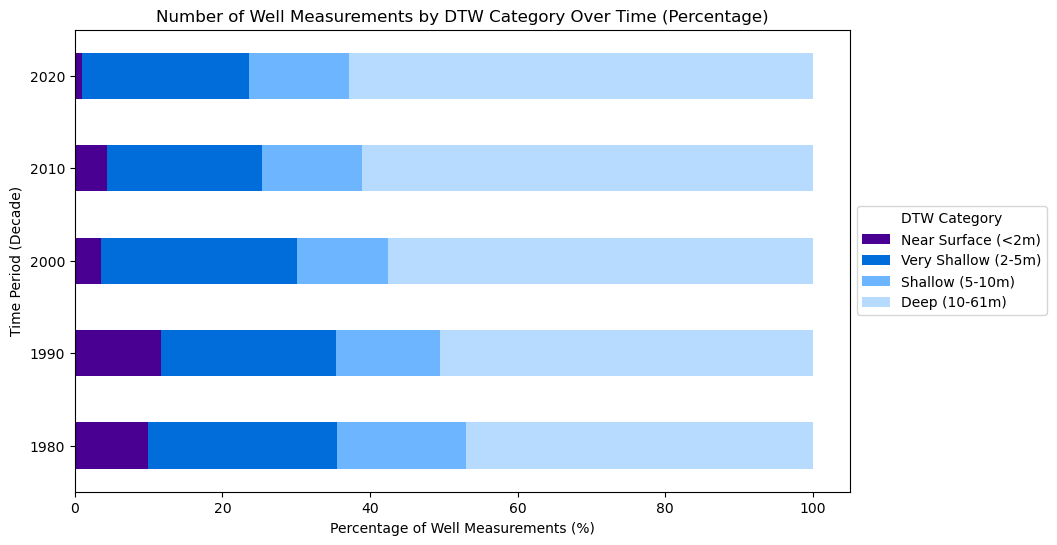

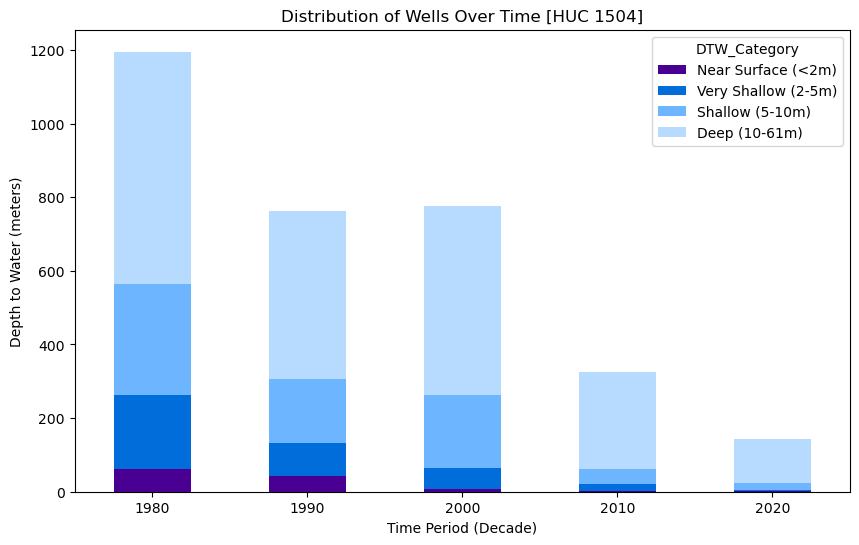

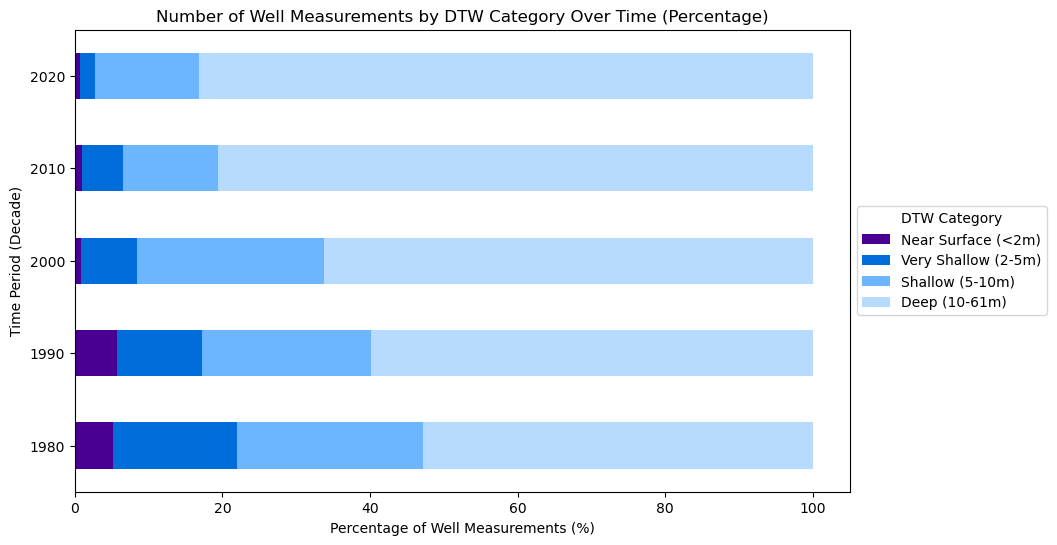

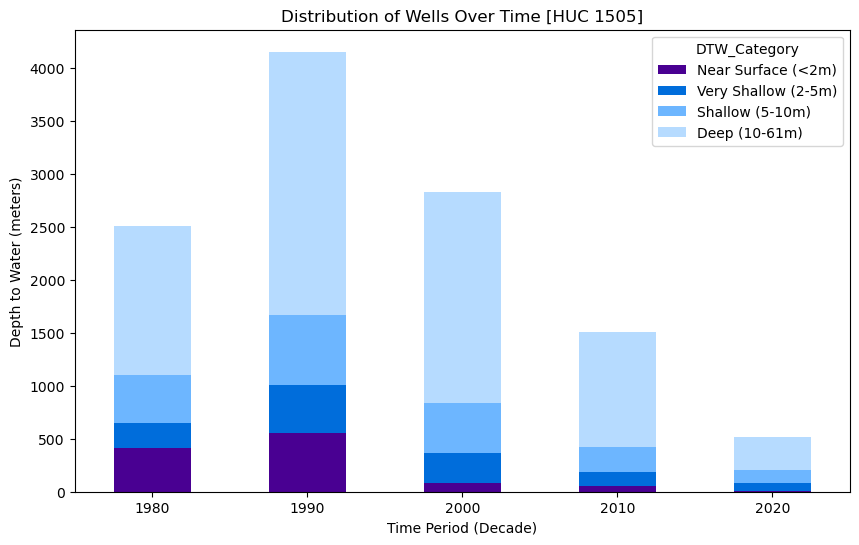

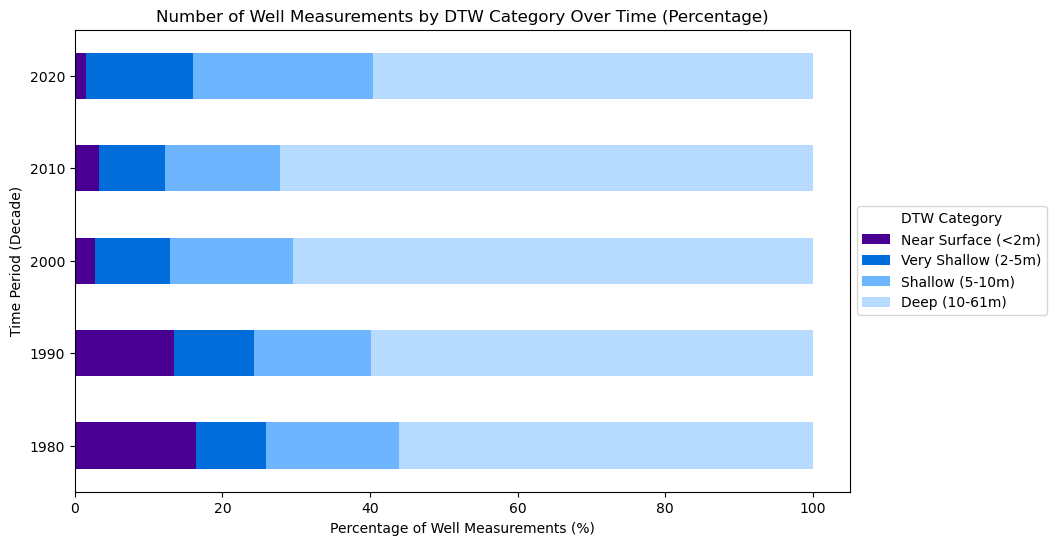

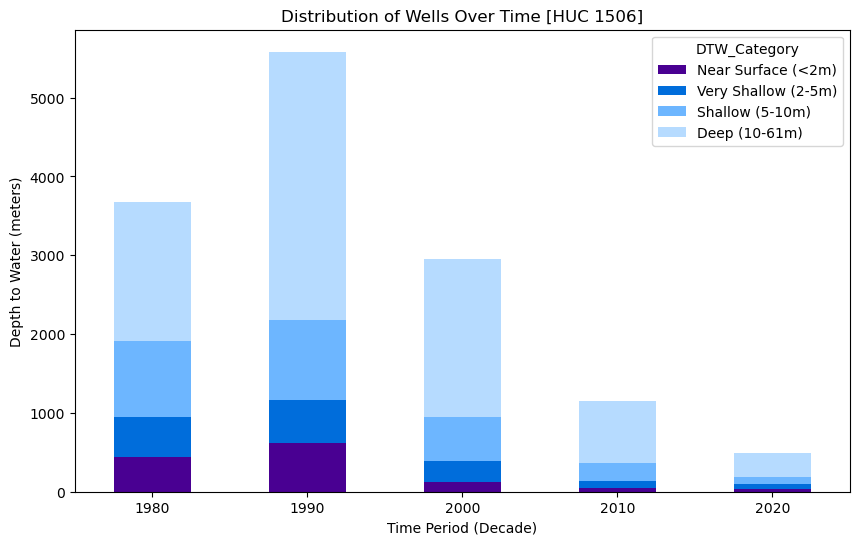

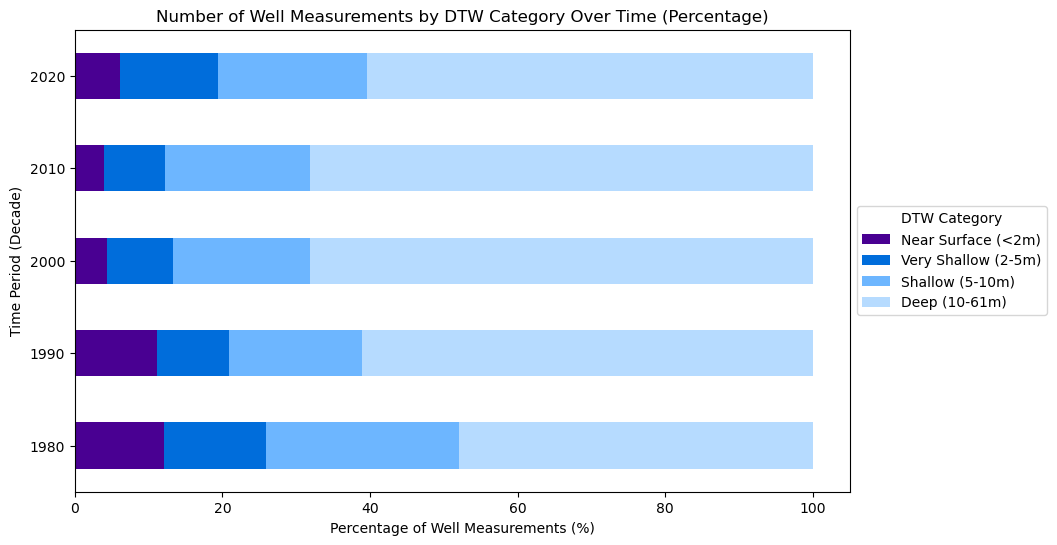

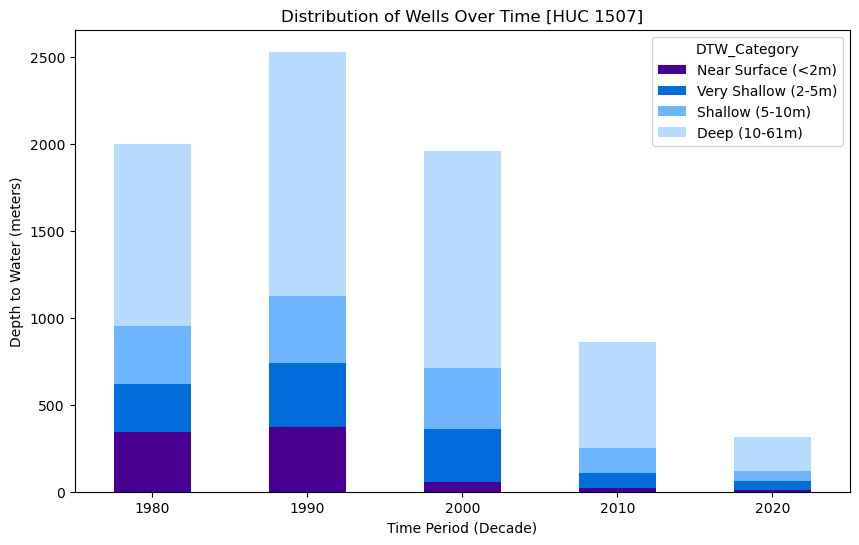

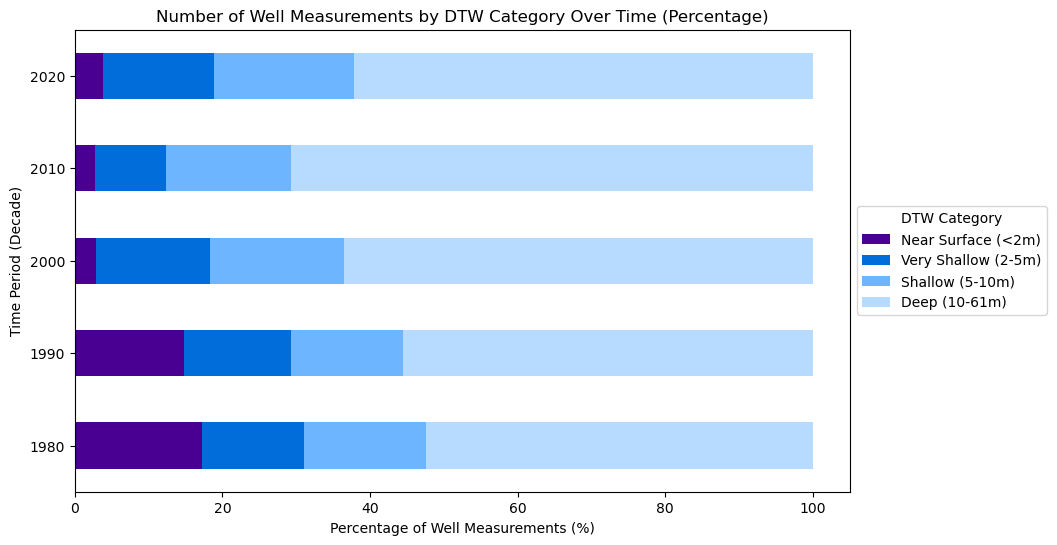

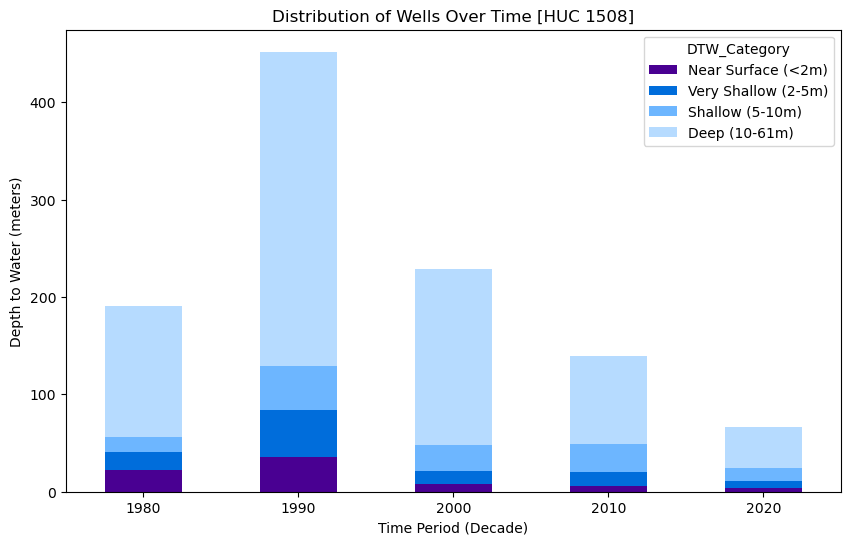

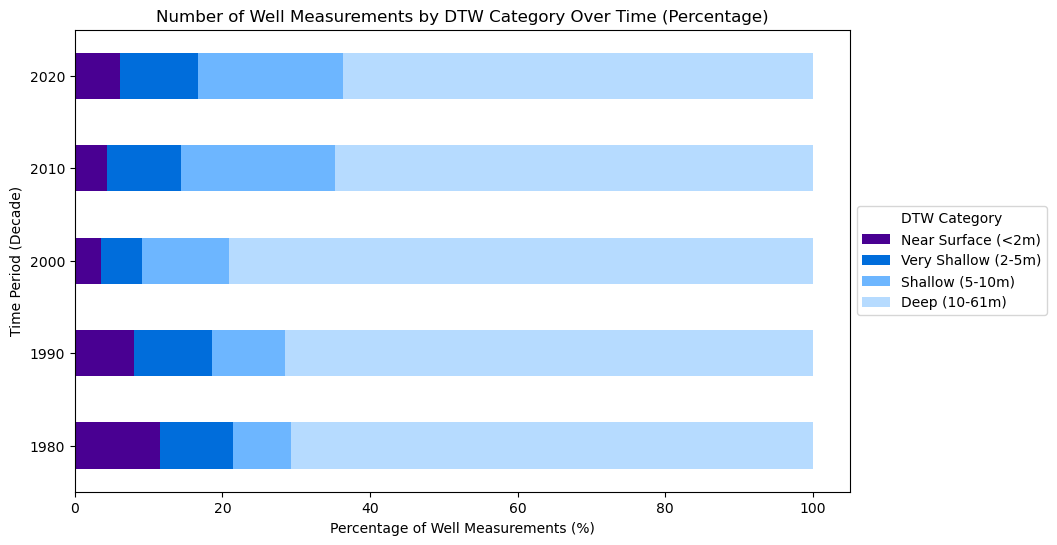

In [72]:
listofhucs = df_melted[Naming_col+"_wb"].unique().tolist()
num_hucs = len(listofhucs)

# Determine grid size
cols = math.ceil(math.sqrt(num_hucs))  # Try to make a roughly square grid
rows = math.ceil(num_hucs / cols)

# fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6), constrained_layout=True)

# Flatten axes if there's more than one row
if rows > 1 or cols > 1:
    axes = axes.flatten()
else:
    axes = [axes]  # Ensure it's iterable

for i, bitch in enumerate(listofhucs):
    subset = df_melted[df_melted[Naming_col+"_wb"] == bitch]
    summary_df_huc = subset.groupby(['Decade', 'DTW_Category'])['Combo_ID'].nunique().reset_index()
    summary_df_huc.rename(columns={'Combo_ID': 'Well Count'}, inplace=True)
    summary_pivot = summary_df_huc.pivot(index='Decade', columns='DTW_Category', values='Well Count').fillna(0)
    summary_pivot = summary_pivot[category_order]
    fig, ax = plt.subplots(figsize=(10, 6))
    summary_pivot.plot(kind='bar', stacked=True, color=[colors[c] for c in summary_pivot.columns], ax=ax)
    ax.set_title(f'Distribution of Wells Over Time [HUC {bitch}]')
    ax.set_xlabel('Time Period (Decade)')
    ax.set_ylabel('Number of Well Measurements')
    ax.tick_params(axis='x', rotation=0)
    # axes[i].set_ylim(65, -5)
    summary_pivot_percent = summary_pivot.div(summary_pivot.sum(axis=1), axis=0) * 100

    # Plot stacked horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    summary_pivot_percent.plot(
        kind='barh',  # Horizontal bar chart
        stacked=True, 
        color=[colors[c] for c in summary_pivot.columns], 
        ax=ax
    )

    # Labels and title
    plt.xlabel('Percentage of Well Measurements (%)')
    plt.ylabel('Time Period (Decade)')
    plt.title('Number of Well Measurements by DTW Category Over Time (Percentage)')
    plt.legend(title='DTW Category', loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside for clarity
    plt.xticks(rotation=0)  # Keep x-axis labels horizontal

    plt.show()


In [68]:
summary_pivot

DTW_Category  Deep (10-61m)  Near Surface (<2m)  Shallow (5-10m)  \
Decade                                                             
1980                    135                  22               15   
1990                    323                  36               45   
2000                    181                   8               27   
2010                     90                   6               29   
2020                     42                   4               13   

DTW_Category  Very Shallow (2-5m)  
Decade                             
1980                           19  
1990                           48  
2000                           13  
2010                           14  
2020                            7

Once we run this, we can then convert it to pandas dataframe and add it to the other summary column

## Using Dask step by Step

This does all of the above to the waterhsed boundary dataset but is broken down into multiple steps that are a little easier to follow

Read in the main databases.  You only have to do this once.

Master Database might take a while unless you use dask (~5-7 minutes).

In [ ]:
# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(outputpath, filename_mdb_nd)
print(filepath)

# masterdb = gp.read_file(filepath)
masterdb = dgp.read_file(filepath, npartitions=10)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb.info())

../../Data/Output/Local\Master_ADWR_database_noduplicates.shp
<class 'dask_geopandas.core.GeoDataFrame'>
Columns: 80 entries, Combo_ID to geometry
dtypes: geometry(1), object(59), float64(20)None


Here too, using dask went from taking 3 minutes to one minute (mostly for formatting)

In [ ]:
# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py

# filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated.csv'
filename_ts = 'Wells55_GWSI_WLTS_DB_monthly.csv'
filepath = os.path.join(outputpath, filename_ts)
print(filepath)
# annual_db = pd.read_csv(filepath, header=1, index_col=0)
annual_db = dd.read_csv(filepath, header=1)
annual_db = annual_db.set_index('date')

# #Block to do some formatting
# annual_db = annual_db[1:168102] # Use this if you read in with pandas
# annual_db2 = annual_db.reset_index(inplace=True)
# annual_db.index = annual_db.index.astype('int64')
annual_db = annual_db.iloc[:,1:168102]
annual_db = annual_db.set_index(annual_db.index.astype('int64'))
annual_db2 = annual_db.reset_index()
annual_db2 = annual_db2.rename(columns = {'date':'Combo_ID'})
annual_db2.head()

../../Data/Output/Local\Wells55_GWSI_WLTS_DB_monthly.csv


Combo_ID  1856-01  1857-12  1860-01  1864-01  1868-01  1870-01  1871-01  \
0     60001      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1     83578      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2     84067      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3     84442      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4     84455      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

   1872-01  1873-01  ...  2023-06  2023-07  2023-08  2023-09  2023-10  \
0      NaN      NaN  ...      NaN      NaN      NaN      NaN      NaN   
1      NaN      NaN  ...      NaN      NaN      NaN      NaN      NaN   
2      NaN      NaN  ...      NaN      NaN      NaN      NaN      NaN   
3      NaN      NaN  ...      NaN      NaN      NaN      NaN      NaN   
4      NaN      NaN  ...      NaN      NaN      NaN      NaN      NaN   

   2023-11  2023-12  2024-01  2024-02  2024-03  
0      NaN   483.90      NaN      NaN      NaN  
1      NaN      NaN      NaN      NaN      NaN  
2      NaN      NaN      NaN      NaN      NaN  
3      NaN      NaN      NaN      NaN      NaN  
4      NaN      NaN      NaN      NaN      NaN  

[5 rows x 1413 columns]

### From here down is where you can rerun the code to generate graphs

In [ ]:
# Put your huc number here
huc_num = '4'

In [ ]:
# Read in the reach shapefile

# filename_shapeile = '/flowlines_order4plus.shp'
# filepath = os.path.join(shapepath, filename_shapeile)
# shapefile = gp.read_file(filepath)
# shapefile.plot(cmap='viridis')
filename_shapefile = '/huc'+huc_num+'flowlines_order3plus.shp'
filepath = os.path.join(outputpath+filename_shapefile)
shapefile = dgp.read_file(filepath, npartitions=10)

Take a look at the columns and variables

In [ ]:
shapefile

Dask GeoDataFrame Structure:
               permanent_ gnis_name reachcode streamorde      ID    huc4 huc_name  fcode hydroseq  geometry
npartitions=10                                                                                             
0                  object    object    object      int32  object  object   object  int32  float64  geometry
35572                 ...       ...       ...        ...     ...     ...      ...    ...      ...       ...
...                   ...       ...       ...        ...     ...     ...      ...    ...      ...       ...
320148                ...       ...       ...        ...     ...     ...      ...    ...      ...       ...
355713                ...       ...       ...        ...     ...     ...      ...    ...      ...       ...
Dask Name: read-file, 1 graph layer

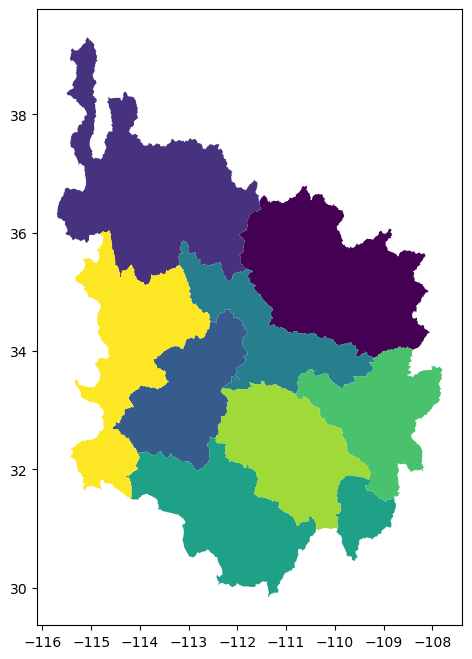

In [ ]:
# Read in the watershed boundary shapefile
filename_shapefile = 'WBDHU'+huc_num+'.shp'
filepath = os.path.join(shapepath+"/WBD_15_HU2_Shape/Shape/", filename_shapefile) #This is the path for my laptop

# For using geopandas:
# filepath = os.path.join(shapepath+"/NHD_H_Arizona_State_Shape/Shape/",filename_shapeile)
# shapefile_wbd = gp.read_file(filepath)
# shapefile_wbd.plot(cmap='viridis')

# For using dask:
shapefile = dgp.read_file(filepath, npartitions=10)
shapefile = shapefile.rename(columns = {'huc'+huc_num:'huc'+huc_num+'_wb',})
shapefile.compute().plot(figsize=(10, 8)
                             , legend=True, cmap='viridis')
plt.show()


Take a look at the columns and variables

In [ ]:
shapefile = shapefile[['huc'+huc_num+'_wb','geometry']]
shapefile

Dask GeoDataFrame Structure:
              huc4_wb  geometry
npartitions=8                  
0              object  geometry
1                 ...       ...
...               ...       ...
7                 ...       ...
7                 ...       ...
Dask Name: getitem, 3 graph layers

In [ ]:
# Define some things about your file

StudyArea = "HUC"+huc_num+"s"
Naming_col = "huc"+huc_num+""


Merging the databases takes a little time - Approximately 3 minutes

In [ ]:
# Merge the shapefile with the master database

# For geopandas
# shapefile_wbd = shapefile_wbd.to_crs(epsg=26912)
# masterdb2 = masterdb.set_crs(epsg=26912)
# static_geo = gp.sjoin(masterdb2, shapefile_wbd, how="inner"
#                     #   , op='intersects'
#                       , predicate='intersects'
#                       )

# For Dask
shapefile = shapefile.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(26912)
static_geo = dgp.sjoin(masterdb2, shapefile, how="inner"
                    #   , op='intersects'
                      , predicate='intersects'
                      )

print(str(filename_mdb_nd) + " and " + str(filename_shapefile) + " join complete.")


Master_ADWR_database_noduplicates.shp and WBDHU4.shp join complete.


Check to make sure the merged dataframe looks good

In [ ]:
static_geo

Dask GeoDataFrame Structure:
               Combo_ID OBJECTID_g SITE_ID LOCAL_ID REGISTRY_I WELL_TYPE   DD_LAT  DD_LONG LAT_NAD27 LONG_NAD27 WELL_ALT WATER_USE_ WELL_DEPTH CASE_DIAM WL_COUNT   WL_DTW  WL_ELEV  SOURCE   IDXBK DRILL_DATE LASTWLDATE QUASI_IDX_ GOES_ENABL TRANSDUCER   IDXBK2 FREQUENCY Original_D OBJECTID_w PROGRAM OWNER_NAME RGR_PUMP_D WELLTYPE WELL_TYPE_ DLIC_NUM APPROVED INSTALLED WATER_LEVE CASING_DEP CASING_DIA CASING_TYP PUMP_TYPE PUMP_POWER PUMPRATE TESTEDRATE DRAW_DOWN COMPLETION DRILL_LOG WELL_CANCE CADASTRAL  COUNTY WATERSHED BASIN_NAME SUBBASIN_N     AMA QUAD_CODE WHOLE_TOWN HALF_TOWNS NORTHSOUTH WHOLE_RANG HALF_RANGE EASTWEST SECTION QUARTER_16 QACRE160DI QUARTER_40 QACRE40DIR QUARTER_10 QACRE10DIR UTM_X_METE UTM_Y_METE APPLICATIO ADDRESS1 ADDRESS2    CITY   STATE     ZIP    ZIP4 WATER_US_1 SITE_USE  geometry index_right huc4_wb
npartitions=80                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
                 object    float64  object   object     object    object  float64  float64    object     object  float64     object    float64   float64  float64  float64  float64  object  object     object     object     object     object     object  float64   float64     object    float64  object     object     object   object     object   object   object    object    float64    float64    float64     object    object     object  float64    float64   float64     object    object     object    object  object    object     object     object  object    object     object     object     object     object     object   object  object     object     object     object     object     object     object    float64    float64     object   object   object  object  object  object  object     object   object  geometry       int64  object
                    ...        ...     ...      ...        ...       ...      ...      ...       ...        ...      ...        ...        ...       ...      ...      ...      ...     ...     ...        ...        ...        ...        ...        ...      ...       ...        ...        ...     ...        ...        ...      ...        ...      ...      ...       ...        ...        ...        ...        ...       ...        ...      ...        ...       ...        ...       ...        ...       ...     ...       ...        ...        ...     ...       ...        ...        ...        ...        ...        ...      ...     ...        ...        ...        ...        ...        ...        ...        ...        ...        ...      ...      ...     ...     ...     ...     ...        ...      ...       ...         ...     ...
...                 ...        ...     ...      ...        ...       ...      ...      ...       ...        ...      ...        ...        ...       ...      ...      ...      ...     ...     ...        ...        ...        ...        ...        ...      ...       ...        ...        ...     ...        ...        ...      ...        ...      ...      ...       ...        ...        ...        ...        ...       ...        ...      ...        ...       ...        ...       ...        ...       ...     ...       ...        ...        ...     ...       ...        ...        ...        ...        ...        ...      ..

In [ ]:
static_geo = static_geo.drop(columns='index_right')
static_geo.columns

Index(['Combo_ID', 'OBJECTID_g', 'SITE_ID', 'LOCAL_ID', 'REGISTRY_I',
       'WELL_TYPE', 'DD_LAT', 'DD_LONG', 'LAT_NAD27', 'LONG_NAD27', 'WELL_ALT',
       'WATER_USE_', 'WELL_DEPTH', 'CASE_DIAM', 'WL_COUNT', 'WL_DTW',
       'WL_ELEV', 'SOURCE', 'IDXBK', 'DRILL_DATE', 'LASTWLDATE', 'QUASI_IDX_',
       'GOES_ENABL', 'TRANSDUCER', 'IDXBK2', 'FREQUENCY', 'Original_D',
       'OBJECTID_w', 'PROGRAM', 'OWNER_NAME', 'RGR_PUMP_D', 'WELLTYPE',
       'WELL_TYPE_', 'DLIC_NUM', 'APPROVED', 'INSTALLED', 'WATER_LEVE',
       'CASING_DEP', 'CASING_DIA', 'CASING_TYP', 'PUMP_TYPE', 'PUMP_POWER',
       'PUMPRATE', 'TESTEDRATE', 'DRAW_DOWN', 'COMPLETION', 'DRILL_LOG',
       'WELL_CANCE', 'CADASTRAL', 'COUNTY', 'WATERSHED', 'BASIN_NAME',
       'SUBBASIN_N', 'AMA', 'QUAD_CODE', 'WHOLE_TOWN', 'HALF_TOWNS',
       'NORTHSOUTH', 'WHOLE_RANG', 'HALF_RANGE', 'EASTWEST', 'SECTION',
       'QUARTER_16', 'QACRE160DI', 'QUARTER_40', 'QACRE40DIR', 'QUARTER_10',
       'QACRE10DIR', 'UTM_X_METE', 'UTM_Y_METE'

In [ ]:
# Pull out the columns you need
# Use this for subbasins:
# reg_list = static_geo[['Combo_ID', Naming_col+'_right','WELL_DEPTH','WELL_TYPE_']]

# Use this or cities:
reg_list = static_geo[['Combo_ID', Naming_col+'_wb','WELL_DEPTH','WELL_TYPE_'
                    #    ,'reachcode','fcode','hydroseq'
                       ]]
# reg_list

# %% Converting Combo_ID to int
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64
                                                   # , errors = 'raise'
                                                   )

In [ ]:
# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
combo.info()

# %% set index to Combo_ID
combo.set_index('Combo_ID'
                # , inplace=True
                )

<class 'dask.dataframe.core.DataFrame'>
Columns: 1416 entries, Combo_ID to WELL_TYPE_
dtypes: object(2), float64(1413), int64(1)

Dask DataFrame Structure:
                 1856-01  1857-12  1860-01  1864-01  1868-01  1870-01  1871-01  1872-01  1873-01  1875-10  1876-01  1877-01  1878-01  1878-02  1879-01  1880-01  1880-12  1881-01  1881-12  1882-01  1882-11  1882-12  1883-01  1883-05  1884-01  1884-06  1884-09  1885-01  1885-02  1886-01  1887-01  1888-01  1889-01  1889-12  1890-01  1890-12  1891-01  1891-12  1892-01  1893-01  1893-05  1893-12  1894-01  1895-01  1895-08  1895-12  1896-01  1897-01  1898-01  1898-05  1898-12  1899-01  1899-05  1899-11  1899-12  1900-01  1900-04  1900-07  1900-08  1900-09  1900-12  1901-01  1901-03  1901-06  1901-10  1901-12  1902-01  1902-03  1902-07  1902-08  1902-12  1903-01  1903-04  1903-05  1903-10  1903-12  1904-01  1904-05  1904-09  1904-12  1905-01  1905-03  1905-07  1905-11  1906-01  1906-05  1906-06  1906-12  1907-01  1907-05  1908-01  1908-04  1908-06  1908-08  1909-01  1909-04  1909-09  1909-11  1909-12  1910-01  1910-03  1910-05  1910-10  1910-12  1911-01  1911-02  1911-03  1911-06  1911-12  1912-01  1912-05  1912-06  1912-09  1912-11  1912-12  1913-01  1913-04  1913-06  1913-07  1913-09  1913-11  1913-12  1914-01  1914-03  1914-06  1914-07  1914-08  1914-10  1914-12  1915-01  1915-02  1915-03  1915-05  1915-06  1915-07  1915-08  1915-10  1915-12  1916-01  1916-03  1916-04  1916-06  1916-07  1916-09  1916-12  1917-01  1917-02  1917-03  1917-04  1917-05  1917-06  1917-07  1917-08  1917-09  1917-10  1917-11  1917-12  1918-01  1918-02  1918-03  1918-04  1918-05  1918-06  1918-07  1918-08  1918-09  1918-10  1918-11  1918-12  1919-01  1919-02  1919-03  1919-04  1919-05  1919-06  1919-07  1919-08  1919-09  1919-11  1919-12  1920-01  1920-02  1920-05  1920-06  1920-07  1920-08  1920-09  1920-10  1920-12  1921-01  1921-03  1921-05  1921-06  1921-08  1921-10  1921-12  1922-01  1922-02  1922-03  1922-04  1922-05  1922-06  1922-09  1922-12  1923-01  1923-02  1923-03  1923-04  1923-05  1923-07  1923-08  1923-09  1923-10  1923-11  1924-01  1924-02  1924-03  1924-04  1924-05  1924-06  1924-07  1924-08  1924-09  1924-10  1924-11  1924-12  1925-01  1925-02  1925-03  1925-05  1925-06  1925-07  1925-08  1925-09  1925-10  1925-12  1926-01  1926-02  1926-04  1926-05  1926-06  1926-07  1926-10  1926-11  1926-12  1927-01  1927-02  1927-03  1927-04  1927-05  1927-06  1927-07  1927-08  1927-09  1927-10  1927-11  1927-12  1928-01  1928-02  1928-03  1928-04  1928-05  1928-06  1928-07  1928-08  1928-09  1928-10  1928-11  1928-12  1929-01  1929-02  1929-03  1929-04  1929-05  1929-06  1929-07  1929-08  1929-09  1929-10  1929-11  1929-12  1930-01  1930-02  1930-03  1930-04  1930-05  1930-06  1930-07  1930-08  1930-09  1930-10  1930-11  1930-12  1931-01  1931-02  1931-03  1931-04  1931-05  1931-06  1931-07  1931-08  1931-09  1931-10  1931-11  1931-12  1932-01  1932-02  1932-03  1932-04  1932-05  1932-06  1932-07  1932-08  1932-09  1932-10  1932-11  1932-12  1933-01  1933-02  1933-03  1933-04  1933-05  1933-06  1933-07  1933-08  1933-09  1933-10  1933-11  1933-12  1934-01  1934-02  1934-03  1934-04  1934-05  1934-06  1934-07  1934-08  1934-09  1934-10  1934-11  1934-12  1935-01  1935-02  1935-03  1935-04  1935-05  1935-06  1935-07  1935-08  1935-09  1935-10  1935-11  1935-12  1936-01  1936-02  1936-03  1936-04  1936-05  1936-06  1936-07  1936-08  1936-09  1936-10  1936-11  1936-12  1937-01  1937-02  1937-03  1937-04  1937-05  1937-06  1937-07  1937-08  1937-09  1937-10  1937-11  1937-12  1938-01  1938-02  1938-03  1938-04  1938-05  1938-06  1938-07  1938-08  1938-09  1938-10  1938-11  1938-12  1939-01  1939-02  1939-03  1939-04  1939-05  1939-06  1939-07  1939-08  1939-09  1939-10  1939-11  1939-12  1940-01  1940-02  1940-03  1940-04  1940-05  1940-06  1940-07  1940-08  1940-09  1940-10  1940-11  1940-12  1941-01  1941-02  1941-03  1941-04  1941-05  1941-06  1941-07  1941-08  1941-09  1941-10  1941-11  1941-12  1942-01  1942-02  1942-03  1942-04  1942-05  1942-06  1942-07  1942-08  1942-09  1942-10  1942-11  1942-12  1943-01  1943-02  1943-0

In [ ]:
combo

Dask DataFrame Structure:
               Combo_ID  1856-01  1857-12  1860-01  1864-01  1868-01  1870-01  1871-01  1872-01  1873-01  1875-10  1876-01  1877-01  1878-01  1878-02  1879-01  1880-01  1880-12  1881-01  1881-12  1882-01  1882-11  1882-12  1883-01  1883-05  1884-01  1884-06  1884-09  1885-01  1885-02  1886-01  1887-01  1888-01  1889-01  1889-12  1890-01  1890-12  1891-01  1891-12  1892-01  1893-01  1893-05  1893-12  1894-01  1895-01  1895-08  1895-12  1896-01  1897-01  1898-01  1898-05  1898-12  1899-01  1899-05  1899-11  1899-12  1900-01  1900-04  1900-07  1900-08  1900-09  1900-12  1901-01  1901-03  1901-06  1901-10  1901-12  1902-01  1902-03  1902-07  1902-08  1902-12  1903-01  1903-04  1903-05  1903-10  1903-12  1904-01  1904-05  1904-09  1904-12  1905-01  1905-03  1905-07  1905-11  1906-01  1906-05  1906-06  1906-12  1907-01  1907-05  1908-01  1908-04  1908-06  1908-08  1909-01  1909-04  1909-09  1909-11  1909-12  1910-01  1910-03  1910-05  1910-10  1910-12  1911-01  1911-02  1911-03  1911-06  1911-12  1912-01  1912-05  1912-06  1912-09  1912-11  1912-12  1913-01  1913-04  1913-06  1913-07  1913-09  1913-11  1913-12  1914-01  1914-03  1914-06  1914-07  1914-08  1914-10  1914-12  1915-01  1915-02  1915-03  1915-05  1915-06  1915-07  1915-08  1915-10  1915-12  1916-01  1916-03  1916-04  1916-06  1916-07  1916-09  1916-12  1917-01  1917-02  1917-03  1917-04  1917-05  1917-06  1917-07  1917-08  1917-09  1917-10  1917-11  1917-12  1918-01  1918-02  1918-03  1918-04  1918-05  1918-06  1918-07  1918-08  1918-09  1918-10  1918-11  1918-12  1919-01  1919-02  1919-03  1919-04  1919-05  1919-06  1919-07  1919-08  1919-09  1919-11  1919-12  1920-01  1920-02  1920-05  1920-06  1920-07  1920-08  1920-09  1920-10  1920-12  1921-01  1921-03  1921-05  1921-06  1921-08  1921-10  1921-12  1922-01  1922-02  1922-03  1922-04  1922-05  1922-06  1922-09  1922-12  1923-01  1923-02  1923-03  1923-04  1923-05  1923-07  1923-08  1923-09  1923-10  1923-11  1924-01  1924-02  1924-03  1924-04  1924-05  1924-06  1924-07  1924-08  1924-09  1924-10  1924-11  1924-12  1925-01  1925-02  1925-03  1925-05  1925-06  1925-07  1925-08  1925-09  1925-10  1925-12  1926-01  1926-02  1926-04  1926-05  1926-06  1926-07  1926-10  1926-11  1926-12  1927-01  1927-02  1927-03  1927-04  1927-05  1927-06  1927-07  1927-08  1927-09  1927-10  1927-11  1927-12  1928-01  1928-02  1928-03  1928-04  1928-05  1928-06  1928-07  1928-08  1928-09  1928-10  1928-11  1928-12  1929-01  1929-02  1929-03  1929-04  1929-05  1929-06  1929-07  1929-08  1929-09  1929-10  1929-11  1929-12  1930-01  1930-02  1930-03  1930-04  1930-05  1930-06  1930-07  1930-08  1930-09  1930-10  1930-11  1930-12  1931-01  1931-02  1931-03  1931-04  1931-05  1931-06  1931-07  1931-08  1931-09  1931-10  1931-11  1931-12  1932-01  1932-02  1932-03  1932-04  1932-05  1932-06  1932-07  1932-08  1932-09  1932-10  1932-11  1932-12  1933-01  1933-02  1933-03  1933-04  1933-05  1933-06  1933-07  1933-08  1933-09  1933-10  1933-11  1933-12  1934-01  1934-02  1934-03  1934-04  1934-05  1934-06  1934-07  1934-08  1934-09  1934-10  1934-11  1934-12  1935-01  1935-02  1935-03  1935-04  1935-05  1935-06  1935-07  1935-08  1935-09  1935-10  1935-11  1935-12  1936-01  1936-02  1936-03  1936-04  1936-05  1936-06  1936-07  1936-08  1936-09  1936-10  1936-11  1936-12  1937-01  1937-02  1937-03  1937-04  1937-05  1937-06  1937-07  1937-08  1937-09  1937-10  1937-11  1937-12  1938-01  1938-02  1938-03  1938-04  1938-05  1938-06  1938-07  1938-08  1938-09  1938-10  1938-11  1938-12  1939-01  1939-02  1939-03  1939-04  1939-05  1939-06  1939-07  1939-08  1939-09  1939-10  1939-11  1939-12  1940-01  1940-02  1940-03  1940-04  1940-05  1940-06  1940-07  1940-08  1940-09  1940-10  1940-11  1940-12  1941-01  1941-02  1941-03  1941-04  1941-05  1941-06  1941-07  1941-08  1941-09  1941-10  1941-11  1941-12  1942-01  1942-02  1942-03  1942-04  1942-05  1942-06  1942-07  1942-08  1942-09  1942-10  1942-11  1942-12  1943-01  1943-02

Here we only want shallow wells (anything less than 200ft) and to remove wells with default 0 drilling depth values

In [ ]:
# Filter by drilling depth
test = combo.copy()
# test["WELL_DEPTH"] = test["WELL_DEPTH"].astype("float64")  # Converts column to integer (handles NaNs)
test = test[(test['WELL_DEPTH']<=200)&(test['WELL_DEPTH']>0)]
# test['WELL_DEPTH'].unique()
test


Dask DataFrame Structure:
               Combo_ID  1856-01  1857-12  1860-01  1864-01  1868-01  1870-01  1871-01  1872-01  1873-01  1875-10  1876-01  1877-01  1878-01  1878-02  1879-01  1880-01  1880-12  1881-01  1881-12  1882-01  1882-11  1882-12  1883-01  1883-05  1884-01  1884-06  1884-09  1885-01  1885-02  1886-01  1887-01  1888-01  1889-01  1889-12  1890-01  1890-12  1891-01  1891-12  1892-01  1893-01  1893-05  1893-12  1894-01  1895-01  1895-08  1895-12  1896-01  1897-01  1898-01  1898-05  1898-12  1899-01  1899-05  1899-11  1899-12  1900-01  1900-04  1900-07  1900-08  1900-09  1900-12  1901-01  1901-03  1901-06  1901-10  1901-12  1902-01  1902-03  1902-07  1902-08  1902-12  1903-01  1903-04  1903-05  1903-10  1903-12  1904-01  1904-05  1904-09  1904-12  1905-01  1905-03  1905-07  1905-11  1906-01  1906-05  1906-06  1906-12  1907-01  1907-05  1908-01  1908-04  1908-06  1908-08  1909-01  1909-04  1909-09  1909-11  1909-12  1910-01  1910-03  1910-05  1910-10  1910-12  1911-01  1911-02  1911-03  1911-06  1911-12  1912-01  1912-05  1912-06  1912-09  1912-11  1912-12  1913-01  1913-04  1913-06  1913-07  1913-09  1913-11  1913-12  1914-01  1914-03  1914-06  1914-07  1914-08  1914-10  1914-12  1915-01  1915-02  1915-03  1915-05  1915-06  1915-07  1915-08  1915-10  1915-12  1916-01  1916-03  1916-04  1916-06  1916-07  1916-09  1916-12  1917-01  1917-02  1917-03  1917-04  1917-05  1917-06  1917-07  1917-08  1917-09  1917-10  1917-11  1917-12  1918-01  1918-02  1918-03  1918-04  1918-05  1918-06  1918-07  1918-08  1918-09  1918-10  1918-11  1918-12  1919-01  1919-02  1919-03  1919-04  1919-05  1919-06  1919-07  1919-08  1919-09  1919-11  1919-12  1920-01  1920-02  1920-05  1920-06  1920-07  1920-08  1920-09  1920-10  1920-12  1921-01  1921-03  1921-05  1921-06  1921-08  1921-10  1921-12  1922-01  1922-02  1922-03  1922-04  1922-05  1922-06  1922-09  1922-12  1923-01  1923-02  1923-03  1923-04  1923-05  1923-07  1923-08  1923-09  1923-10  1923-11  1924-01  1924-02  1924-03  1924-04  1924-05  1924-06  1924-07  1924-08  1924-09  1924-10  1924-11  1924-12  1925-01  1925-02  1925-03  1925-05  1925-06  1925-07  1925-08  1925-09  1925-10  1925-12  1926-01  1926-02  1926-04  1926-05  1926-06  1926-07  1926-10  1926-11  1926-12  1927-01  1927-02  1927-03  1927-04  1927-05  1927-06  1927-07  1927-08  1927-09  1927-10  1927-11  1927-12  1928-01  1928-02  1928-03  1928-04  1928-05  1928-06  1928-07  1928-08  1928-09  1928-10  1928-11  1928-12  1929-01  1929-02  1929-03  1929-04  1929-05  1929-06  1929-07  1929-08  1929-09  1929-10  1929-11  1929-12  1930-01  1930-02  1930-03  1930-04  1930-05  1930-06  1930-07  1930-08  1930-09  1930-10  1930-11  1930-12  1931-01  1931-02  1931-03  1931-04  1931-05  1931-06  1931-07  1931-08  1931-09  1931-10  1931-11  1931-12  1932-01  1932-02  1932-03  1932-04  1932-05  1932-06  1932-07  1932-08  1932-09  1932-10  1932-11  1932-12  1933-01  1933-02  1933-03  1933-04  1933-05  1933-06  1933-07  1933-08  1933-09  1933-10  1933-11  1933-12  1934-01  1934-02  1934-03  1934-04  1934-05  1934-06  1934-07  1934-08  1934-09  1934-10  1934-11  1934-12  1935-01  1935-02  1935-03  1935-04  1935-05  1935-06  1935-07  1935-08  1935-09  1935-10  1935-11  1935-12  1936-01  1936-02  1936-03  1936-04  1936-05  1936-06  1936-07  1936-08  1936-09  1936-10  1936-11  1936-12  1937-01  1937-02  1937-03  1937-04  1937-05  1937-06  1937-07  1937-08  1937-09  1937-10  1937-11  1937-12  1938-01  1938-02  1938-03  1938-04  1938-05  1938-06  1938-07  1938-08  1938-09  1938-10  1938-11  1938-12  1939-01  1939-02  1939-03  1939-04  1939-05  1939-06  1939-07  1939-08  1939-09  1939-10  1939-11  1939-12  1940-01  1940-02  1940-03  1940-04  1940-05  1940-06  1940-07  1940-08  1940-09  1940-10  1940-11  1940-12  1941-01  1941-02  1941-03  1941-04  1941-05  1941-06  1941-07  1941-08  1941-09  1941-10  1941-11  1941-12  1942-01  1942-02  1942-03  1942-04  1942-05  1942-06  1942-07  1942-08  1942-09  1942-10  1942-11  1942-12  1943-01  1943-02

This portion of the code makes sure a well isn't being counted multiple times

In [ ]:
combo_copy = test.copy()
df = combo_copy.reset_index()  # Moves well_ID from index to a column (if needed)
df = df.drop_duplicates(subset=["Combo_ID", Naming_col+"_wb"])
df = df.set_index("Combo_ID")
df


Dask DataFrame Structure:
                 index  1856-01  1857-12  1860-01  1864-01  1868-01  1870-01  1871-01  1872-01  1873-01  1875-10  1876-01  1877-01  1878-01  1878-02  1879-01  1880-01  1880-12  1881-01  1881-12  1882-01  1882-11  1882-12  1883-01  1883-05  1884-01  1884-06  1884-09  1885-01  1885-02  1886-01  1887-01  1888-01  1889-01  1889-12  1890-01  1890-12  1891-01  1891-12  1892-01  1893-01  1893-05  1893-12  1894-01  1895-01  1895-08  1895-12  1896-01  1897-01  1898-01  1898-05  1898-12  1899-01  1899-05  1899-11  1899-12  1900-01  1900-04  1900-07  1900-08  1900-09  1900-12  1901-01  1901-03  1901-06  1901-10  1901-12  1902-01  1902-03  1902-07  1902-08  1902-12  1903-01  1903-04  1903-05  1903-10  1903-12  1904-01  1904-05  1904-09  1904-12  1905-01  1905-03  1905-07  1905-11  1906-01  1906-05  1906-06  1906-12  1907-01  1907-05  1908-01  1908-04  1908-06  1908-08  1909-01  1909-04  1909-09  1909-11  1909-12  1910-01  1910-03  1910-05  1910-10  1910-12  1911-01  1911-02  1911-03  1911-06  1911-12  1912-01  1912-05  1912-06  1912-09  1912-11  1912-12  1913-01  1913-04  1913-06  1913-07  1913-09  1913-11  1913-12  1914-01  1914-03  1914-06  1914-07  1914-08  1914-10  1914-12  1915-01  1915-02  1915-03  1915-05  1915-06  1915-07  1915-08  1915-10  1915-12  1916-01  1916-03  1916-04  1916-06  1916-07  1916-09  1916-12  1917-01  1917-02  1917-03  1917-04  1917-05  1917-06  1917-07  1917-08  1917-09  1917-10  1917-11  1917-12  1918-01  1918-02  1918-03  1918-04  1918-05  1918-06  1918-07  1918-08  1918-09  1918-10  1918-11  1918-12  1919-01  1919-02  1919-03  1919-04  1919-05  1919-06  1919-07  1919-08  1919-09  1919-11  1919-12  1920-01  1920-02  1920-05  1920-06  1920-07  1920-08  1920-09  1920-10  1920-12  1921-01  1921-03  1921-05  1921-06  1921-08  1921-10  1921-12  1922-01  1922-02  1922-03  1922-04  1922-05  1922-06  1922-09  1922-12  1923-01  1923-02  1923-03  1923-04  1923-05  1923-07  1923-08  1923-09  1923-10  1923-11  1924-01  1924-02  1924-03  1924-04  1924-05  1924-06  1924-07  1924-08  1924-09  1924-10  1924-11  1924-12  1925-01  1925-02  1925-03  1925-05  1925-06  1925-07  1925-08  1925-09  1925-10  1925-12  1926-01  1926-02  1926-04  1926-05  1926-06  1926-07  1926-10  1926-11  1926-12  1927-01  1927-02  1927-03  1927-04  1927-05  1927-06  1927-07  1927-08  1927-09  1927-10  1927-11  1927-12  1928-01  1928-02  1928-03  1928-04  1928-05  1928-06  1928-07  1928-08  1928-09  1928-10  1928-11  1928-12  1929-01  1929-02  1929-03  1929-04  1929-05  1929-06  1929-07  1929-08  1929-09  1929-10  1929-11  1929-12  1930-01  1930-02  1930-03  1930-04  1930-05  1930-06  1930-07  1930-08  1930-09  1930-10  1930-11  1930-12  1931-01  1931-02  1931-03  1931-04  1931-05  1931-06  1931-07  1931-08  1931-09  1931-10  1931-11  1931-12  1932-01  1932-02  1932-03  1932-04  1932-05  1932-06  1932-07  1932-08  1932-09  1932-10  1932-11  1932-12  1933-01  1933-02  1933-03  1933-04  1933-05  1933-06  1933-07  1933-08  1933-09  1933-10  1933-11  1933-12  1934-01  1934-02  1934-03  1934-04  1934-05  1934-06  1934-07  1934-08  1934-09  1934-10  1934-11  1934-12  1935-01  1935-02  1935-03  1935-04  1935-05  1935-06  1935-07  1935-08  1935-09  1935-10  1935-11  1935-12  1936-01  1936-02  1936-03  1936-04  1936-05  1936-06  1936-07  1936-08  1936-09  1936-10  1936-11  1936-12  1937-01  1937-02  1937-03  1937-04  1937-05  1937-06  1937-07  1937-08  1937-09  1937-10  1937-11  1937-12  1938-01  1938-02  1938-03  1938-04  1938-05  1938-06  1938-07  1938-08  1938-09  1938-10  1938-11  1938-12  1939-01  1939-02  1939-03  1939-04  1939-05  1939-06  1939-07  1939-08  1939-09  1939-10  1939-11  1939-12  1940-01  1940-02  1940-03  1940-04  1940-05  1940-06  1940-07  1940-08  1940-09  1940-10  1940-11  1940-12  1941-01  1941-02  1941-03  1941-04  1941-05  1941-06  1941-07  1941-08  1941-09  1941-10  1941-11  1941-12  1942-01  1942-02  1942-03  1942-04  1942-05  1942-06  1942-07  1942-08  1942-09  1942-10  1942-11  1942-12  1943-01  1943-02 

In [ ]:
# Grouping the appropriate column
# combo_copy = combo.copy()
combo_copy = df.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_'
                            #   ,'nan','reachcode','fcode','hydroseq'
                              ],axis=1)


In [ ]:
combo_copy

Dask DataFrame Structure:
                 index  1856-01  1857-12  1860-01  1864-01  1868-01  1870-01  1871-01  1872-01  1873-01  1875-10  1876-01  1877-01  1878-01  1878-02  1879-01  1880-01  1880-12  1881-01  1881-12  1882-01  1882-11  1882-12  1883-01  1883-05  1884-01  1884-06  1884-09  1885-01  1885-02  1886-01  1887-01  1888-01  1889-01  1889-12  1890-01  1890-12  1891-01  1891-12  1892-01  1893-01  1893-05  1893-12  1894-01  1895-01  1895-08  1895-12  1896-01  1897-01  1898-01  1898-05  1898-12  1899-01  1899-05  1899-11  1899-12  1900-01  1900-04  1900-07  1900-08  1900-09  1900-12  1901-01  1901-03  1901-06  1901-10  1901-12  1902-01  1902-03  1902-07  1902-08  1902-12  1903-01  1903-04  1903-05  1903-10  1903-12  1904-01  1904-05  1904-09  1904-12  1905-01  1905-03  1905-07  1905-11  1906-01  1906-05  1906-06  1906-12  1907-01  1907-05  1908-01  1908-04  1908-06  1908-08  1909-01  1909-04  1909-09  1909-11  1909-12  1910-01  1910-03  1910-05  1910-10  1910-12  1911-01  1911-02  1911-03  1911-06  1911-12  1912-01  1912-05  1912-06  1912-09  1912-11  1912-12  1913-01  1913-04  1913-06  1913-07  1913-09  1913-11  1913-12  1914-01  1914-03  1914-06  1914-07  1914-08  1914-10  1914-12  1915-01  1915-02  1915-03  1915-05  1915-06  1915-07  1915-08  1915-10  1915-12  1916-01  1916-03  1916-04  1916-06  1916-07  1916-09  1916-12  1917-01  1917-02  1917-03  1917-04  1917-05  1917-06  1917-07  1917-08  1917-09  1917-10  1917-11  1917-12  1918-01  1918-02  1918-03  1918-04  1918-05  1918-06  1918-07  1918-08  1918-09  1918-10  1918-11  1918-12  1919-01  1919-02  1919-03  1919-04  1919-05  1919-06  1919-07  1919-08  1919-09  1919-11  1919-12  1920-01  1920-02  1920-05  1920-06  1920-07  1920-08  1920-09  1920-10  1920-12  1921-01  1921-03  1921-05  1921-06  1921-08  1921-10  1921-12  1922-01  1922-02  1922-03  1922-04  1922-05  1922-06  1922-09  1922-12  1923-01  1923-02  1923-03  1923-04  1923-05  1923-07  1923-08  1923-09  1923-10  1923-11  1924-01  1924-02  1924-03  1924-04  1924-05  1924-06  1924-07  1924-08  1924-09  1924-10  1924-11  1924-12  1925-01  1925-02  1925-03  1925-05  1925-06  1925-07  1925-08  1925-09  1925-10  1925-12  1926-01  1926-02  1926-04  1926-05  1926-06  1926-07  1926-10  1926-11  1926-12  1927-01  1927-02  1927-03  1927-04  1927-05  1927-06  1927-07  1927-08  1927-09  1927-10  1927-11  1927-12  1928-01  1928-02  1928-03  1928-04  1928-05  1928-06  1928-07  1928-08  1928-09  1928-10  1928-11  1928-12  1929-01  1929-02  1929-03  1929-04  1929-05  1929-06  1929-07  1929-08  1929-09  1929-10  1929-11  1929-12  1930-01  1930-02  1930-03  1930-04  1930-05  1930-06  1930-07  1930-08  1930-09  1930-10  1930-11  1930-12  1931-01  1931-02  1931-03  1931-04  1931-05  1931-06  1931-07  1931-08  1931-09  1931-10  1931-11  1931-12  1932-01  1932-02  1932-03  1932-04  1932-05  1932-06  1932-07  1932-08  1932-09  1932-10  1932-11  1932-12  1933-01  1933-02  1933-03  1933-04  1933-05  1933-06  1933-07  1933-08  1933-09  1933-10  1933-11  1933-12  1934-01  1934-02  1934-03  1934-04  1934-05  1934-06  1934-07  1934-08  1934-09  1934-10  1934-11  1934-12  1935-01  1935-02  1935-03  1935-04  1935-05  1935-06  1935-07  1935-08  1935-09  1935-10  1935-11  1935-12  1936-01  1936-02  1936-03  1936-04  1936-05  1936-06  1936-07  1936-08  1936-09  1936-10  1936-11  1936-12  1937-01  1937-02  1937-03  1937-04  1937-05  1937-06  1937-07  1937-08  1937-09  1937-10  1937-11  1937-12  1938-01  1938-02  1938-03  1938-04  1938-05  1938-06  1938-07  1938-08  1938-09  1938-10  1938-11  1938-12  1939-01  1939-02  1939-03  1939-04  1939-05  1939-06  1939-07  1939-08  1939-09  1939-10  1939-11  1939-12  1940-01  1940-02  1940-03  1940-04  1940-05  1940-06  1940-07  1940-08  1940-09  1940-10  1940-11  1940-12  1941-01  1941-02  1941-03  1941-04  1941-05  1941-06  1941-07  1941-08  1941-09  1941-10  1941-11  1941-12  1942-01  1942-02  1942-03  1942-04  1942-05  1942-06  1942-07  1942-08  1942-09  1942-10  1942-11  1942-12  1943-01  1943-02 

This bit of code will remove any wells with anomalous readings (e.g. anything greater than 500ft)

In [ ]:
df = combo_copy.copy()

# Example: Your dataframe (df) has columns as YYYY-MM and 'Combo_ID' + 'huc12'
# Step 1: Filter columns for readings after 1980
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col+"_wb"] and col >= '1980-01']

# Step 2: Find wells with any reading > 500 ft in these columns
mask = (df[date_cols] > 200).any(axis=1)

# Step 3: Drop wells that meet this condition
df_filtered = df[~mask]

# Now df_filtered contains only wells that never exceeded 500 ft after 1980
df_filtered


Dask DataFrame Structure:
                 index  1856-01  1857-12  1860-01  1864-01  1868-01  1870-01  1871-01  1872-01  1873-01  1875-10  1876-01  1877-01  1878-01  1878-02  1879-01  1880-01  1880-12  1881-01  1881-12  1882-01  1882-11  1882-12  1883-01  1883-05  1884-01  1884-06  1884-09  1885-01  1885-02  1886-01  1887-01  1888-01  1889-01  1889-12  1890-01  1890-12  1891-01  1891-12  1892-01  1893-01  1893-05  1893-12  1894-01  1895-01  1895-08  1895-12  1896-01  1897-01  1898-01  1898-05  1898-12  1899-01  1899-05  1899-11  1899-12  1900-01  1900-04  1900-07  1900-08  1900-09  1900-12  1901-01  1901-03  1901-06  1901-10  1901-12  1902-01  1902-03  1902-07  1902-08  1902-12  1903-01  1903-04  1903-05  1903-10  1903-12  1904-01  1904-05  1904-09  1904-12  1905-01  1905-03  1905-07  1905-11  1906-01  1906-05  1906-06  1906-12  1907-01  1907-05  1908-01  1908-04  1908-06  1908-08  1909-01  1909-04  1909-09  1909-11  1909-12  1910-01  1910-03  1910-05  1910-10  1910-12  1911-01  1911-02  1911-03  1911-06  1911-12  1912-01  1912-05  1912-06  1912-09  1912-11  1912-12  1913-01  1913-04  1913-06  1913-07  1913-09  1913-11  1913-12  1914-01  1914-03  1914-06  1914-07  1914-08  1914-10  1914-12  1915-01  1915-02  1915-03  1915-05  1915-06  1915-07  1915-08  1915-10  1915-12  1916-01  1916-03  1916-04  1916-06  1916-07  1916-09  1916-12  1917-01  1917-02  1917-03  1917-04  1917-05  1917-06  1917-07  1917-08  1917-09  1917-10  1917-11  1917-12  1918-01  1918-02  1918-03  1918-04  1918-05  1918-06  1918-07  1918-08  1918-09  1918-10  1918-11  1918-12  1919-01  1919-02  1919-03  1919-04  1919-05  1919-06  1919-07  1919-08  1919-09  1919-11  1919-12  1920-01  1920-02  1920-05  1920-06  1920-07  1920-08  1920-09  1920-10  1920-12  1921-01  1921-03  1921-05  1921-06  1921-08  1921-10  1921-12  1922-01  1922-02  1922-03  1922-04  1922-05  1922-06  1922-09  1922-12  1923-01  1923-02  1923-03  1923-04  1923-05  1923-07  1923-08  1923-09  1923-10  1923-11  1924-01  1924-02  1924-03  1924-04  1924-05  1924-06  1924-07  1924-08  1924-09  1924-10  1924-11  1924-12  1925-01  1925-02  1925-03  1925-05  1925-06  1925-07  1925-08  1925-09  1925-10  1925-12  1926-01  1926-02  1926-04  1926-05  1926-06  1926-07  1926-10  1926-11  1926-12  1927-01  1927-02  1927-03  1927-04  1927-05  1927-06  1927-07  1927-08  1927-09  1927-10  1927-11  1927-12  1928-01  1928-02  1928-03  1928-04  1928-05  1928-06  1928-07  1928-08  1928-09  1928-10  1928-11  1928-12  1929-01  1929-02  1929-03  1929-04  1929-05  1929-06  1929-07  1929-08  1929-09  1929-10  1929-11  1929-12  1930-01  1930-02  1930-03  1930-04  1930-05  1930-06  1930-07  1930-08  1930-09  1930-10  1930-11  1930-12  1931-01  1931-02  1931-03  1931-04  1931-05  1931-06  1931-07  1931-08  1931-09  1931-10  1931-11  1931-12  1932-01  1932-02  1932-03  1932-04  1932-05  1932-06  1932-07  1932-08  1932-09  1932-10  1932-11  1932-12  1933-01  1933-02  1933-03  1933-04  1933-05  1933-06  1933-07  1933-08  1933-09  1933-10  1933-11  1933-12  1934-01  1934-02  1934-03  1934-04  1934-05  1934-06  1934-07  1934-08  1934-09  1934-10  1934-11  1934-12  1935-01  1935-02  1935-03  1935-04  1935-05  1935-06  1935-07  1935-08  1935-09  1935-10  1935-11  1935-12  1936-01  1936-02  1936-03  1936-04  1936-05  1936-06  1936-07  1936-08  1936-09  1936-10  1936-11  1936-12  1937-01  1937-02  1937-03  1937-04  1937-05  1937-06  1937-07  1937-08  1937-09  1937-10  1937-11  1937-12  1938-01  1938-02  1938-03  1938-04  1938-05  1938-06  1938-07  1938-08  1938-09  1938-10  1938-11  1938-12  1939-01  1939-02  1939-03  1939-04  1939-05  1939-06  1939-07  1939-08  1939-09  1939-10  1939-11  1939-12  1940-01  1940-02  1940-03  1940-04  1940-05  1940-06  1940-07  1940-08  1940-09  1940-10  1940-11  1940-12  1941-01  1941-02  1941-03  1941-04  1941-05  1941-06  1941-07  1941-08  1941-09  1941-10  1941-11  1941-12  1942-01  1942-02  1942-03  1942-04  1942-05  1942-06  1942-07  1942-08  1942-09  1942-10  1942-11  1942-12  1943-01  1943-02 

In [ ]:
df = df_filtered.copy()
df = df.reset_index()

# Convert column names (dates) to integers, excluding non-date columns like 'Well ID' and 'HUC'
# date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col+"_wb"]]
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col+"_wb"] and col >= '1980-01']  # Keep only years >= 1980

# Create a new DataFrame with only relevant columns
df = df[['Combo_ID', Naming_col+"_wb"] + date_cols]
df


Dask DataFrame Structure:
              Combo_ID huc4_wb  index  1980-01  1980-02  1980-03  1980-04  1980-05  1980-06  1980-07  1980-08  1980-09  1980-10  1980-11  1980-12  1981-01  1981-02  1981-03  1981-04  1981-05  1981-06  1981-07  1981-08  1981-09  1981-10  1981-11  1981-12  1982-01  1982-02  1982-03  1982-04  1982-05  1982-06  1982-07  1982-08  1982-09  1982-10  1982-11  1982-12  1983-01  1983-02  1983-03  1983-04  1983-05  1983-06  1983-07  1983-08  1983-09  1983-10  1983-11  1983-12  1984-01  1984-02  1984-03  1984-04  1984-05  1984-06  1984-07  1984-08  1984-09  1984-10  1984-11  1984-12  1985-01  1985-02  1985-03  1985-04  1985-05  1985-06  1985-07  1985-08  1985-09  1985-10  1985-11  1985-12  1986-01  1986-02  1986-03  1986-04  1986-05  1986-06  1986-07  1986-08  1986-09  1986-10  1986-11  1986-12  1987-01  1987-02  1987-03  1987-04  1987-05  1987-06  1987-07  1987-08  1987-09  1987-10  1987-11  1987-12  1988-01  1988-02  1988-03  1988-04  1988-05  1988-06  1988-07  1988-08  1988-09  1988-10  1988-11  1988-12  1989-01  1989-02  1989-03  1989-04  1989-05  1989-06  1989-07  1989-08  1989-09  1989-10  1989-11  1989-12  1990-01  1990-02  1990-03  1990-04  1990-05  1990-06  1990-07  1990-08  1990-09  1990-10  1990-11  1990-12  1991-01  1991-02  1991-03  1991-04  1991-05  1991-06  1991-07  1991-08  1991-09  1991-10  1991-11  1991-12  1992-01  1992-02  1992-03  1992-04  1992-05  1992-06  1992-07  1992-08  1992-09  1992-10  1992-11  1992-12  1993-01  1993-02  1993-03  1993-04  1993-05  1993-06  1993-07  1993-08  1993-09  1993-10  1993-11  1993-12  1994-01  1994-02  1994-03  1994-04  1994-05  1994-06  1994-07  1994-08  1994-09  1994-10  1994-11  1994-12  1995-01  1995-02  1995-03  1995-04  1995-05  1995-06  1995-07  1995-08  1995-09  1995-10  1995-11  1995-12  1996-01  1996-02  1996-03  1996-04  1996-05  1996-06  1996-07  1996-08  1996-09  1996-10  1996-11  1996-12  1997-01  1997-02  1997-03  1997-04  1997-05  1997-06  1997-07  1997-08  1997-09  1997-10  1997-11  1997-12  1998-01  1998-02  1998-03  1998-04  1998-05  1998-06  1998-07  1998-08  1998-09  1998-10  1998-11  1998-12  1999-01  1999-02  1999-03  1999-04  1999-05  1999-06  1999-07  1999-08  1999-09  1999-10  1999-11  1999-12  2000-01  2000-02  2000-03  2000-04  2000-05  2000-06  2000-07  2000-08  2000-09  2000-10  2000-11  2000-12  2001-01  2001-02  2001-03  2001-04  2001-05  2001-06  2001-07  2001-08  2001-09  2001-10  2001-11  2001-12  2002-01  2002-02  2002-03  2002-04  2002-05  2002-06  2002-07  2002-08  2002-09  2002-10  2002-11  2002-12  2003-01  2003-02  2003-03  2003-04  2003-05  2003-06  2003-07  2003-08  2003-09  2003-10  2003-11  2003-12  2004-01  2004-02  2004-03  2004-04  2004-05  2004-06  2004-07  2004-08  2004-09  2004-10  2004-11  2004-12  2005-01  2005-02  2005-03  2005-04  2005-05  2005-06  2005-07  2005-08  2005-09  2005-10  2005-11  2005-12  2006-01  2006-02  2006-03  2006-04  2006-05  2006-06  2006-07  2006-08  2006-09  2006-10  2006-11  2006-12  2007-01  2007-02  2007-03  2007-04  2007-05  2007-06  2007-07  2007-08  2007-09  2007-10  2007-11  2007-12  2008-01  2008-02  2008-03  2008-04  2008-05  2008-06  2008-07  2008-08  2008-09  2008-10  2008-11  2008-12  2009-01  2009-02  2009-03  2009-04  2009-05  2009-06  2009-07  2009-08  2009-09  2009-10  2009-11  2009-12  2010-01  2010-02  2010-03  2010-04  2010-05  2010-06  2010-07  2010-08  2010-09  2010-10  2010-11  2010-12  2011-01  2011-02  2011-03  2011-04  2011-05  2011-06  2011-07  2011-08  2011-09  2011-10  2011-11  2011-12  2012-01  2012-02  2012-03  2012-04  2012-05  2012-06  2012-07  2012-08  2012-09  2012-10  2012-11  2012-12  2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  2013-07  2013-08  2013-09  2013-10  2013-11  2013-12  2014-01  2014-02  2014-03  2014-04  2014-05  2014-06  2014-07  2014-08  2014-09  2014-10  2014-11  2014-12  2015-01  2015-02  2015-03  2015-04  2015-05  2015-06  2015-07  2015-08  2015-09  2015-10  2015-11  2015-12  2016-01  2016-02  2016-03  2016-04  2016-05  20

In [ ]:
# df = df_filtered.copy()

# Convert columns (dates) to rows, keeping 'HUC' and 'Well ID' as identifiers
df_melted = df.melt(id_vars=['Combo_ID', Naming_col+"_wb"], var_name='Date', value_name='DTW')

# Convert 'Date' column to datetime format
# df_melted['Date'] = pd.to_datetime(df_melted['Date'])
df_melted['Date'] = dd.to_datetime(df_melted['Date'], format='%Y-%m')
df_melted = df_melted.dropna(subset=['DTW'])

# Convert DTW from feet to meters
df_melted['DTW_meters'] = df_melted['DTW'] * 0.3048  # Apply conversion

df_melted['DTW_Category'] = df_melted['DTW_meters'].apply(classify_dtw)

# Extract decade for grouping (or use whole period if preferred)
df_melted['Decade'] = (df_melted['Date'].dt.year // 10) * 10  # Rounds to nearest decade

# Count the number of wells in each category per time period
summary_df = df_melted.groupby(['Decade', 'DTW_Category'])['Combo_ID'].nunique().reset_index()

# summary_df = df_melted.groupby(['DTW_Category'])['Combo_ID'].nunique().reset_index()

# Rename for clarity
summary_df.rename(columns={'Combo_ID': 'Well Count'}
                #   , inplace=True
                  )

summary_df

C:\Users\det19\AppData\Roaming\Python\Python38\site-packages\dask\dataframe\core.py:4336: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('DTW_meters', 'object'))

  warnings.warn(meta_warning(meta))


Dask DataFrame Structure:
              Decade DTW_Category Combo_ID
npartitions=1                             
               int32       object    int64
                 ...          ...      ...
Dask Name: reset_index, 60 graph layers

In [ ]:
print(df_melted)

Dask DataFrame Structure:
              Combo_ID huc4_wb            Date      DTW DTW_meters DTW_Category Decade
npartitions=1                                                                         
                 int64  object  datetime64[ns]  float64    float64       object  int32
                   ...     ...             ...      ...        ...          ...    ...
Dask Name: assign, 56 graph layers


In [ ]:
df_melted = df_melted.sort_values(by=[Naming_col+"_wb", "Date"])

In [ ]:
# Now to clean up the memory
del combo, static_geo, reg_list, df_filtered, combo_copy, df, masterdb, shapefile
gc.collect()

NameError: name 'combo' is not defined